# Notebook 4: Differential Gene Expression Analysis

**Cell Annotation Pipeline - Part 4 of 4**

**📥 Input:** `outputs/annotated_data.h5ad`  
**📤 Output:** `outputs/differential_expression_results/`

---

## Overview

This notebook performs **pseudobulk differential expression analysis** to identify genes that are differentially expressed between experimental conditions (e.g., E3 vs E4, Ctrl vs GENUS) within specific cell types.

**Key Steps:**
1. Load annotated data
2. Create pseudobulk samples (aggregate cells per donor × cell type)
3. Filter cell types (focus on major types, exclude mixed clusters)
4. Run differential expression analysis for each cell type
5. Visualize results (heatmaps, volcano plots)
6. Export results for downstream analysis

**Method:** Pseudobulk aggregation followed by statistical testing (t-test/Wilcoxon). For more robust analysis, results can be exported to R for DESeq2 analysis.

---

## 1. Setup & Load Data

Load the annotated data from Notebook 3 and set up the analysis environment.


In [52]:
# Verify PyDESeq2 is installed and check module version
import utils.differential_expression as de_module

print("✓ Differential expression module loaded from:")
print(f"  {de_module.__file__}")
print()


print()

# Check that run_de_for_celltype exists with PyDESeq2 support
if hasattr(de_module, 'run_de_for_celltype'):
    print("✓ run_de_for_celltype() function available")
    print("✓ Ready for PyDESeq2-based differential expression analysis!")


✓ Differential expression module loaded from:
  /Users/melissadu/Documents/projects/tsai-lab-scrna/utils/differential_expression.py


✓ run_de_for_celltype() function available
✓ Ready for PyDESeq2-based differential expression analysis!


In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Load annotated data
print("Loading annotated data from Notebook 3...")
adata = sc.read_h5ad('outputs/annotated_data.h5ad')

# Validate required columns
required_cols = ['celltype', 'orig.ident', 'Genotype', 'Stimulation', 'leiden']
missing = [c for c in required_cols if c not in adata.obs.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

print(f"\n✓ Loaded: {adata.n_obs:,} cells × {adata.n_vars:,} genes")
print(f"  Cell types: {adata.obs['celltype'].nunique()}")
print(f"  Samples: {adata.obs['orig.ident'].nunique()}")
print(f"  Clusters: {adata.obs['leiden'].nunique()}")

# Check if raw data is available
if adata.raw is None:
    print("\n⚠️  Warning: No raw data found. Using normalized data.")
    print("   For best results, use raw counts from Notebook 1.")
else:
    print(f"\n✓ Raw data available: {adata.raw.n_vars:,} genes")

# ============================================================================
# CLUSTER PURITY FILTERING
# ============================================================================
print("\n" + "="*60)
print("CLUSTER PURITY ANALYSIS")
print("="*60)

# Calculate cell type composition per cluster
cluster_composition = pd.crosstab(
    adata.obs['leiden'],
    adata.obs['celltype'],
    normalize='index'  # Normalize by cluster (rows sum to 1)
)

# Find dominant cell type and its proportion for each cluster
dominant_celltype = cluster_composition.idxmax(axis=1)
dominant_proportion = cluster_composition.max(axis=1)

# Create cluster purity dataframe
cluster_purity = pd.DataFrame({
    'cluster': cluster_composition.index,
    'dominant_celltype': dominant_celltype.values,
    'purity': dominant_proportion.values,
    'n_cells': adata.obs['leiden'].value_counts()[cluster_composition.index].values
})

print("\nCluster purity (% of dominant cell type):")
print(cluster_purity.to_string(index=False))

# Define purity threshold
PURITY_THRESHOLD = 0.50  # 🔧 Minimum proportion of dominant cell type

# Filter to pure clusters
pure_clusters = cluster_purity[cluster_purity['purity'] >= PURITY_THRESHOLD]['cluster'].tolist()
mixed_clusters = cluster_purity[cluster_purity['purity'] < PURITY_THRESHOLD]['cluster'].tolist()

print(f"\n✓ Pure clusters (≥{PURITY_THRESHOLD*100:.0f}% one cell type): {len(pure_clusters)} clusters")
print(f"  Clusters: {pure_clusters}")

if mixed_clusters:
    print(f"\n⚠️  Mixed clusters (<{PURITY_THRESHOLD*100:.0f}% any cell type): {len(mixed_clusters)} clusters")
    print(f"  Clusters: {mixed_clusters}")
    print("  These will be EXCLUDED from differential expression analysis")

# Filter adata to only include cells from pure clusters
n_cells_before = adata.n_obs
adata = adata[adata.obs['leiden'].isin(pure_clusters)].copy()
n_cells_after = adata.n_obs
n_cells_removed = n_cells_before - n_cells_after

print(f"\n✓ Filtered to pure clusters:")
print(f"  Cells retained: {n_cells_after:,} ({n_cells_after/n_cells_before*100:.1f}%)")
print(f"  Cells removed: {n_cells_removed:,} ({n_cells_removed/n_cells_before*100:.1f}%)")

# Show cell type distribution after filtering
print(f"\n✓ Cell type distribution (after filtering):")
print(adata.obs['celltype'].value_counts().sort_index())

# Save cluster purity info
cluster_purity.to_csv(OUTPUT_DIR / 'cluster_purity.csv', index=False)
print(f"\n✓ Saved cluster purity info to: {OUTPUT_DIR / 'cluster_purity.csv'}")


Loading annotated data from Notebook 3...

✓ Loaded: 16,188 cells × 2,019 genes
  Cell types: 18
  Samples: 16
  Clusters: 21

✓ Raw data available: 19,608 genes

CLUSTER PURITY ANALYSIS

Cluster purity (% of dominant cell type):
cluster dominant_celltype   purity  n_cells
      0             Excit 0.660076     2630
      1           ExN_L6b 0.380394     1877
      2               OPC 0.281626     1747
      3             Excit 0.648987     1678
      4             Oligo 0.378200     1211
      5               OPC 0.287683     1161
      6         InN_PVALB 0.533890     1077
      7           ExN_L6b 0.575758     1056
      8           InN_VIP 0.460648      864
      9           InN_CCK 0.348018      454
     10             Astro 0.848238      369
     11         ExN_L5_PT 0.362275      334
     12             Inhib 0.264264      333
     13               OPC 0.326220      328
     14           ExN_L6b 0.428094      299
     15              Endo 0.952128      188
     16             As

## 2. Visualize Cluster Purity

Visualize which clusters are pure enough for analysis.


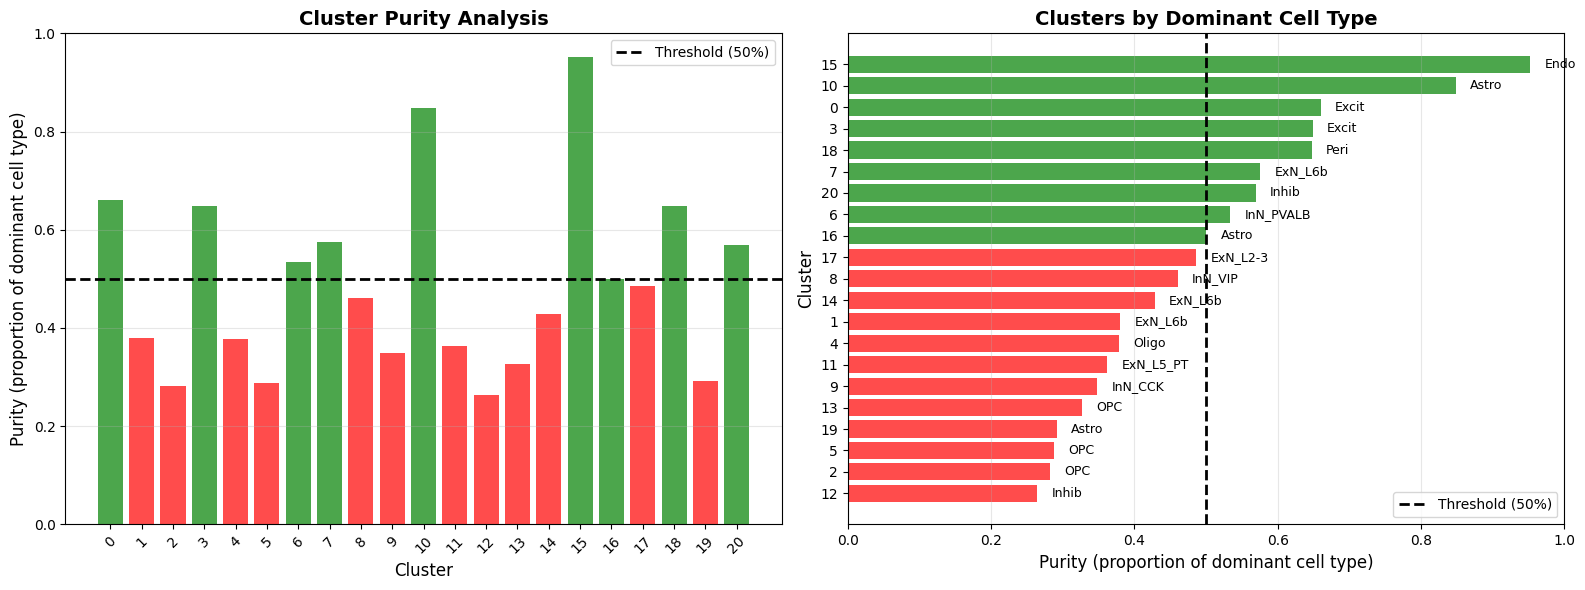

✓ Saved: plots/differential_expression/cluster_purity_analysis.png

CLUSTER FILTERING SUMMARY

Status          Clusters   Cells      % Cells   
--------------------------------------------------
Pure (≥50%)     9          7342           45.4%
Mixed (<50%)    12         8846           54.6%
--------------------------------------------------
Total           21         16188        100.0%

✓ Saved detailed cluster purity to: outputs/differential_expression_results/cluster_purity_detailed.csv


In [55]:
# Visualize cluster purity
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Barplot of cluster purity
ax = axes[0]
colors = ['green' if p >= PURITY_THRESHOLD else 'red' for p in cluster_purity['purity']]
bars = ax.bar(cluster_purity['cluster'].astype(str), cluster_purity['purity'], color=colors, alpha=0.7)
ax.axhline(PURITY_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({PURITY_THRESHOLD*100:.0f}%)')
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Purity (proportion of dominant cell type)', fontsize=12)
ax.set_title('Cluster Purity Analysis', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Rotate x-axis labels if many clusters
if len(cluster_purity) > 15:
    ax.tick_params(axis='x', rotation=45)

# Plot 2: Show which cell type dominates each cluster
ax = axes[1]
cluster_purity_sorted = cluster_purity.sort_values('purity', ascending=True)
colors = ['green' if p >= PURITY_THRESHOLD else 'red' for p in cluster_purity_sorted['purity']]
bars = ax.barh(cluster_purity_sorted['cluster'].astype(str), 
               cluster_purity_sorted['purity'], 
               color=colors, alpha=0.7)
ax.axvline(PURITY_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Threshold ({PURITY_THRESHOLD*100:.0f}%)')
ax.set_ylabel('Cluster', fontsize=12)
ax.set_xlabel('Purity (proportion of dominant cell type)', fontsize=12)
ax.set_title('Clusters by Dominant Cell Type', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.0)
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add cell type labels
for i, (cluster, celltype, purity) in enumerate(zip(cluster_purity_sorted['cluster'], 
                                                     cluster_purity_sorted['dominant_celltype'],
                                                     cluster_purity_sorted['purity'])):
    ax.text(purity + 0.02, i, f'{celltype}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'cluster_purity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {PLOTS_DIR / 'cluster_purity_analysis.png'}")

# Create a summary table
print("\n" + "="*60)
print("CLUSTER FILTERING SUMMARY")
print("="*60)
print(f"\n{'Status':<15} {'Clusters':<10} {'Cells':<10} {'% Cells':<10}")
print("-" * 50)

pure_cluster_cells = cluster_purity[cluster_purity['purity'] >= PURITY_THRESHOLD]['n_cells'].sum()
mixed_cluster_cells = cluster_purity[cluster_purity['purity'] < PURITY_THRESHOLD]['n_cells'].sum()
total_cells = pure_cluster_cells + mixed_cluster_cells

print(f"{'Pure (≥50%)':<15} {len(pure_clusters):<10} {pure_cluster_cells:<10} {pure_cluster_cells/total_cells*100:>8.1f}%")
print(f"{'Mixed (<50%)':<15} {len(mixed_clusters):<10} {mixed_cluster_cells:<10} {mixed_cluster_cells/total_cells*100:>8.1f}%")
print("-" * 50)
print(f"{'Total':<15} {len(cluster_purity):<10} {total_cells:<10} {'100.0%':>8}")

# Save purity visualization data
cluster_purity.to_csv(OUTPUT_DIR / 'cluster_purity_detailed.csv', index=False)
print(f"\n✓ Saved detailed cluster purity to: {OUTPUT_DIR / 'cluster_purity_detailed.csv'}")


## 3. Parameter Configuration

Configure which cell types to analyze and set analysis parameters.


In [56]:
# ============================================================================
# CELL TYPE SELECTION
# ============================================================================

# Automatically use all cell types present in the filtered data
# These come from pure clusters only (>50% one cell type)
celltype_counts = adata.obs['celltype'].value_counts()
CELL_TYPES_TO_ANALYZE = celltype_counts.index.tolist()

print("Cell types available (from pure clusters):")
for ct in CELL_TYPES_TO_ANALYZE:
    n_cells = celltype_counts[ct]
    n_samples = adata.obs[adata.obs['celltype'] == ct]['orig.ident'].nunique()
    print(f"  {ct}: {n_cells:,} cells across {n_samples} samples")

# Optional: Filter to only major cell types (uncomment to use)
# MAJOR_CELL_TYPES = ['Excit', 'Inhib', 'Astro', 'Oligo', 'OPC', 'Micro', 'Endo']
# CELL_TYPES_TO_ANALYZE = [ct for ct in CELL_TYPES_TO_ANALYZE if ct in MAJOR_CELL_TYPES]

# Optional: Filter by minimum cell count (uncomment to use)
MIN_CELLS_PER_TYPE = 100  # 🔧 Minimum cells per cell type
CELL_TYPES_TO_ANALYZE = [ct for ct in CELL_TYPES_TO_ANALYZE if celltype_counts[ct] >= MIN_CELLS_PER_TYPE]

print(f"\n✓ Will analyze {len(CELL_TYPES_TO_ANALYZE)} cell types (≥{MIN_CELLS_PER_TYPE} cells each)")

# ============================================================================
# PSEUDOBULK PARAMETERS
# ============================================================================

PSEUDOBULK_PARAMS = {
    'min_cells': 10,        # 🔧 Minimum cells per pseudobulk sample
    'min_samples': 2,       # 🔧 Minimum samples per condition for DE
}

# ============================================================================
# DIFFERENTIAL EXPRESSION PARAMETERS
# ============================================================================

DE_PARAMS = {
    'min_count': 5,         # 🔧 Minimum count threshold for gene filtering
    'min_samples_expr': 2,  # 🔧 Minimum samples expressing gene
    'fc_threshold': 0.5,    # 🔧 Minimum log2 fold change for significance
    'pval_threshold': 0.05, # 🔧 P-value threshold (before FDR correction)
    'fdr_threshold': 0.05,  # 🔧 FDR threshold (after multiple testing correction)
}

# ============================================================================
# VISUALIZATION PARAMETERS
# ============================================================================

VIZ_PARAMS = {
    'top_n_genes': 50,      # 🔧 Number of top genes for heatmaps
    'volcano_fc_threshold': 0.5,  # 🔧 Log2FC threshold for volcano plot coloring
    'volcano_pval_threshold': 0.05,  # 🔧 P-value threshold for volcano plot
}

print("\nAnalysis configuration:")
print(f"  Cell types to analyze: {len(CELL_TYPES_TO_ANALYZE)}")
print(f"\n  Pseudobulk:")
print(f"    Min cells per sample: {PSEUDOBULK_PARAMS['min_cells']}")
print(f"    Min samples per condition: {PSEUDOBULK_PARAMS['min_samples']}")
print(f"\n  DE filtering:")
print(f"    Min count: {DE_PARAMS['min_count']}")
print(f"    Min samples expressing: {DE_PARAMS['min_samples_expr']}")
print(f"    Significance: |log2FC| > {DE_PARAMS['fc_threshold']}, FDR < {DE_PARAMS['fdr_threshold']}")


Cell types available (from pure clusters):
  Excit: 3,034 cells across 16 samples
  OPC: 981 cells across 16 samples
  ExN_L6b: 673 cells across 16 samples
  InN_PVALB: 578 cells across 16 samples
  Astro: 573 cells across 16 samples
  Inhib: 233 cells across 16 samples
  InN_VIP: 231 cells across 16 samples
  Endo: 210 cells across 16 samples
  Oligo: 178 cells across 16 samples
  InN_SST: 162 cells across 15 samples
  Peri: 131 cells across 13 samples
  Micro: 126 cells across 15 samples
  VLMC: 98 cells across 15 samples
  InN_CCK: 64 cells across 14 samples
  SMC: 56 cells across 15 samples
  ExN_L5_PT: 9 cells across 6 samples
  ExN_L2-3: 3 cells across 3 samples
  ExN_L6_CT: 2 cells across 1 samples

✓ Will analyze 12 cell types (≥100 cells each)

Analysis configuration:
  Cell types to analyze: 12

  Pseudobulk:
    Min cells per sample: 10
    Min samples per condition: 2

  DE filtering:
    Min count: 5
    Min samples expressing: 2
    Significance: |log2FC| > 0.5, FDR < 0.0

## 4. Prepare Data for Analysis

Create condition column and prepare for pseudobulk aggregation.


In [57]:
# Create condition column (Genotype_Stimulation)
adata = create_condition_column(adata)

print("Condition distribution:")
print(adata.obs['condition'].value_counts().sort_index())

# Check sample metadata
print("\nSample metadata:")
sample_info = adata.obs.groupby('orig.ident').agg({
    'Genotype': 'first',
    'Stimulation': 'first',
    'Sex': 'first',
    'condition': 'first'
}).reset_index()
print(sample_info.to_string(index=False))


Condition distribution:
condition
E3_Ctrl     1555
E3_GENUS    2551
E4_Ctrl     1499
E4_GENUS    1737
Name: count, dtype: int64

Sample metadata:
orig.ident Genotype Stimulation Sex condition
  D25-2675       E3        Ctrl   M   E3_Ctrl
  D25-2676       E4        Ctrl   M   E4_Ctrl
  D25-2677       E3        Ctrl   F   E3_Ctrl
  D25-2678       E4        Ctrl   F   E4_Ctrl
  D25-2679       E3        Ctrl   M   E3_Ctrl
  D25-2680       E4        Ctrl   M   E4_Ctrl
  D25-2681       E3        Ctrl   F   E3_Ctrl
  D25-2682       E4        Ctrl   F   E4_Ctrl
  D25-2683       E3       GENUS   M  E3_GENUS
  D25-2684       E4       GENUS   M  E4_GENUS
  D25-2685       E3       GENUS   F  E3_GENUS
  D25-2686       E4       GENUS   F  E4_GENUS
  D25-2687       E3       GENUS   M  E3_GENUS
  D25-2688       E4       GENUS   M  E4_GENUS
  D25-2689       E3       GENUS   F  E3_GENUS
  D25-2690       E4       GENUS   F  E4_GENUS


## 5. Create Pseudobulk Samples

Aggregate cells per donor × cell type to create pseudobulk samples. This reduces single-cell noise and enables standard bulk RNA-seq statistical methods.


In [58]:
# Create pseudobulk samples
print("\n" + "="*60)
print("CREATING PSEUDOBULK SAMPLES")
print("="*60)

pb_df, sample_info_df = create_pseudobulk(
    adata,
    groupby=['orig.ident', 'celltype'],
    min_cells=PSEUDOBULK_PARAMS['min_cells']
)

print(f"\n✓ Created {pb_df.shape[1]} pseudobulk samples")
print(f"  Genes: {pb_df.shape[0]:,}")
print(f"\nSample info summary:")
print(sample_info_df.groupby('celltype').agg({
    'sample_id': 'count',
    'n_cells': ['mean', 'min', 'max']
}).round(1))



CREATING PSEUDOBULK SAMPLES
Creating pseudobulk samples...
Created 134 pseudobulk samples from 19608 genes

✓ Created 134 pseudobulk samples
  Genes: 19,608

Sample info summary:
          sample_id n_cells         
              count    mean min  max
celltype                            
Astro            14    40.1  12   91
Endo             10    19.1  10   40
ExN_L6b          13    50.6  10  123
Excit            16   189.6  26  345
InN_PVALB        15    38.3  11   77
InN_SST           8    15.5  10   21
InN_VIP           8    24.4  11   45
Inhib            11    18.5  10   33
Micro             6    12.7  11   14
OPC              16    61.3  11  101
Oligo             8    18.8  12   35
Peri              6    14.7  12   19
SMC               1    11.0  11   11
VLMC              2    12.5  12   13


In [59]:
# Check condition distribution per cell type
print("\nCondition distribution per cell type:")
for ct in CELL_TYPES_TO_ANALYZE:
    ct_samples = sample_info_df[sample_info_df['celltype'] == ct]
    if len(ct_samples) > 0:
        print(f"\n{ct}:")
        cond_counts = ct_samples['condition'].value_counts().sort_index()
        print(cond_counts)
        
        # Check if we have enough samples for DE
        n_conditions = ct_samples['condition'].nunique()
        if n_conditions < 2:
            print(f"  ⚠️  Only {n_conditions} condition(s) - cannot run DE analysis")
        elif len(ct_samples) < PSEUDOBULK_PARAMS['min_samples'] * 2:
            print(f"  ⚠️  Only {len(ct_samples)} samples - may have low power")



Condition distribution per cell type:

Excit:
condition
E3_Ctrl     4
E3_GENUS    4
E4_Ctrl     4
E4_GENUS    4
Name: count, dtype: int64

OPC:
condition
E3_Ctrl     4
E3_GENUS    4
E4_Ctrl     4
E4_GENUS    4
Name: count, dtype: int64

ExN_L6b:
condition
E3_Ctrl     3
E3_GENUS    4
E4_Ctrl     3
E4_GENUS    3
Name: count, dtype: int64

InN_PVALB:
condition
E3_Ctrl     4
E3_GENUS    4
E4_Ctrl     4
E4_GENUS    3
Name: count, dtype: int64

Astro:
condition
E3_Ctrl     3
E3_GENUS    4
E4_Ctrl     4
E4_GENUS    3
Name: count, dtype: int64

Inhib:
condition
E3_Ctrl     3
E3_GENUS    3
E4_Ctrl     2
E4_GENUS    3
Name: count, dtype: int64

InN_VIP:
condition
E3_Ctrl     4
E3_GENUS    1
E4_Ctrl     2
E4_GENUS    1
Name: count, dtype: int64

Endo:
condition
E3_Ctrl     3
E3_GENUS    3
E4_Ctrl     1
E4_GENUS    3
Name: count, dtype: int64

Oligo:
condition
E3_Ctrl     3
E3_GENUS    3
E4_Ctrl     1
E4_GENUS    1
Name: count, dtype: int64

InN_SST:
condition
E3_GENUS    3
E4_Ctrl     2
E4_GENUS

In [60]:
## 6. Differential Expression Analysis

# Run differential expression analysis for each cell type. We'll test multiple contrasts:
# - E3_GENUS vs E3_Ctrl (effect of stimulation in E3)
# - E4_GENUS vs E4_Ctrl (effect of stimulation in E4)
# - E4_Ctrl vs E3_Ctrl (genotype effect in control)
# - E4_GENUS vs E3_GENUS (genotype effect in stimulated)
from utils.differential_expression import run_de_for_celltype



In [61]:
# Run DE analysis for each cell type
all_de_results = []

for cell_type in CELL_TYPES_TO_ANALYZE:
    de_result = run_de_for_celltype(
        pb_df,
        sample_info_df,
        cell_type,
        DE_PARAMS
    )
    
    if de_result is not None:
        all_de_results.append(de_result)

if all_de_results:
    combined_results = pd.concat(all_de_results, ignore_index=True)
    
    # Save results
    output_file = OUTPUT_DIR / 'differential_expression_results.csv'
    combined_results.to_csv(output_file, index=False)
    
    print(f"\n{'='*60}")
    print("DE ANALYSIS SUMMARY")
    print(f"{'='*60}")
    print(f"✓ Total results: {len(combined_results):,} gene-contrast pairs")
    print(f"✓ Significant (FDR < {DE_PARAMS['fdr_threshold']}, |logFC| > {DE_PARAMS['fc_threshold']}): {combined_results['significant'].sum():,}")
    
    # Summary by cell type and contrast
    summary = combined_results.groupby(['cell_type', 'contrast']).agg({
        'significant': 'sum',
        'upregulated': 'sum',
        'downregulated': 'sum',
    }).round(0).astype(int)
    
    print(f"\nSignificant genes by cell type and contrast:")
    print(summary)
    
    print(f"\n✓ Saved results to: {output_file}")
else:
    print("\n⚠️  No DE results generated. Check cell type availability and sample sizes.")
    combined_results = None



ANALYZING: Excit
Filtering genes for DE analysis...
Kept 9620 genes after filtering
  Analyzing 9,620 genes across 16 samples
  Method: DESeq2 (negative binomial model)
  Testing E3_GENUS_vs_Ctrl (4 vs 4 samples)
    Input: 9620 genes × 8 samples
Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.93 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 4.98 seconds.

Fitting LFCs...
... done in 3.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.73 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            174.103989       -0.341685  0.195453 -1.748168  0.080435   
Mrpl15            3.743032        0.132542  0.863116  0.153562  0.877955   
Lypla1            7.823788       -0.513653  0.623042 -0.824428  0.409696   
Tcea1            26.098147        0.020302  0.335628  0.060490  0.951765   
Rgs20            29.147711       -0.821124  0.605842 -1.355342  0.175309   
...                    ...             ...       ...       ...       ...   
CAAA01118383.1    9.766982       -0.426593  0.480693 -0.887455  0.374834   
Vamp7             1.596238        1.310070  1.331336  0.984027  0.325102   
Tmlhe             9.261602       -0.155715  0.556903 -0.279609  0.779778   
4933409K07Rik     2.539978       -0.494148  0.853074 -0.579256  0.562416   
AC149090.1      342.448117        0.005561  0.807054  0.006890  0.994503   

                   

Fitting dispersions...
... done in 4.28 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 4.99 seconds.

Fitting LFCs...
... done in 3.70 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.58 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            126.070241        0.074533  0.233617  0.319038  0.749698   
Mrpl15            2.979079        0.376438  1.011198  0.372270  0.709692   
Lypla1            3.360342       -0.017461  0.846183 -0.020635  0.983536   
Tcea1            21.214856        0.198650  0.357214  0.556109  0.578137   
Rgs20            24.090568       -0.492646  0.418904 -1.176036  0.239581   
...                    ...             ...       ...       ...       ...   
CAAA01118383.1    4.094139        0.587612  0.822153  0.714723  0.474780   
Vamp7             1.374949        1.765422  1.697184  1.040207  0.298244   
Tmlhe             7.149429       -0.141800  0.567727 -0.249769  0.802766   
4933409K07Rik     1.657366        0.222668  1.237732  0.179900  0.857231   
AC149090.1      108.764697        0.402739  0.903794  0.445609  0.655879   

                   

Fitting dispersions...
... done in 4.76 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 5.15 seconds.

Fitting LFCs...
... done in 3.19 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.67 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            130.441531       -0.197291  0.221988 -0.888746  0.374139   
Mrpl15            2.717819        0.107011  1.082837  0.098825  0.921277   
Lypla1            4.874066       -1.081556  0.679625 -1.591403  0.111519   
Tcea1            18.800862        0.042353  0.361573  0.117136  0.906752   
Rgs20            27.004522        0.031494  0.427091  0.073741  0.941216   
...                    ...             ...       ...       ...       ...   
CAAA01118383.1    5.883778       -1.035594  0.693594 -1.493083  0.135415   
Vamp7             0.533012       -0.578967  2.355331 -0.245811  0.805828   
Tmlhe             7.230819        0.180272  0.555012  0.324808  0.745326   
4933409K07Rik     1.630556       -0.851723  1.118479 -0.761501  0.446358   
AC149090.1      169.785733       -1.381558  0.834787 -1.654983  0.097928   

                    

Fitting dispersions...
... done in 4.48 seconds.

Fitting dispersion trend curve...
... done in 0.15 seconds.

Fitting MAP dispersions...
... done in 5.01 seconds.

Fitting LFCs...
... done in 3.36 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.59 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            168.108027        0.201139  0.204370  0.984188  0.325023   
Mrpl15            4.133929        0.356157  0.820383  0.434135  0.664190   
Lypla1            5.704898       -0.590353  0.780076 -0.756790  0.449176   
Tcea1            29.445897        0.208889  0.329839  0.633305  0.526534   
Rgs20            25.060539        0.396849  0.582693  0.681060  0.495834   
...                    ...             ...       ...       ...       ...   
CAAA01118383.1    7.338818        0.010174  0.563072  0.018069  0.985584   
Vamp7             2.752855       -0.463811  1.102081 -0.420850  0.673864   
Tmlhe             9.176496        0.184084  0.570607  0.322611  0.746990   
4933409K07Rik     2.550776       -0.195948  0.999842 -0.195979  0.844626   
AC149090.1      258.334926       -0.977151  0.880094 -1.110281  0.266878   

                  

Fitting dispersions...
... done in 3.18 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 3.26 seconds.

Fitting LFCs...
... done in 2.06 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.42 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4             80.165295       -0.010722  0.224357 -0.047791  0.961883   
Lypla1            3.053829        0.193389  0.795523  0.243096  0.807931   
Tcea1             9.705791       -0.154926  0.461532 -0.335678  0.737114   
Rgs20            10.080522       -0.374203  0.460621 -0.812389  0.416568   
Atp6v1h           6.207379        0.327649  0.697086  0.470026  0.638336   
...                    ...             ...       ...       ...       ...   
mt-Nd6            3.317067       -0.924631  0.750973 -1.231244  0.218232   
mt-Cytb         104.019495        0.734765  0.296828  2.475389  0.013309   
CAAA01118383.1    2.522318        1.331638  0.941699  1.414080  0.157338   
Tmlhe             5.405331       -0.513700  0.691822 -0.742533  0.457765   
AC149090.1       99.160976       -0.226419  0.799459 -0.283215  0.777012   

                   

Fitting dispersions...
... done in 2.82 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 3.18 seconds.

Fitting LFCs...
... done in 2.42 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.42 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            56.148109       -0.180636  0.279108 -0.647190  0.517509   
Lypla1           0.699418       -0.455557  1.575580 -0.289136  0.772477   
Tcea1            6.730337        0.363299  0.553738  0.656084  0.511770   
Rgs20           10.546515       -0.333818  0.491431 -0.679278  0.496962   
Atp6v1h          5.690141       -0.151258  0.573253 -0.263860  0.791888   
...                   ...             ...       ...       ...       ...   
mt-Nd6           3.056743       -1.070335  0.839075 -1.275613  0.202092   
mt-Cytb         71.158894        0.338037  0.500024  0.676042  0.499014   
CAAA01118383.1   3.759512        0.104973  0.874165  0.120084  0.904417   
Tmlhe            3.276331       -0.379001  0.782143 -0.484567  0.627984   
AC149090.1      38.250012        0.526810  0.995901  0.528979  0.596820   

                    padj  
Xkr4

Fitting dispersions...
... done in 2.94 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 3.24 seconds.

Fitting LFCs...
... done in 2.13 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.55 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            62.411464       -0.040120  0.263781 -0.152096  0.879111   
Lypla1           1.421407       -1.176509  1.186292 -0.991753  0.321318   
Tcea1            6.788287       -0.431029  0.557227 -0.773525  0.439212   
Rgs20           10.123419        0.240712  0.485692  0.495606  0.620173   
Atp6v1h          5.088866        0.467750  0.722620  0.647296  0.517440   
...                   ...             ...       ...       ...       ...   
mt-Nd6           3.878043        0.482362  0.731794  0.659151  0.509799   
mt-Cytb         62.282034        0.046492  0.356227  0.130513  0.896160   
CAAA01118383.1   1.887394        1.088709  1.036244  1.050630  0.293428   
Tmlhe            4.163276       -0.415019  0.743281 -0.558361  0.576598   
AC149090.1      57.702103       -1.442492  0.830658 -1.736565  0.082464   

                    padj  
Xkr4 

Fitting dispersions...
... done in 2.93 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 3.35 seconds.

Fitting LFCs...
... done in 2.64 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.53 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4             72.796468       -0.183419  0.243080 -0.754565  0.450510   
Lypla1            2.172906       -1.965442  1.078590 -1.822233  0.068420   
Tcea1             9.695982        0.084494  0.456808  0.184965  0.853256   
Rgs20            10.596232        0.281057  0.474439  0.592400  0.553583   
Atp6v1h           6.991137        0.023107  0.524043  0.044094  0.964829   
...                    ...             ...       ...       ...       ...   
mt-Nd6            2.252462        0.327340  0.897291  0.364810  0.715253   
mt-Cytb         116.554182       -0.270977  0.254701 -1.063905  0.287372   
CAAA01118383.1    4.880867       -0.176740  0.804767 -0.219617  0.826170   
Tmlhe             4.280465       -0.268092  0.713720 -0.375627  0.707194   
AC149090.1       75.629825       -0.682447  0.962038 -0.709376  0.478091   

                  

Fitting dispersions...
... done in 4.14 seconds.

Fitting dispersion trend curve...
... done in 0.17 seconds.

Fitting MAP dispersions...
... done in 5.99 seconds.

Fitting LFCs...
... done in 3.36 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.56 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            130.960266       -0.354889  0.209435 -1.694512  0.090168   
Gm19938           1.744422        0.792607  1.417756  0.559057  0.576123   
Mrpl15            1.083043        2.112155  2.008426  1.051647  0.292962   
Lypla1            3.155699        0.342157  0.959120  0.356741  0.721286   
Tcea1            12.467470       -0.198018  0.467435 -0.423626  0.671838   
...                    ...             ...       ...       ...       ...   
mt-Nd6            1.444093       -0.738742  1.335186 -0.553288  0.580066   
mt-Cytb          67.056367        0.912380  0.456959  1.996632  0.045865   
CAAA01118383.1    2.136871        0.586168  1.098562  0.533577  0.593634   
Tmlhe             5.185813        0.755675  0.934626  0.808531  0.418785   
AC149090.1       84.314296        0.150795  0.917796  0.164301  0.869494   

                   

Fitting dispersions...
... done in 3.97 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 4.50 seconds.

Fitting LFCs...
... done in 3.89 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.53 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            152.741727        0.180097  0.191563  0.940145  0.347143   
Gm19938           2.107586        0.647961  1.216275  0.532742  0.594212   
Mrpl15            2.584847       -0.461564  1.077920 -0.428199  0.668507   
Lypla1            6.169322       -0.380695  0.715834 -0.531820  0.594850   
Tcea1            11.476576        0.197963  0.535523  0.369663  0.711633   
...                    ...             ...       ...       ...       ...   
mt-Nd6            0.560170        1.056781  2.601827  0.406169  0.684619   
mt-Cytb          68.546378        0.886106  0.248299  3.568712  0.000359   
CAAA01118383.1    2.314988        1.118107  1.211973  0.922551  0.356241   
Tmlhe             4.791533        0.718361  0.850499  0.844635  0.398315   
AC149090.1       57.739904        0.067847  0.807315  0.084041  0.933024   

                   

Fitting dispersions...
... done in 3.24 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 4.03 seconds.

Fitting LFCs...
... done in 3.33 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.51 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
                 baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            74.612045       -0.349276  0.270126 -1.293011  0.196007   
Gm19938          0.550636        0.208160  2.273043  0.091578  0.927033   
Mrpl15           0.635432        2.429044  2.636851  0.921191  0.356951   
Lypla1           2.551395        0.979524  1.162251  0.842782  0.399350   
Tcea1            6.007048       -0.559598  0.707240 -0.791242  0.428803   
...                   ...             ...       ...       ...       ...   
mt-Nd6           0.465840       -2.237304  2.701765 -0.828090  0.407620   
mt-Cytb         23.874628       -0.178492  0.400334 -0.445859  0.655699   
CAAA01118383.1   0.614512       -0.350255  2.164651 -0.161807  0.871458   
Tmlhe            1.548487       -0.284351  1.439776 -0.197497  0.843439   
AC149090.1      36.257116       -0.774773  0.716696 -1.081035  0.279681   

                   padj  
Xkr4  

Fitting dispersions...
... done in 3.73 seconds.

Fitting dispersion trend curve...
... done in 0.13 seconds.

Fitting MAP dispersions...
... done in 4.19 seconds.

Fitting LFCs...
... done in 2.47 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.53 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            242.545486        0.207668  0.144352  1.438619  0.150259   
Gm19938           4.581783        0.084696  0.797101  0.106256  0.915380   
Mrpl15            3.707146       -0.047084  0.804967 -0.058491  0.953357   
Lypla1            7.084183        0.251663  0.605442  0.415669  0.677652   
Tcea1            22.082076       -0.167791  0.363744 -0.461290  0.644591   
...                    ...             ...       ...       ...       ...   
mt-Nd6            2.160791       -0.597960  1.230283 -0.486035  0.626943   
mt-Cytb         152.911599       -0.198680  0.483442 -0.410969  0.681095   
CAAA01118383.1    5.438985       -0.110219  0.674959 -0.163297  0.870285   
Tmlhe            11.955864       -0.422183  0.547689 -0.770846  0.440798   
AC149090.1      136.568420       -0.875680  0.972147 -0.900769  0.367711   

                  

Fitting dispersions...
... done in 2.88 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 3.26 seconds.

Fitting LFCs...
... done in 2.25 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.40 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            131.332685        0.452656  0.233604  1.937707  0.052659   
Gm19938           1.994295        1.555351  1.119581  1.389226  0.164764   
Lypla1            3.291897        0.174152  0.785043  0.221837  0.824441   
Tcea1             4.926598        0.597604  0.611433  0.977382  0.328380   
Rgs20             6.075240        1.666728  0.653613  2.550021  0.010772   
...                    ...             ...       ...       ...       ...   
mt-Nd5            7.931586       -1.328503  0.626280 -2.121258  0.033900   
mt-Cytb          38.587785        0.209015  0.632704  0.330351  0.741134   
CAAA01118383.1    1.651326        0.319175  1.032705  0.309067  0.757271   
Tmlhe             4.532484       -0.201085  0.652896 -0.307989  0.758091   
AC149090.1       34.229372       -0.205993  0.815222 -0.252684  0.800513   

                   

Fitting dispersions...
... done in 3.10 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 3.20 seconds.

Fitting LFCs...
... done in 2.08 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.39 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            215.216713       -0.092612  0.226837 -0.408276  0.683071   
Gm19938           3.290925        1.118504  0.903154  1.238442  0.215552   
Lypla1            2.914346        0.446608  0.865216  0.516181  0.605728   
Tcea1             8.661843        0.285987  0.525407  0.544314  0.586225   
Rgs20             9.196337       -1.017680  0.550971 -1.847066  0.064738   
...                    ...             ...       ...       ...       ...   
mt-Nd5            9.938893       -0.779031  0.633389 -1.229941  0.218719   
mt-Cytb          45.601660       -0.293522  0.397862 -0.737750  0.460667   
CAAA01118383.1    2.081529        0.171124  1.009674  0.169484  0.865416   
Tmlhe             3.634533        0.504189  0.891503  0.565549  0.571700   
AC149090.1       23.985743       -0.167910  1.161169 -0.144604  0.885023   

                   

Fitting dispersions...
... done in 2.80 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 3.34 seconds.

Fitting LFCs...
... done in 2.26 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.56 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            107.916164        0.574123  0.242494  2.367578  0.017905   
Gm19938           0.864965        0.657743  1.616185  0.406972  0.684028   
Lypla1            1.817680       -0.546759  1.040431 -0.525512  0.599228   
Tcea1             3.761329        0.585998  0.733320  0.799103  0.424231   
Rgs20             4.441303        1.667373  0.738937  2.256447  0.024043   
...                    ...             ...       ...       ...       ...   
mt-Nd5            8.154186       -0.260895  0.692077 -0.376974  0.706193   
mt-Cytb          28.744336        0.097029  0.448278  0.216449  0.828638   
CAAA01118383.1    1.155925       -0.077277  1.244106 -0.062114  0.950472   
Tmlhe             2.835149       -1.054498  0.891782 -1.182461  0.237023   
AC149090.1       21.938551       -0.965160  0.936636 -1.030454  0.302797   

                    

Fitting dispersions...
... done in 3.01 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 3.24 seconds.

Fitting LFCs...
... done in 2.01 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.41 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Xkr4            271.057424        0.037612  0.219779  0.171136  0.864116   
Gm19938           6.143649        0.207702  0.658071  0.315622  0.752290   
Lypla1            5.749803       -0.214483  0.671246 -0.319530  0.749325   
Tcea1            11.653006        0.288789  0.456551  0.632546  0.527030   
Rgs20            12.878743       -1.010002  0.493786 -2.045424  0.040813   
...                    ...             ...       ...       ...       ...   
mt-Nd5            8.165797        0.326437  0.546232  0.597615  0.550097   
mt-Cytb          63.690356       -0.347552  0.346234 -1.003807  0.315472   
CAAA01118383.1    3.088115       -0.248559  0.873338 -0.284609  0.775944   
Tmlhe             6.609176       -0.314122  0.645503 -0.486631  0.626520   
AC149090.1       44.017170       -0.903902  1.041852 -0.867592  0.385618   

                  

Fitting dispersions...
... done in 2.74 seconds.

Fitting dispersion trend curve...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 2.93 seconds.

Fitting LFCs...
... done in 1.76 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.40 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        29.784503       -0.525083  0.630128 -0.833297  0.404678  0.999016
Lypla1       3.819206        0.127261  0.880086  0.144601  0.885026  0.999016
Tcea1        5.660553       -0.019309  0.751549 -0.025693  0.979503  0.999016
Rgs20       32.483392        0.663765  0.502346  1.321331  0.186391  0.999016
Atp6v1h      5.170750        0.588293  0.850234  0.691919  0.488988  0.999016
...               ...             ...       ...       ...       ...       ...
mt-Nd4      37.690827        0.605597  0.489078  1.238243  0.215626  0.999016
mt-Nd5       9.715527       -0.390513  0.638473 -0.611636  0.540779  0.999016
mt-Cytb     51.378270        0.477228  0.444282  1.074156  0.282753  0.999016
Tmlhe        4.407697        0.128805  0.822133  0.156672  0.875503  0.999016
AC149090.1  31.320596       -0.433270  0.515397 -0.840652  0.400543  0.999

Fitting dispersions...
... done in 2.79 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 3.18 seconds.

Fitting LFCs...
... done in 1.95 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.40 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        16.884049       -0.252649  0.554944 -0.455270  0.648915  0.999617
Lypla1       1.546498        2.201753  1.449736  1.518726  0.128831  0.999617
Tcea1        5.057508        0.036237  0.769255  0.047106  0.962428  0.999617
Rgs20       25.279070        0.799960  0.455362  1.756758  0.078959  0.999617
Atp6v1h      3.297772       -0.715600  0.945027 -0.757227  0.448914  0.999617
...               ...             ...       ...       ...       ...       ...
mt-Nd4      21.808838       -0.685038  0.455781 -1.502998  0.132839  0.999617
mt-Nd5       6.787972       -0.505901  0.707412 -0.715144  0.474520  0.999617
mt-Cytb     28.440401        0.408403  0.433125  0.942921  0.345721  0.999617
Tmlhe        2.676176        0.807396  1.046322  0.771651  0.440321  0.999617
AC149090.1  17.056375       -0.054185  1.321277 -0.041010  0.967288  0.999

Fitting dispersions...
... done in 2.68 seconds.

Fitting dispersion trend curve...
... done in 0.09 seconds.

Fitting MAP dispersions...
... done in 2.89 seconds.

Fitting LFCs...
... done in 1.91 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.38 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        22.488093       -0.435091  0.426815 -1.019391  0.308017  0.999982
Lypla1       1.464192       -1.999285  1.444563 -1.384007  0.166356  0.999982
Tcea1        5.002576        0.232278  0.739654  0.314036  0.753494  0.999982
Rgs20       19.312027        0.164781  0.492460  0.334607  0.737921  0.999982
Atp6v1h      3.524493        0.516474  0.843683  0.612166  0.540428  0.999982
...               ...             ...       ...       ...       ...       ...
mt-Nd4      25.066310        0.351554  0.421173  0.834703  0.403885  0.999982
mt-Nd5       8.212133       -0.089146  0.581966 -0.153181  0.878256  0.999982
mt-Cytb     28.204339       -0.233152  0.438411 -0.531811  0.594857  0.999982
Tmlhe        2.534567       -0.408789  1.029850 -0.396941  0.691411  0.999982
AC149090.1  22.028316       -0.627506  1.235562 -0.507871  0.611544  0.9999

Fitting dispersions...
... done in 2.73 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 2.88 seconds.

Fitting LFCs...
... done in 1.88 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.41 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
             baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
Xkr4        22.707786       -0.299846  0.713954 -0.419980  0.674500   1.0
Lypla1       3.899335        0.009298  0.859032  0.010824  0.991364   1.0
Tcea1        5.802164        0.206173  0.747275  0.275899  0.782626   1.0
Rgs20       40.582573        0.191799  0.453968  0.422495  0.672664   1.0
Atp6v1h      4.910277       -0.916365  0.906725 -1.010632  0.312193   1.0
...               ...             ...       ...       ...       ...   ...
mt-Nd4      33.846458       -1.056782  0.492752 -2.144654  0.031981   1.0
mt-Nd5       7.911834       -0.309942  0.727772 -0.425879  0.670196   1.0
mt-Cytb     51.761722       -0.411132  0.414951 -0.990796  0.321785   1.0
Tmlhe        4.622964        0.193124  0.812673  0.237641  0.812160   1.0
AC149090.1  24.398707       -0.290730  0.573284 -0.507130  0.612064   1.0

[5808 rows x 6 columns]
    ✓ 0 significan

Fitting dispersions...
... done in 1.28 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 1.55 seconds.

Fitting LFCs...
... done in 1.10 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.28 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        48.776088       -0.160120  0.380783 -0.420502  0.674119  0.999698
Tcea1        5.963880        0.597513  0.838439  0.712650  0.476063  0.999698
Rgs20        7.185326       -0.213145  0.779746 -0.273351  0.784583  0.999698
Atp6v1h      4.826856        0.980368  0.880005  1.114049  0.265258  0.999698
Rb1cc1       8.419250        0.696567  0.677083  1.028776  0.303585  0.999698
...               ...             ...       ...       ...       ...       ...
mt-Nd3       4.890343       -0.265973  0.924028 -0.287841  0.773468  0.999698
mt-Nd4       8.870200       -0.087302  0.802737 -0.108756  0.913396  0.999698
mt-Nd5       3.778627       -1.475789  1.026528 -1.437651  0.150533  0.999698
mt-Cytb     19.279323        0.372978  0.499489  0.746720  0.455233  0.999698
AC149090.1  16.582980       -0.125655  0.615904 -0.204018  0.838340  0.999

Fitting dispersions...
... done in 1.30 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.64 seconds.

Fitting LFCs...
... done in 1.11 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.29 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        30.600172        0.433181  0.470306  0.921062  0.357018  0.999801
Tcea1        1.859478        1.511199  1.704370  0.886661  0.375261  0.999801
Rgs20        3.497240       -0.572277  1.219898 -0.469119  0.638984  0.999801
Atp6v1h      1.352907       -0.915387  1.811391 -0.505350  0.613313  0.999801
Rb1cc1       5.476533       -0.782607  0.945482 -0.827733  0.407821  0.999801
...               ...             ...       ...       ...       ...       ...
mt-Nd3       6.417646       -1.000339  0.872115 -1.147027  0.251371  0.999801
mt-Nd4      12.029269        0.485835  0.695858  0.698182  0.485063  0.999801
mt-Nd5       2.886541        0.879866  1.364065  0.645032  0.518906  0.999801
mt-Cytb     18.899198        0.585428  0.591391  0.989916  0.322215  0.999801
AC149090.1   8.613722        1.529323  0.863734  1.770594  0.076628  0.999

Fitting dispersions...
... done in 1.19 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.54 seconds.

Fitting LFCs...
... done in 0.94 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.27 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue     padj
Xkr4        36.564849       -0.644568  0.481221 -1.339442  0.180427  0.99997
Tcea1        2.777589       -2.006513  1.625385 -1.234485  0.217022  0.99997
Rgs20        5.616994       -0.453493  0.966646 -0.469141  0.638969  0.99997
Atp6v1h      2.417062       -0.372569  1.432359 -0.260109  0.794780  0.99997
Rb1cc1       6.348393        0.569806  0.911630  0.625040  0.531945  0.99997
...               ...             ...       ...       ...       ...      ...
mt-Nd3       6.505197        1.157971  0.947217  1.222498  0.221520  0.99997
mt-Nd4       8.830537        0.514533  0.868174  0.592661  0.553408  0.99997
mt-Nd5       3.674303       -1.152046  1.303605 -0.883739  0.376837  0.99997
mt-Cytb     14.816245        0.206469  0.636430  0.324418  0.745622  0.99997
AC149090.1  10.387821       -1.633886  0.811980 -2.012225  0.044196  0.99997

[3199 ro

Fitting dispersions...
... done in 1.36 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 1.52 seconds.

Fitting LFCs...
... done in 0.99 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.24 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        42.248165       -0.063451  0.365663 -0.173522  0.862241  0.999458
Tcea1        4.860444       -1.043441  0.866565 -1.204111  0.228547  0.999458
Rgs20        4.967632       -0.856645  0.974182 -0.879348  0.379213  0.999458
Atp6v1h      3.620944       -2.235648  1.118440 -1.998898  0.045619  0.999458
Rb1cc1       7.455577       -0.921553  0.711378 -1.295447  0.195166  0.999458
...               ...             ...       ...       ...       ...       ...
mt-Nd3       4.973300        0.428807  0.862064  0.497419  0.618894  0.999458
mt-Nd4      12.136269        1.088691  0.662697  1.642818  0.100421  0.999458
mt-Nd5       2.996678        1.210448  1.089726  1.110782  0.266662  0.999458
mt-Cytb     23.197414        0.420283  0.468690  0.896718  0.369869  0.999458
AC149090.1  14.454458        0.017979  0.654723  0.027460  0.978093  0.99

Fitting dispersions...
... done in 1.21 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.69 seconds.

Fitting LFCs...
... done in 0.97 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.33 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        25.170308        0.121878  0.611978  0.199154  0.842142  0.999838
Tcea1        2.673680       -0.098135  1.556779 -0.063037  0.949737  0.999838
Rgs20        3.842215       -1.129496  1.452223 -0.777770  0.436704  0.999838
Atp6v1h      2.231561        0.607608  1.782633  0.340849  0.733217  0.999838
Rb1cc1      10.671598        0.890059  0.780158  1.140871  0.253923  0.999838
...               ...             ...       ...       ...       ...       ...
mt-Nd3       8.869859       -0.198704  0.938923 -0.211629  0.832396  0.999838
mt-Nd4      31.724290       -0.013505  0.742598 -0.018186  0.985491  0.999838
mt-Nd5       6.031909       -0.104651  1.114451 -0.093903  0.925186  0.999838
mt-Cytb     32.454686        0.553594  0.604862  0.915241  0.360065  0.999838
AC149090.1  37.140320       -4.082001  0.935947 -4.361356  0.000013  0.018

Fitting dispersions...
... done in 1.48 seconds.

Fitting dispersion trend curve...
... done in 0.10 seconds.

Fitting MAP dispersions...
... done in 1.63 seconds.

Fitting LFCs...
... done in 1.13 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.27 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        18.142386       -0.216955  0.526344 -0.412193  0.680198  0.998753
Tcea1        2.068276        0.006765  1.360280  0.004973  0.996032  0.998753
Rgs20        3.188471       -0.290015  1.172678 -0.247310  0.804668  0.998753
Atp6v1h      1.885370        0.630112  1.482072  0.425156  0.670723  0.998753
Rb1cc1       5.836448       -1.054488  0.889595 -1.185358  0.235876  0.998753
...               ...             ...       ...       ...       ...       ...
mt-Nd3       8.238180        0.626286  0.737547  0.849147  0.395800  0.998753
mt-Nd4      21.259831       -0.777226  0.639000 -1.216317  0.223864  0.998753
mt-Nd5       5.525912        0.608951  0.888742  0.685183  0.493228  0.998753
mt-Cytb     23.026417       -0.017197  0.520821 -0.033019  0.973659  0.998753
AC149090.1  25.843809       -2.313899  0.701208 -3.299877  0.000967  0.9987

Fitting dispersions...
... done in 2.67 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 2.73 seconds.

Fitting LFCs...
... done in 1.71 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.36 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4          5.895738       -2.080250  1.565817 -1.328540  0.184000  0.978623
Sox17         3.321097        0.421952  0.937516  0.450075  0.652656       NaN
Lypla1        3.746194        0.746230  1.048157  0.711944  0.476499       NaN
Tcea1         4.265045       -0.356509  1.254094 -0.284276  0.776199  0.999438
Atp6v1h       7.682701       -0.356840  0.627897 -0.568309  0.569825  0.999438
...                ...             ...       ...       ...       ...       ...
mt-Nd5       41.888679       -0.826664  0.805640 -1.026096  0.304846  0.999438
mt-Nd6        7.679297       -1.931082  0.755449 -2.556206  0.010582  0.451444
mt-Cytb     286.377790        0.385206  0.796244  0.483779  0.628543  0.999438
Tmlhe         2.471371       -0.058227  1.355920 -0.042943  0.965747       NaN
AC149090.1    6.195519       -1.331349  1.146799 -1.160926  0.2

Fitting dispersions...
... done in 1.89 seconds.

Fitting dispersion trend curve...
... done in 0.12 seconds.

Fitting MAP dispersions...
... done in 2.37 seconds.

Fitting LFCs...
... done in 1.26 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.31 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
Xkr4          0.954235        2.377099  5.359845  0.443501  0.657403   1.0
Sox17         3.453402       -0.887470  2.182478 -0.406634  0.684277   1.0
Lypla1        5.224942       -0.460488  1.777282 -0.259097  0.795560   1.0
Tcea1         7.713145        0.688704  1.544632  0.445869  0.655692   1.0
Atp6v1h       5.717618        0.671891  2.064994  0.325372  0.744900   1.0
...                ...             ...       ...       ...       ...   ...
mt-Nd5       38.630274       -0.805569  0.736810 -1.093320  0.274253   1.0
mt-Nd6        7.301349       -1.312079  1.485725 -0.883124  0.377169   1.0
mt-Cytb     356.940333        0.398854  0.423340  0.942159  0.346111   1.0
Tmlhe         2.456550       -1.009596  2.719959 -0.371181  0.710503   1.0
AC149090.1    4.051756        4.479714  3.860261  1.160469  0.245858   1.0

[4615 rows x 6 columns]
    ✓ 0

Fitting dispersions...
... done in 1.97 seconds.

Fitting dispersion trend curve...
... done in 0.07 seconds.

Fitting MAP dispersions...
... done in 2.15 seconds.

Fitting LFCs...
... done in 1.63 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.37 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4          4.285925       -5.480563  3.830424 -1.430798  0.152488  0.999105
Sox17         1.972617        0.734075  2.598885  0.282457  0.777593  0.999105
Lypla1        2.146197        1.058934  2.716332  0.389840  0.696655  0.999105
Tcea1         2.961925       -0.023956  2.273909 -0.010535  0.991594  0.999105
Atp6v1h       4.345039       -1.269271  1.924045 -0.659689  0.509454  0.999105
...                ...             ...       ...       ...       ...       ...
mt-Nd5       31.455776       -0.090838  1.142761 -0.079490  0.936643  0.999105
mt-Nd6        7.135332       -0.051710  1.535308 -0.033681  0.973132  0.999105
mt-Cytb     149.496416        0.047269  0.978212  0.048322  0.961459  0.999105
Tmlhe         1.621105        0.487488  3.334148  0.146211  0.883755  0.999105
AC149090.1    3.981042       -5.348510  4.017809 -1.331201  0.18

Fitting dispersions...
... done in 2.11 seconds.

Fitting dispersion trend curve...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 2.41 seconds.

Fitting LFCs...
... done in 1.43 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.32 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4          2.572719       -0.992614  1.950617 -0.508872  0.610842  0.999859
Sox17         4.839166       -0.532491  0.960743 -0.554249  0.579408  0.999859
Lypla1        6.814642       -0.113784  0.800315 -0.142174  0.886942  0.999859
Tcea1         8.550778        1.059301  0.850987  1.244791  0.213209  0.999859
Atp6v1h       9.526965       -0.219410  0.882331 -0.248671  0.803615  0.999859
...                ...             ...       ...       ...       ...       ...
mt-Nd5       45.549225       -0.031465  0.371561 -0.084683  0.932514  0.999859
mt-Nd6        6.235704        0.568749  0.828571  0.686422  0.492447  0.999859
mt-Cytb     508.168763        0.103110  0.254156  0.405698  0.684965  0.999859
Tmlhe         3.245981       -0.481694  1.228979 -0.391947  0.695097  0.999859
AC149090.1    6.363237        0.510135  0.861317  0.592272  0.

Fitting dispersions...
... done in 1.32 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.45 seconds.

Fitting LFCs...
... done in 1.02 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.29 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E3_GENUS vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        35.244831       -0.216770  0.431385 -0.502499  0.615317  0.999733
Rgs20        5.647309       -0.343696  0.840036 -0.409144  0.682434  0.999733
Rb1cc1       9.624943        0.149127  0.613640  0.243020  0.807990  0.999733
Pcmtd1       8.733837       -0.851640  0.727235 -1.171067  0.241572  0.999733
Sntg1       50.849967       -0.082986  0.447764 -0.185335  0.852967  0.999733
...               ...             ...       ...       ...       ...       ...
mt-Nd3       8.126759        1.223800  0.749413  1.633011  0.102467  0.999733
mt-Nd4      21.835126        1.475324  0.561923  2.625493  0.008652  0.999733
mt-Nd5       7.558149        1.140953  0.757764  1.505683  0.132149  0.999733
mt-Cytb     33.623936        1.949684  0.510524  3.818987  0.000134  0.180566
AC149090.1  29.298103       -0.678895  0.587617 -1.155336  0.247953  0.999

Fitting dispersions...
... done in 1.05 seconds.

Fitting dispersion trend curve...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 1.25 seconds.

Fitting LFCs...
... done in 0.75 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.22 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_Ctrl vs E3_Ctrl
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        31.133930       -0.458794  0.717210 -0.639693  0.522372  0.999699
Rgs20        5.542996       -0.230594  1.447735 -0.159279  0.873449  0.999699
Rb1cc1       6.967024       -1.217236  1.330700 -0.914734  0.360331  0.999699
Pcmtd1       9.093564       -0.736481  1.221702 -0.602831  0.546621  0.999699
Sntg1       44.880493       -0.150546  0.660556 -0.227908  0.819717  0.999699
...               ...             ...       ...       ...       ...       ...
mt-Nd3       6.599445        1.575041  1.213130  1.298328  0.194175  0.999699
mt-Nd4      10.287981       -0.155716  1.085116 -0.143502  0.885894  0.999699
mt-Nd5       3.746126       -0.850781  1.735902 -0.490109  0.624057  0.999699
mt-Cytb     14.245991        0.591974  0.932663  0.634714  0.525615  0.999699
AC149090.1  27.062389       -1.313931  0.853103 -1.540178  0.123517  0.9996

Fitting dispersions...
... done in 0.89 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.29 seconds.

Fitting LFCs...
... done in 0.75 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.24 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        32.308938       -0.027681  0.717413 -0.038585  0.969222  0.999693
Rgs20        4.122175       -0.876699  1.702145 -0.515055  0.606514  0.999693
Rb1cc1       9.677103       -0.170156  1.081824 -0.157286  0.875019  0.999693
Pcmtd1       6.970382        0.782474  1.239110  0.631480  0.527726  0.999693
Sntg1       45.368740       -0.574855  0.720910 -0.797402  0.425218  0.999693
...               ...             ...       ...       ...       ...       ...
mt-Nd3      14.582481        1.207962  0.955718  1.263932  0.206255  0.999693
mt-Nd4      36.366154        0.722045  0.717975  1.005669  0.314575  0.999693
mt-Nd5      13.374004        1.163416  0.953825  1.219737  0.222564  0.999693
mt-Cytb     66.290147        1.063359  0.624063  1.703931  0.088394  0.999693
AC149090.1  28.931235        1.102875  1.481047  0.744659  0.456478  0.99

Fitting dispersions...
... done in 1.48 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.93 seconds.

Fitting LFCs...
... done in 1.05 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.29 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E4_Ctrl
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        172.602341       -0.037449  0.287500 -0.130258  0.896362  0.998327
Gm19938       4.145890        2.469029  1.339071  1.843837  0.065207  0.998327
Tcea1         5.457073        0.825525  0.945503  0.873107  0.382605  0.998327
Rgs20         6.924478       -0.347819  0.855077 -0.406769  0.684177  0.998327
Atp6v1h       6.320786       -0.281826  0.852722 -0.330502  0.741021  0.998327
...                ...             ...       ...       ...       ...       ...
mt-Nd3        4.418562        0.228358  1.017114  0.224516  0.822356  0.998327
mt-Nd4       15.552581       -0.588528  0.578405 -1.017501  0.308915  0.998327
mt-Nd5        3.267280       -1.196231  1.207824 -0.990402  0.321978  0.998327
mt-Cytb      24.401935       -1.088910  0.550507 -1.978013  0.047927  0.998327
AC149090.1    8.426008        3.580064  1.255280  2.852005  0.0

Fitting dispersions...
... done in 1.68 seconds.

Fitting dispersion trend curve...
... done in 0.08 seconds.

Fitting MAP dispersions...
... done in 1.81 seconds.

Fitting LFCs...
... done in 1.02 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.28 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
              baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        190.344697       -0.221395  0.247510 -0.894489  0.371061  0.999805
Gm19938       6.945183       -0.202291  0.711587 -0.284281  0.776195  0.999805
Tcea1         5.126792        0.961357  0.786991  1.221560  0.221874  0.999805
Rgs20         6.011657        0.166496  0.743690  0.223878  0.822852  0.999805
Atp6v1h       6.603543       -0.206553  0.675583 -0.305740  0.759803  0.999805
...                ...             ...       ...       ...       ...       ...
mt-Nd3        5.094269        0.039201  0.857035  0.045741  0.963517  0.999805
mt-Nd4       15.558507       -0.327098  0.505768 -0.646734  0.517804  0.999805
mt-Nd5        2.729594       -0.585555  1.051084 -0.557097  0.577461  0.999805
mt-Cytb      22.500011       -0.632670  0.504530 -1.253979  0.209850  0.999805
AC149090.1   18.745049       -0.790017  1.164092 -0.678655  0.

Fitting dispersions...
... done in 0.60 seconds.

Fitting dispersion trend curve...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.77 seconds.

Fitting LFCs...
... done in 0.46 seconds.

Calculating cook's distance...
... done in 0.00 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 0.21 seconds.



Log2 fold change & Wald test p-value: condition E4_GENUS vs E3_GENUS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Xkr4        24.279519        0.307387  0.845127  0.363717  0.716069  0.999997
Rgs20        5.568599        0.042648  1.245013  0.034255  0.972673  0.999997
Rb1cc1       5.700569       -0.065424  1.213475 -0.053915  0.957003  0.999997
Pcmtd1       3.128588        0.629380  1.768426  0.355899  0.721917  0.999997
Sntg1       42.588436        0.355988  0.599645  0.593665  0.552736  0.999997
...               ...             ...       ...       ...       ...       ...
mt-Nd3      10.802864       -1.215246  0.951643 -1.276998  0.201603  0.999997
mt-Nd4      34.442668       -1.479228  0.747715 -1.978332  0.047891  0.999997
mt-Nd5       6.557895       -1.151930  1.216210 -0.947147  0.343564  0.999997
mt-Cytb     34.378785       -0.305746  0.682089 -0.448250  0.653973  0.999997
AC149090.1  16.643704        0.224429  0.923707  0.242965  0.808032  0.99

## 7. Visualization: Heatmaps

Create heatmaps showing upregulated and downregulated genes for each cell type and contrast.


In [62]:
# Import heatmap plotting function from utils
from utils.differential_expression import plot_de_heatmap



GENERATING HEATMAPS
  Saved: plots/differential_expression/heatmap_Excit_E3_GENUS_vs_Ctrl.png


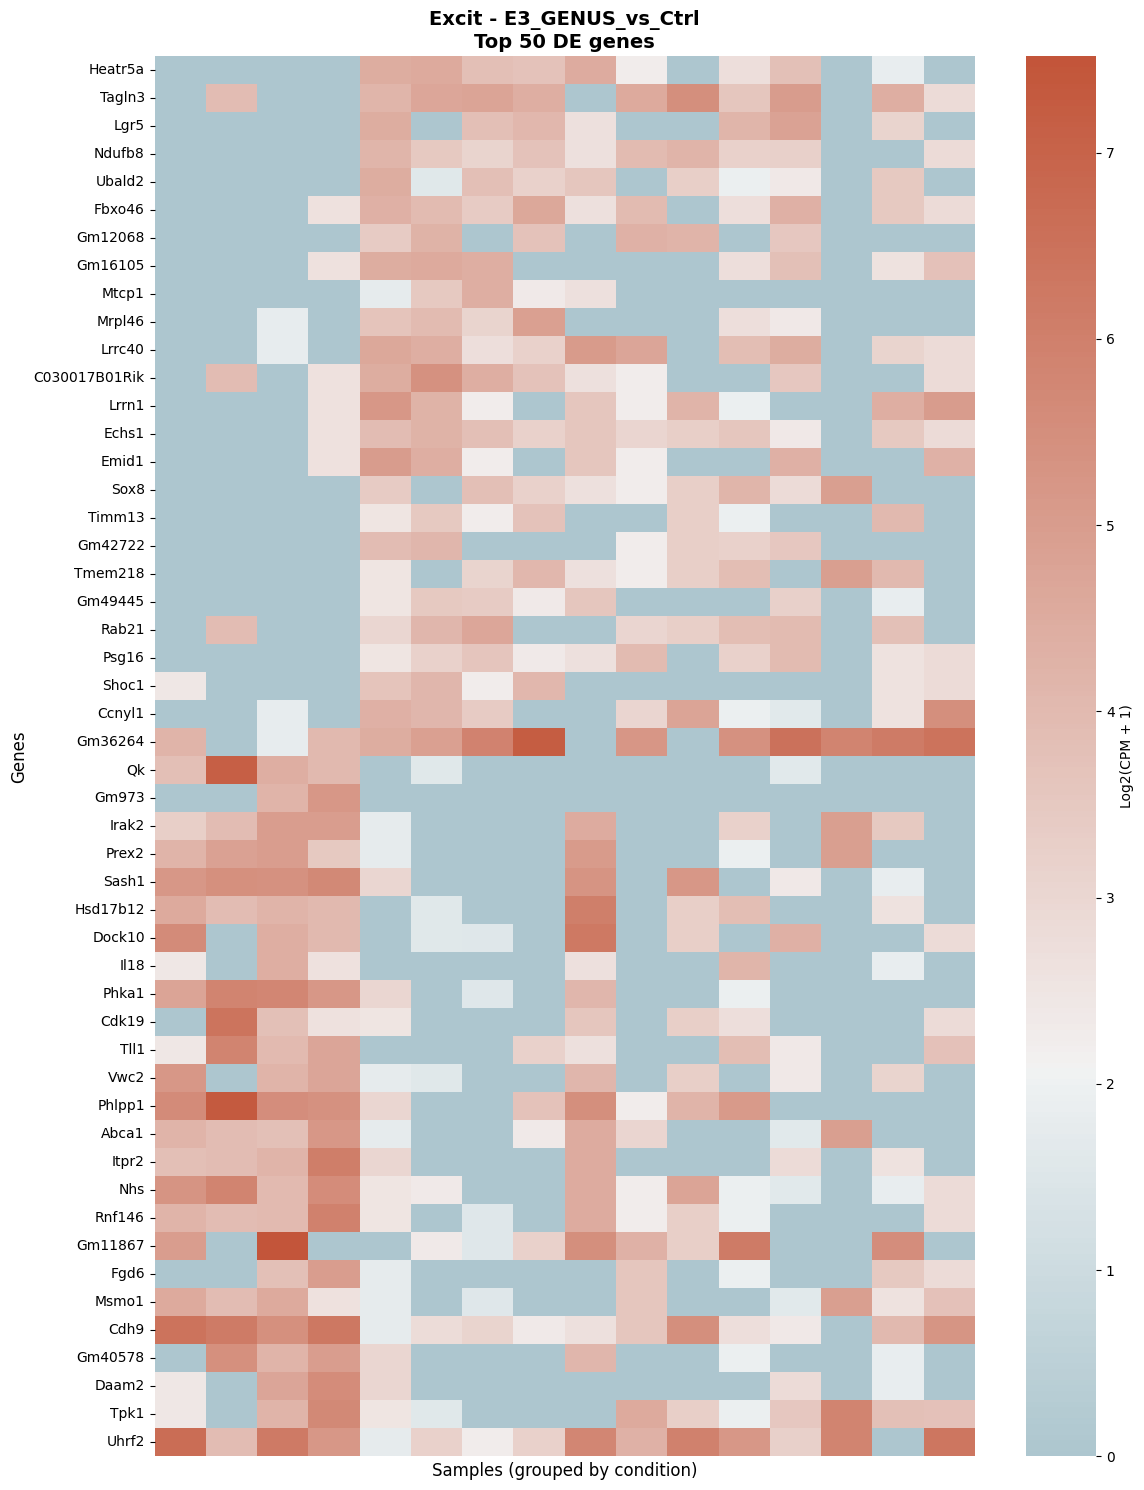

  Saved: plots/differential_expression/heatmap_Excit_E4_GENUS_vs_Ctrl.png


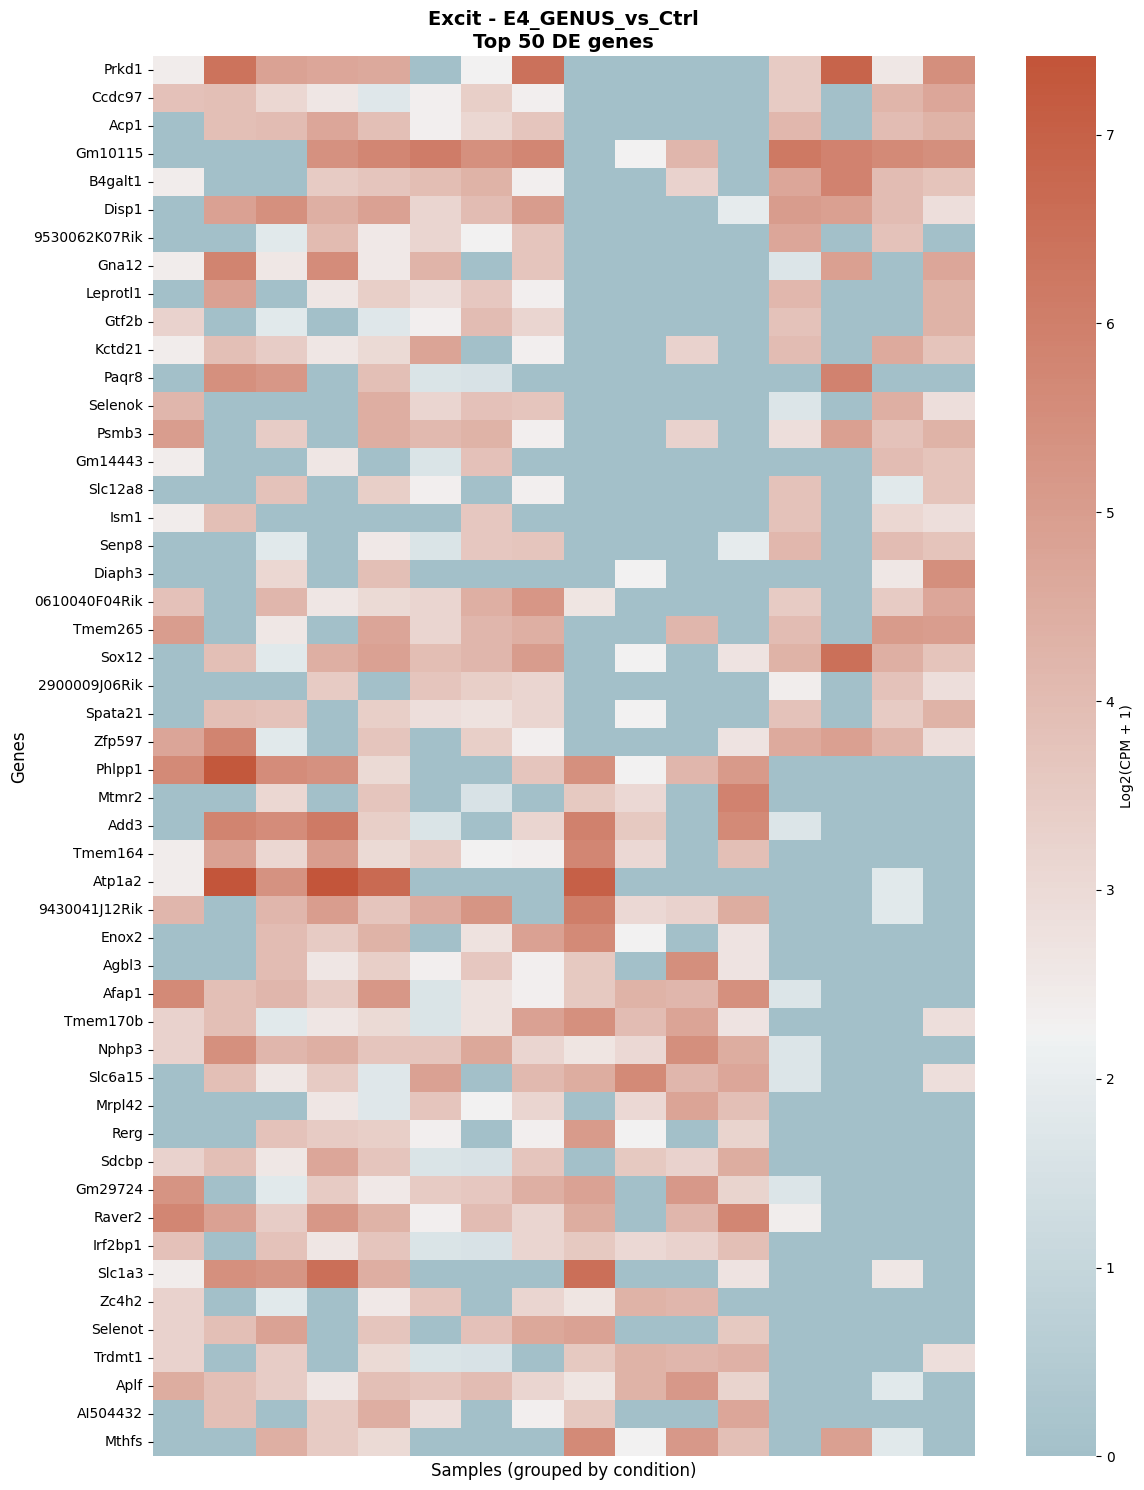

  Saved: plots/differential_expression/heatmap_Excit_E4_vs_E3_Ctrl.png


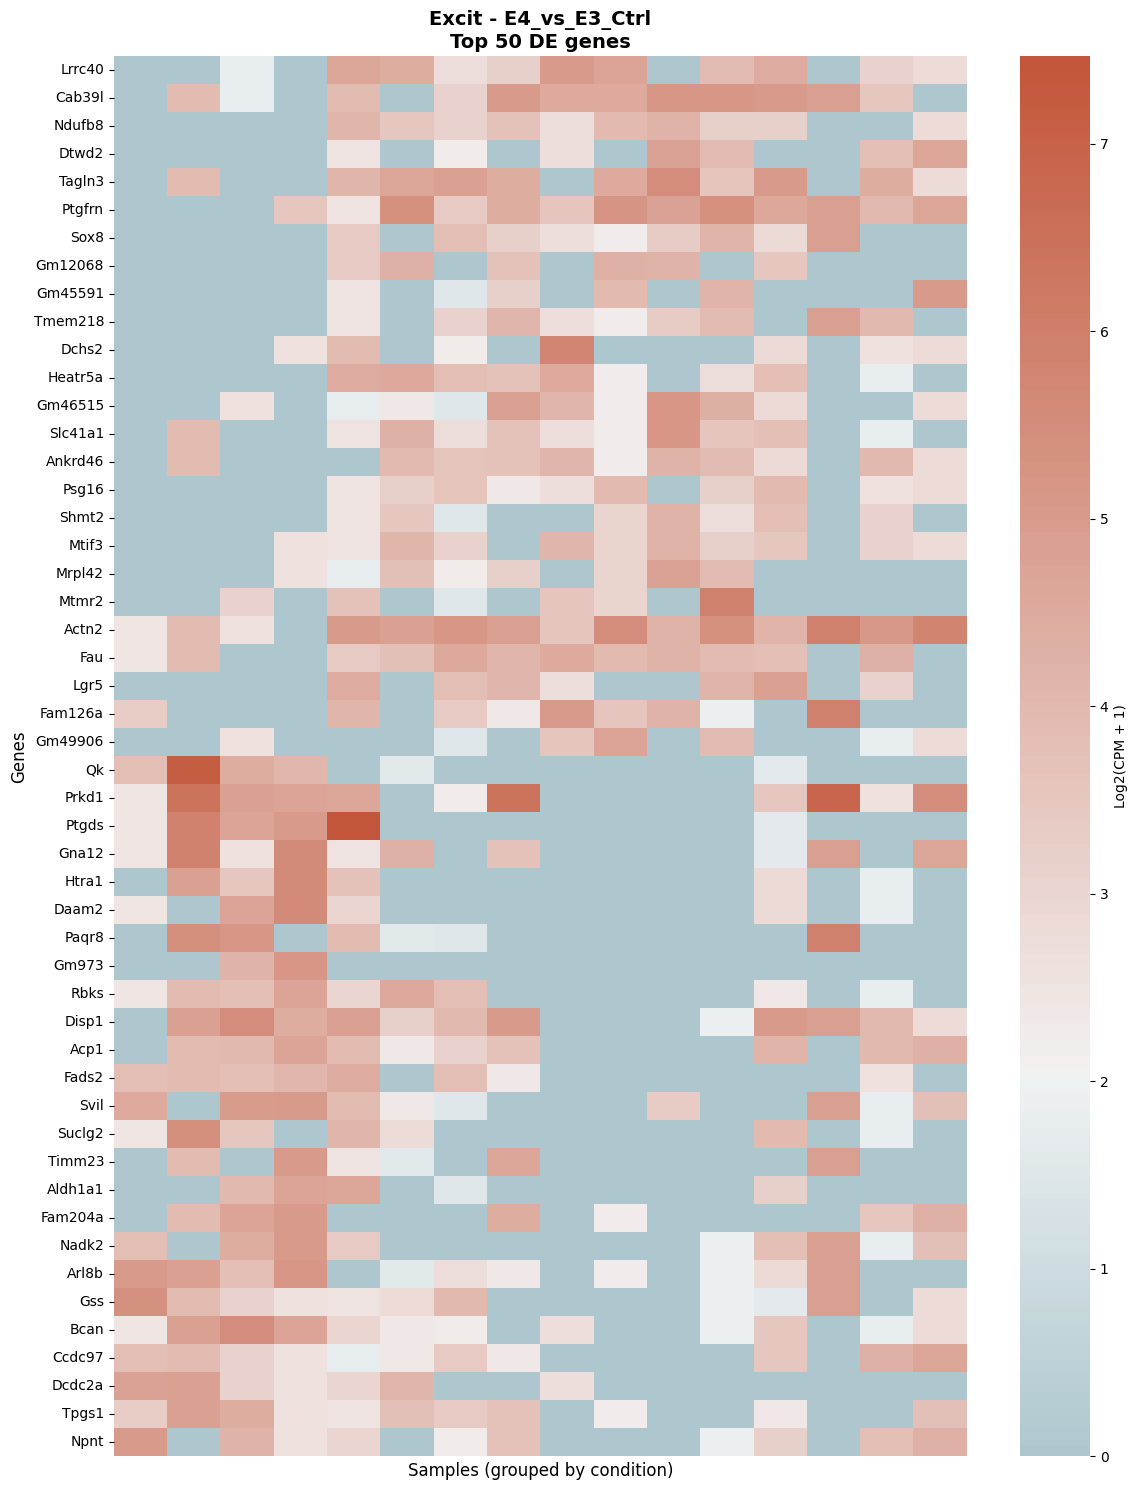

  Saved: plots/differential_expression/heatmap_Excit_E4_vs_E3_GENUS.png


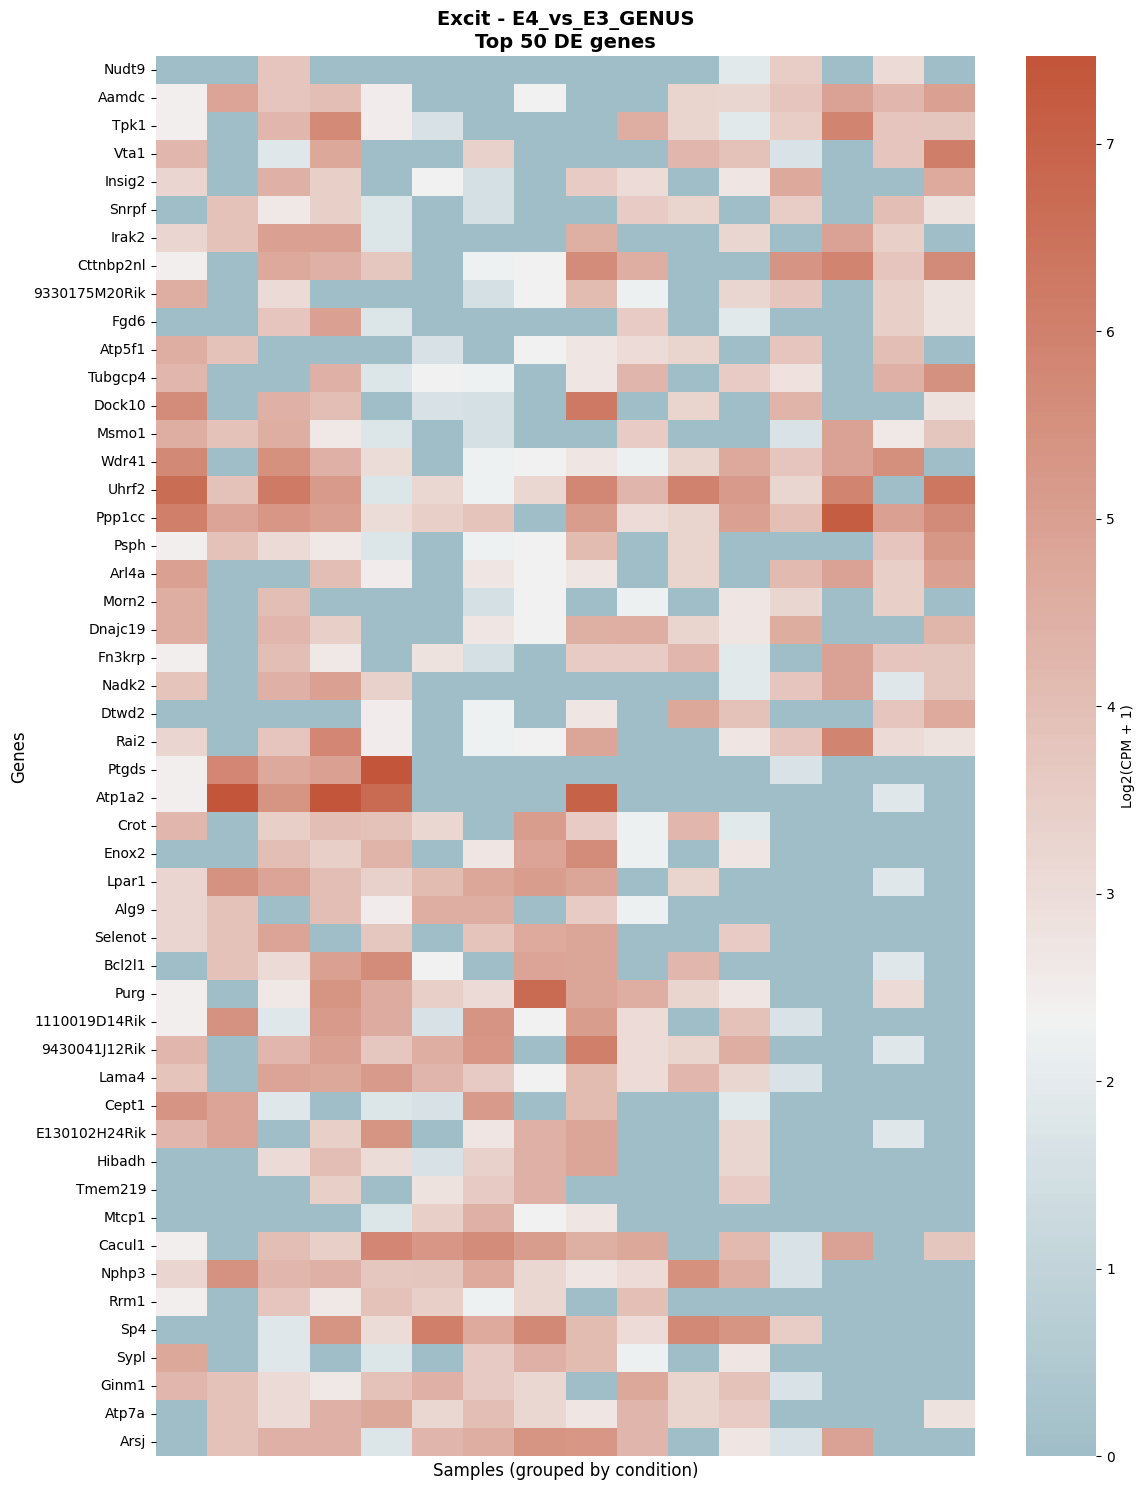

  Saved: plots/differential_expression/heatmap_OPC_E3_GENUS_vs_Ctrl.png


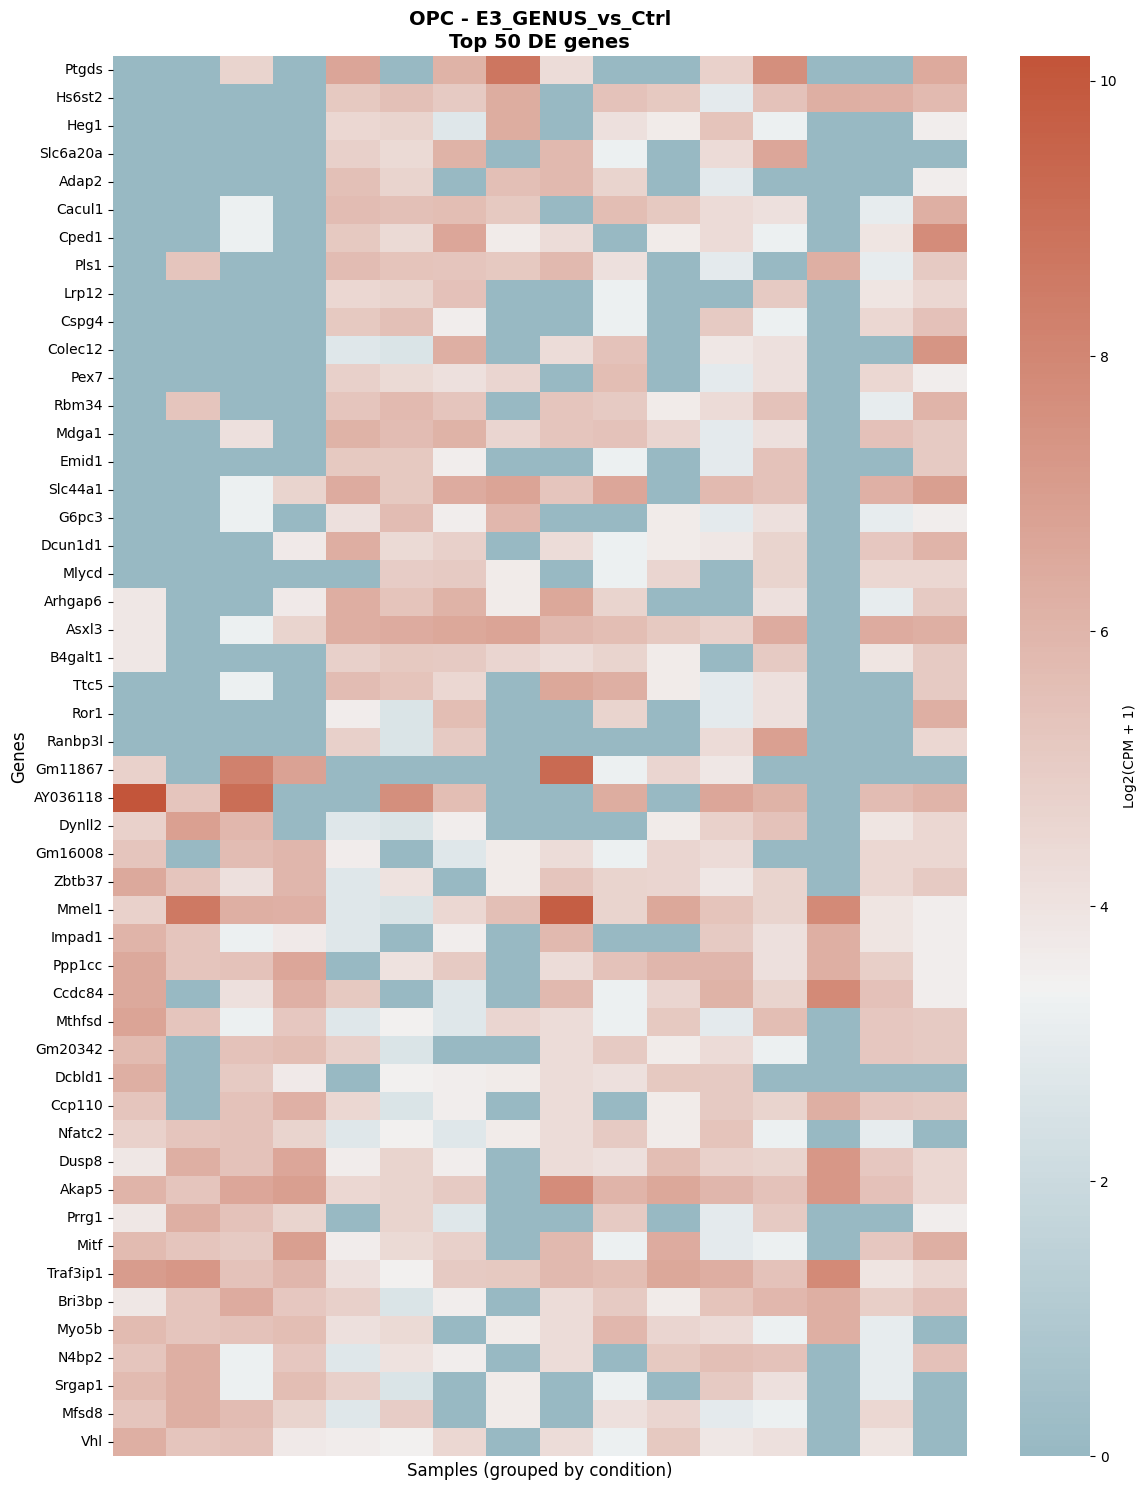

  Saved: plots/differential_expression/heatmap_OPC_E4_GENUS_vs_Ctrl.png


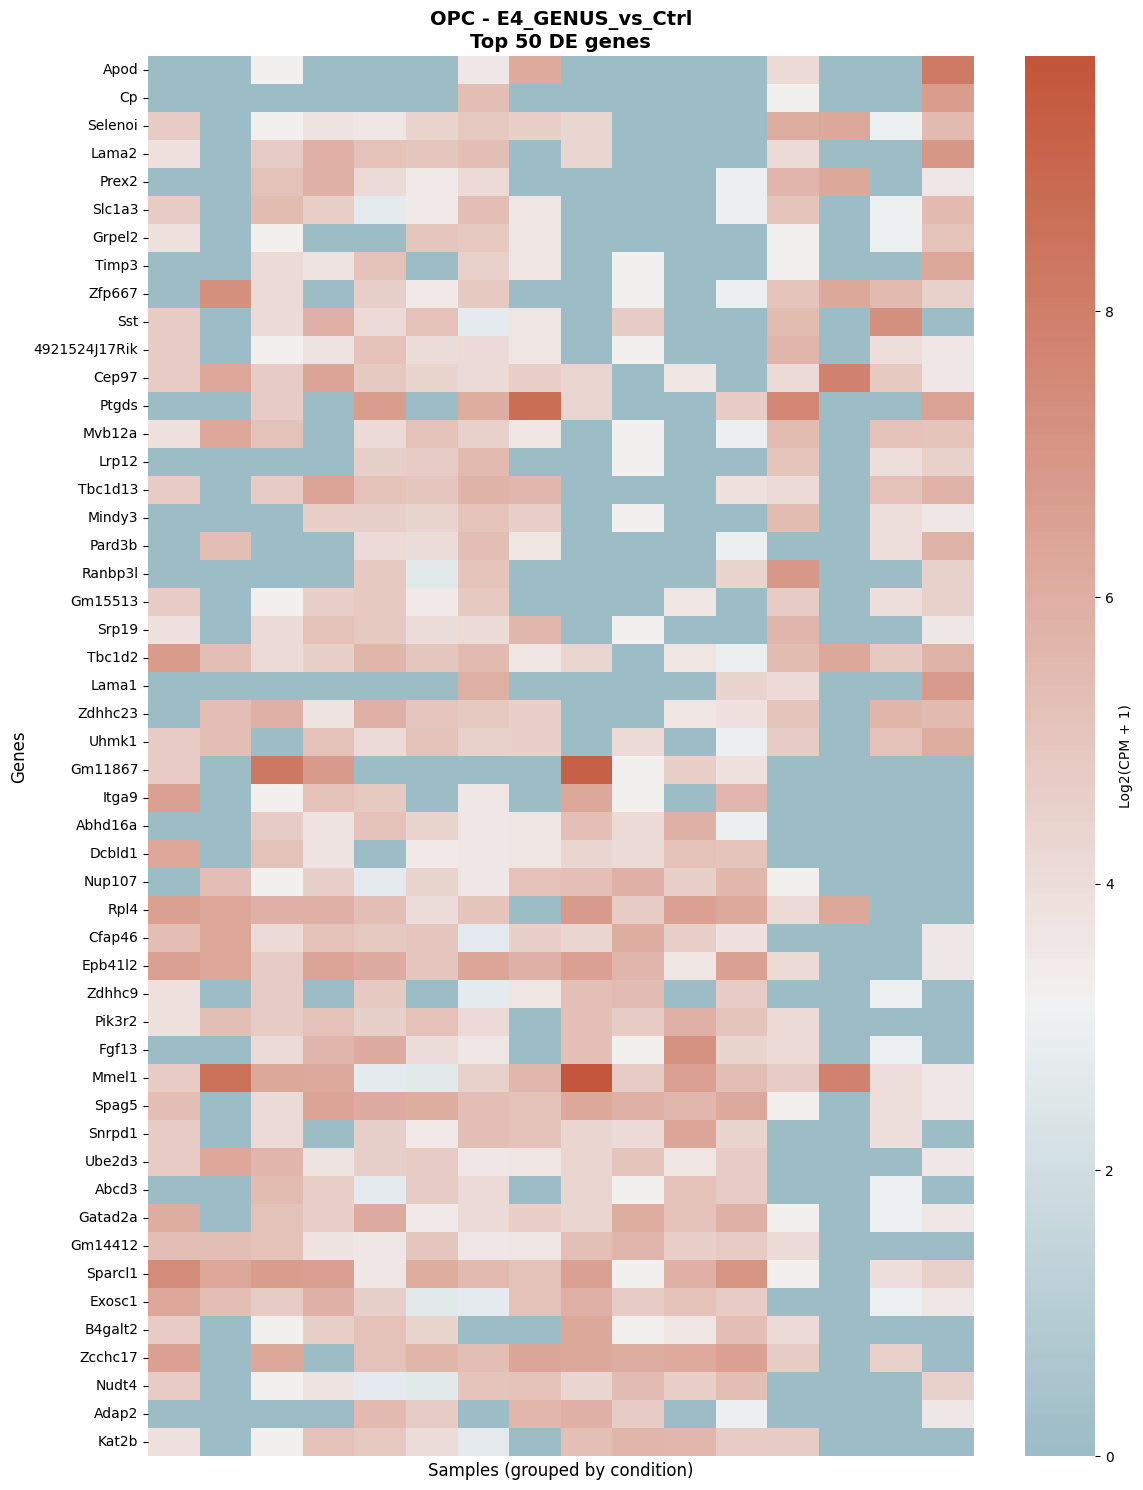

  Saved: plots/differential_expression/heatmap_OPC_E4_vs_E3_Ctrl.png


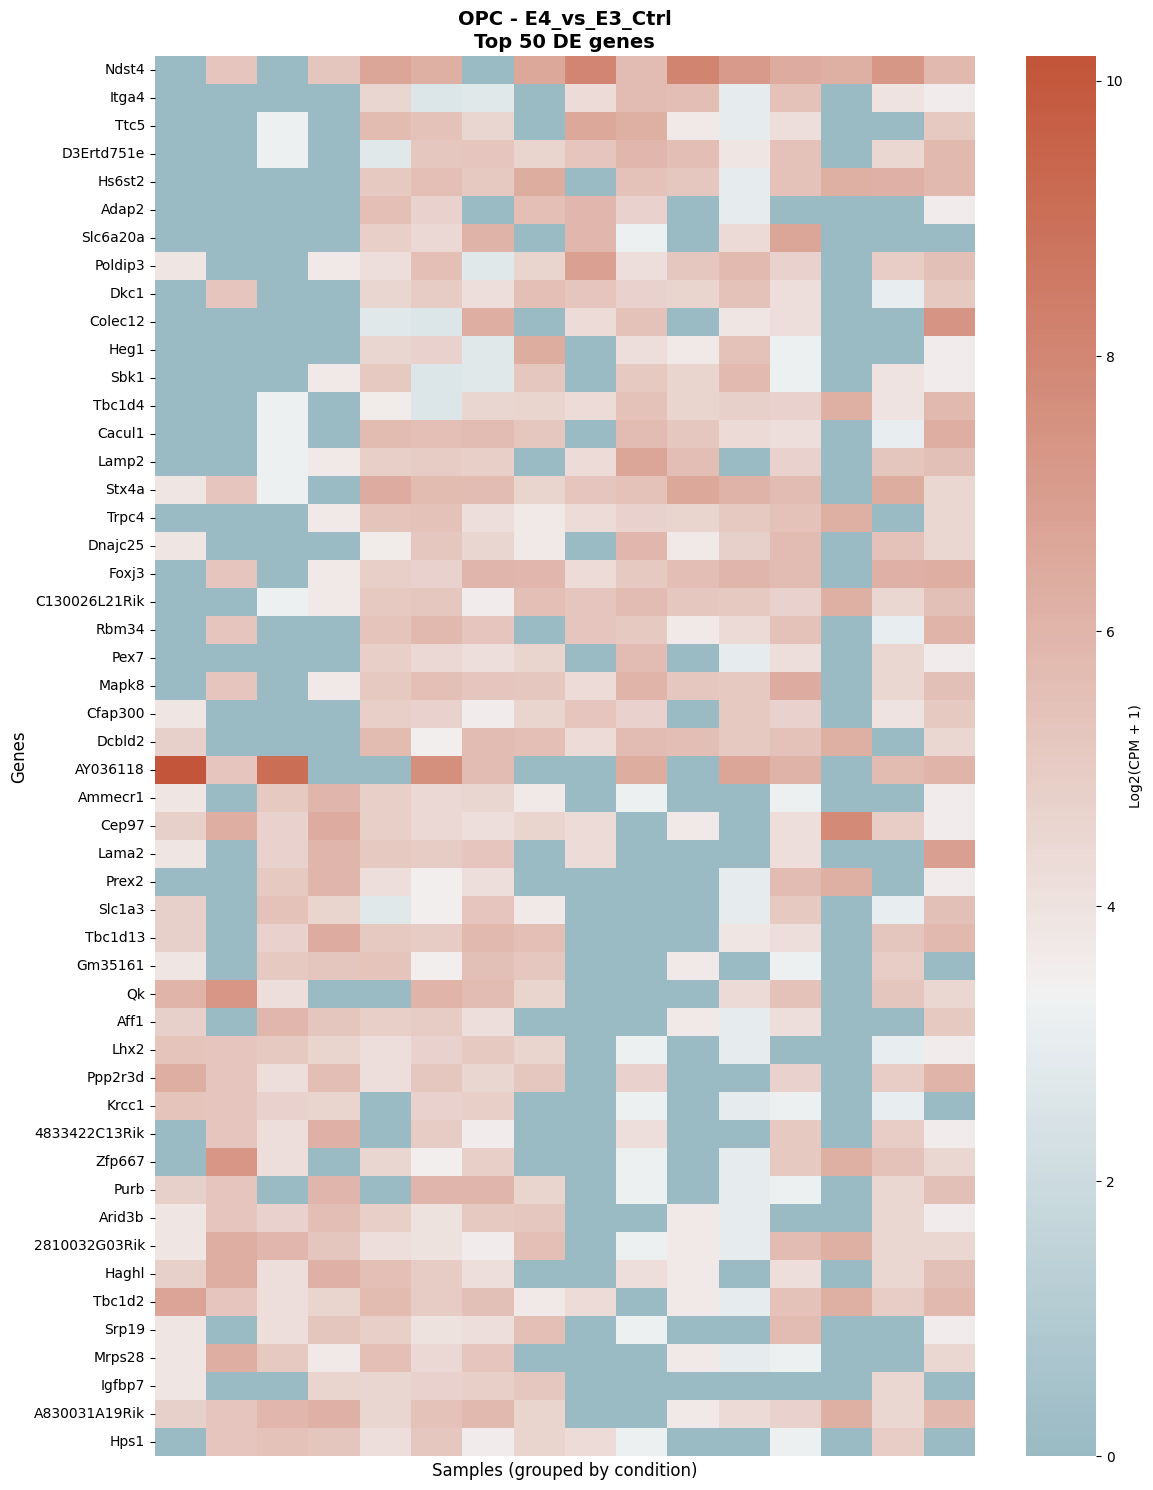

  Saved: plots/differential_expression/heatmap_OPC_E4_vs_E3_GENUS.png


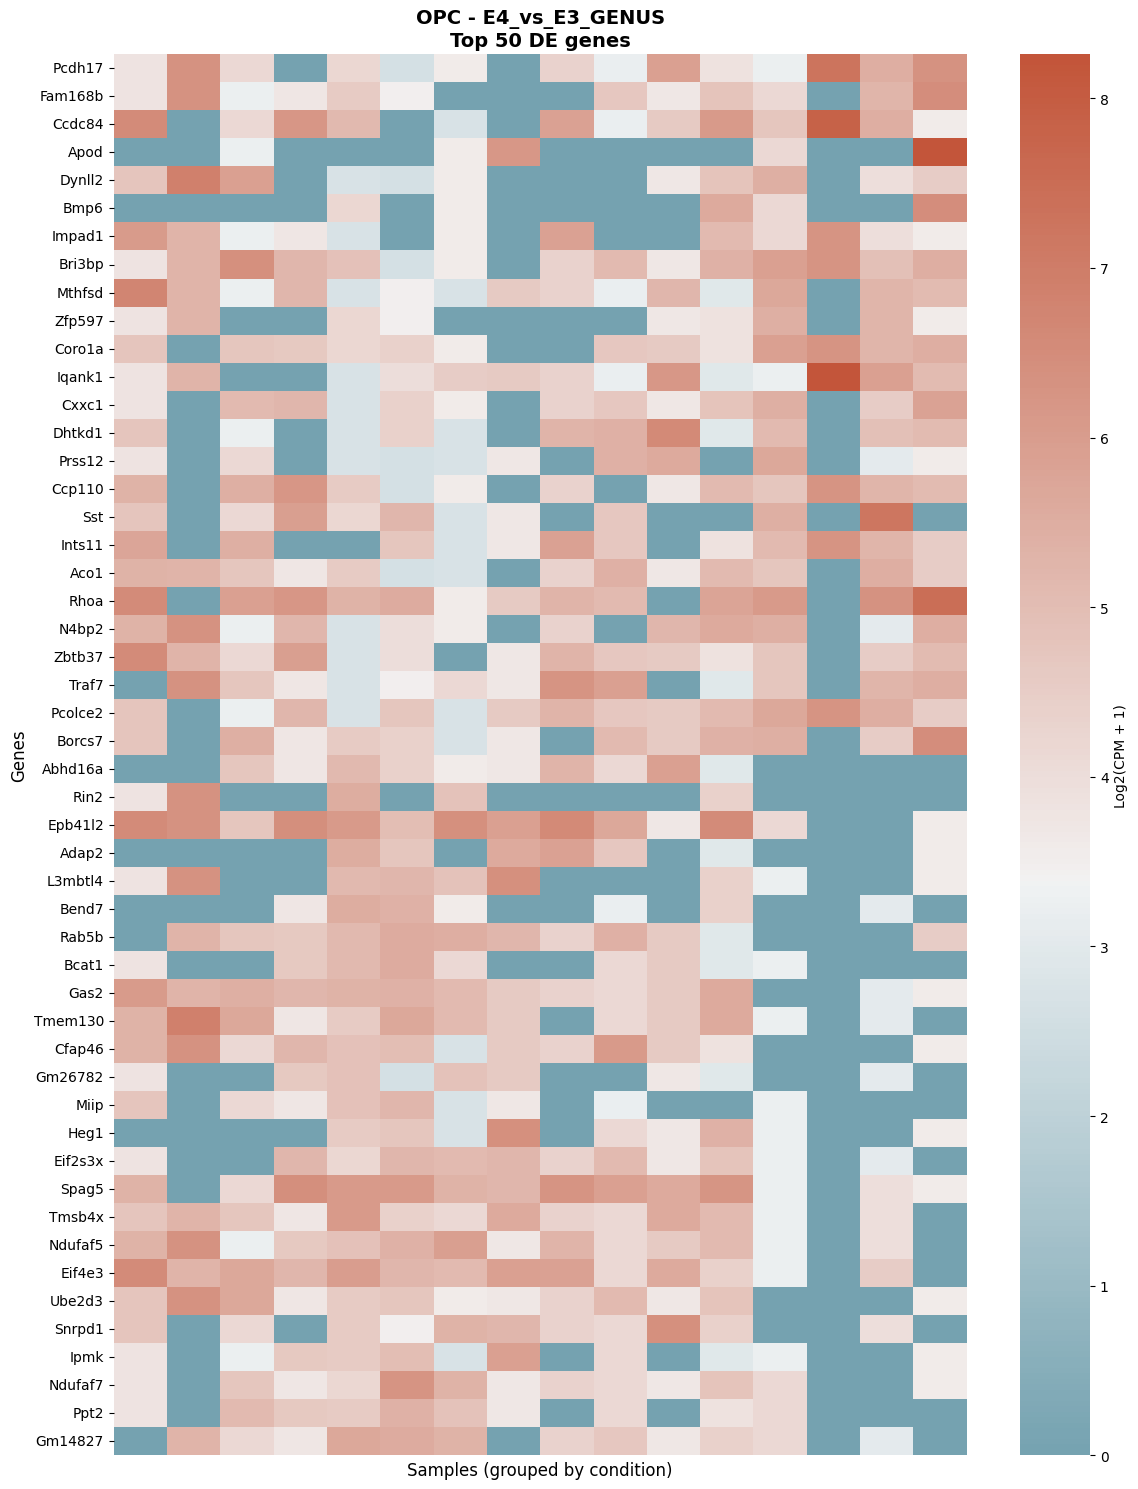

  Saved: plots/differential_expression/heatmap_ExN_L6b_E3_GENUS_vs_Ctrl.png


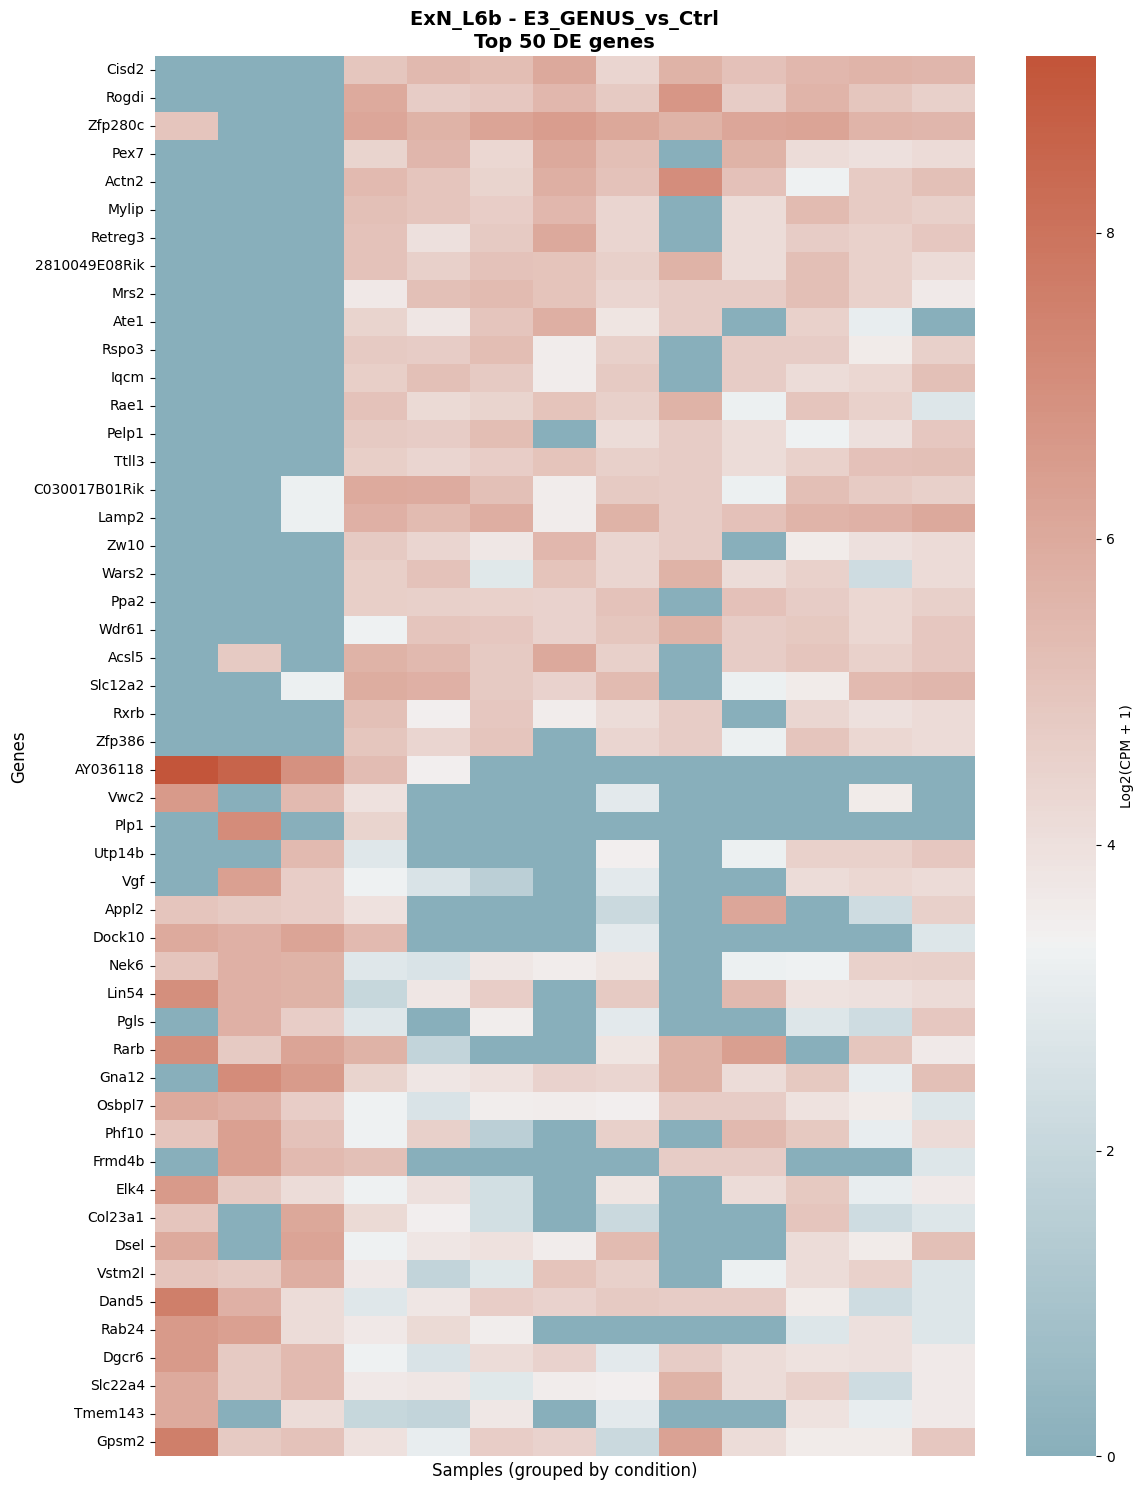

  Saved: plots/differential_expression/heatmap_ExN_L6b_E4_GENUS_vs_Ctrl.png


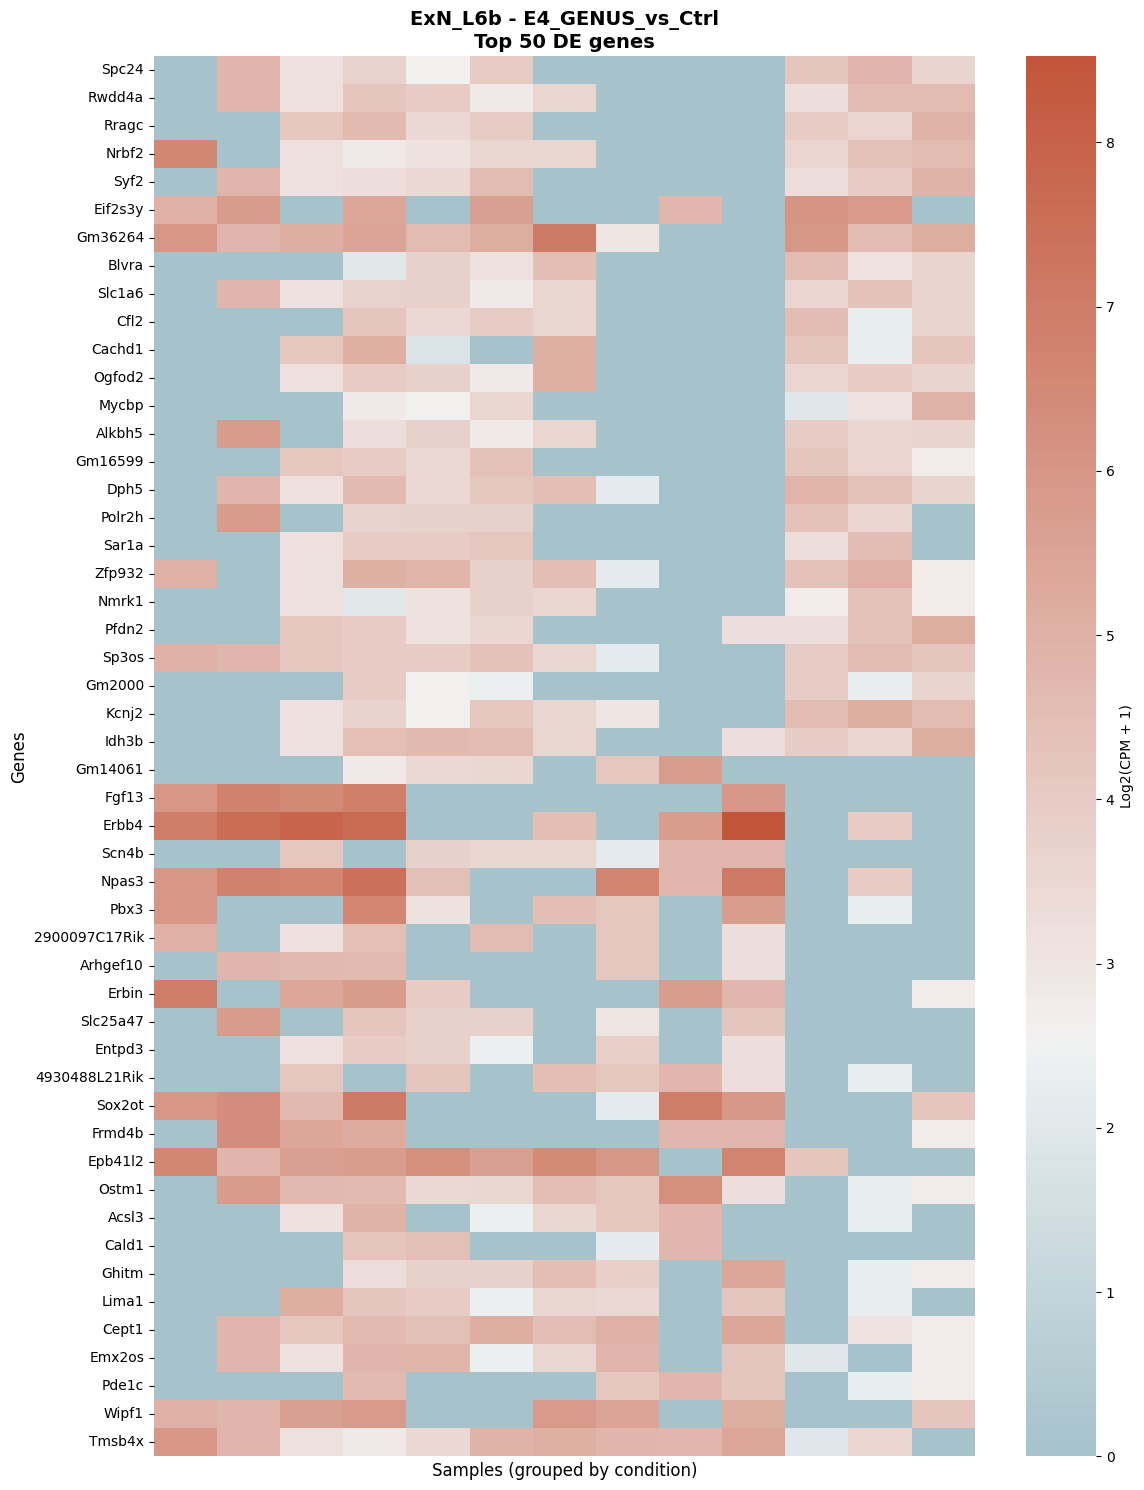

  Saved: plots/differential_expression/heatmap_ExN_L6b_E4_vs_E3_Ctrl.png


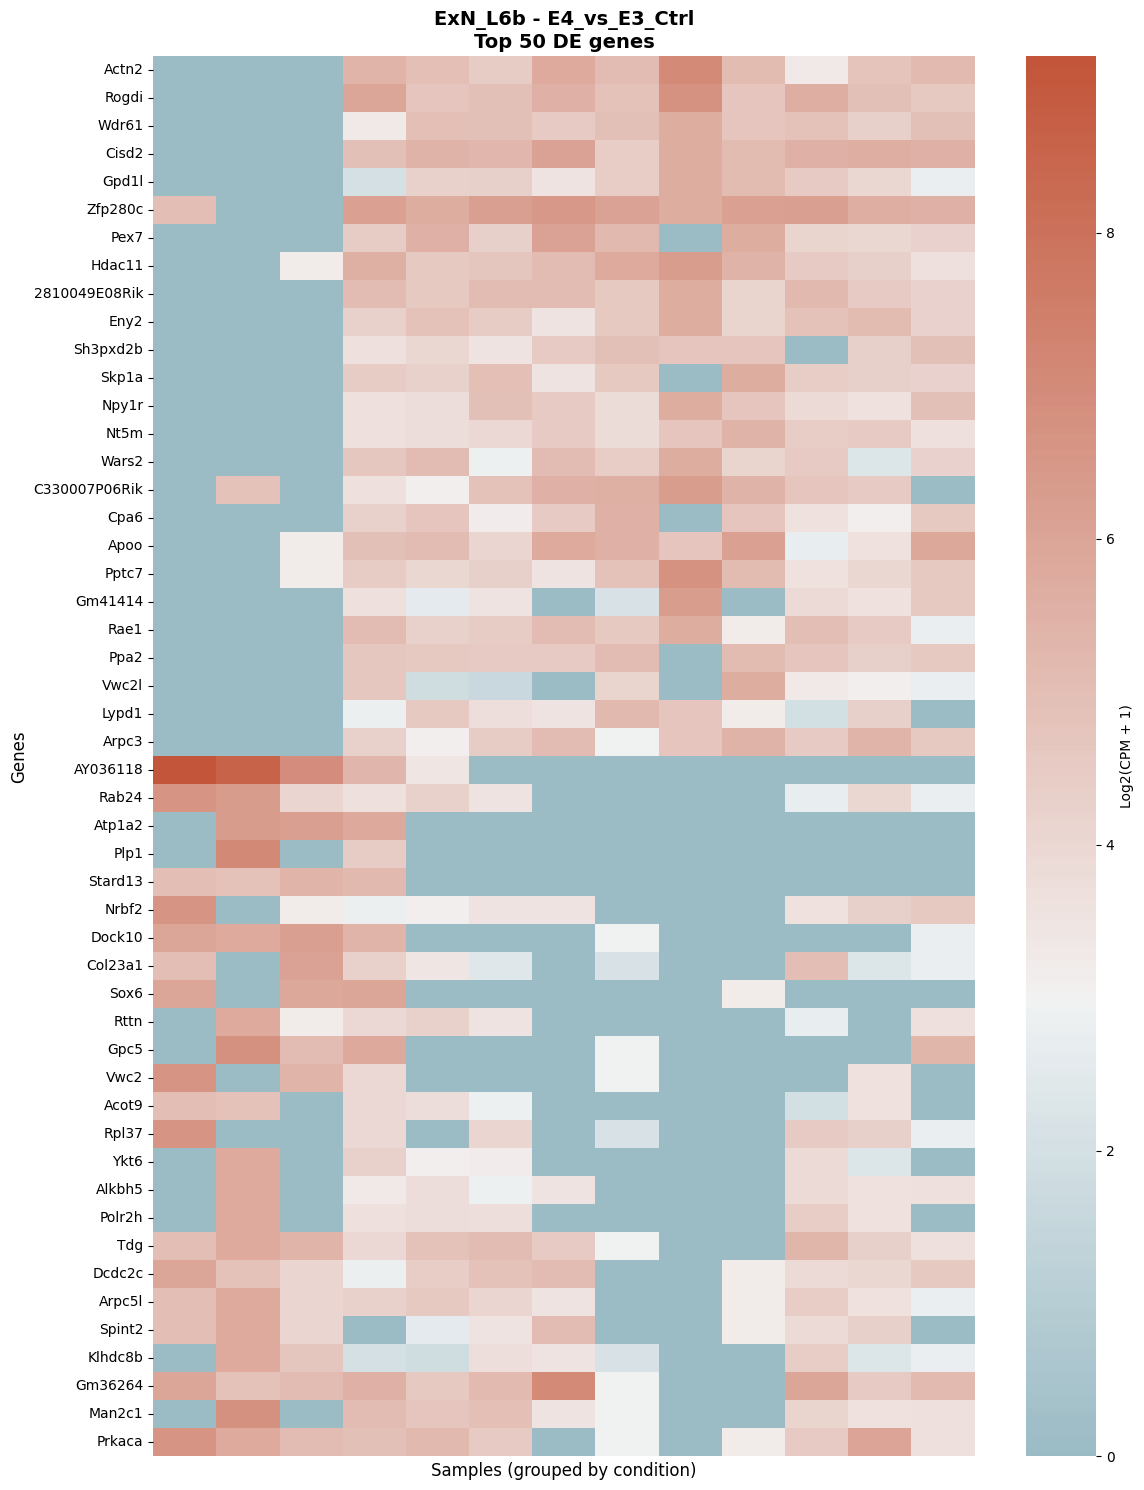

  Saved: plots/differential_expression/heatmap_ExN_L6b_E4_vs_E3_GENUS.png


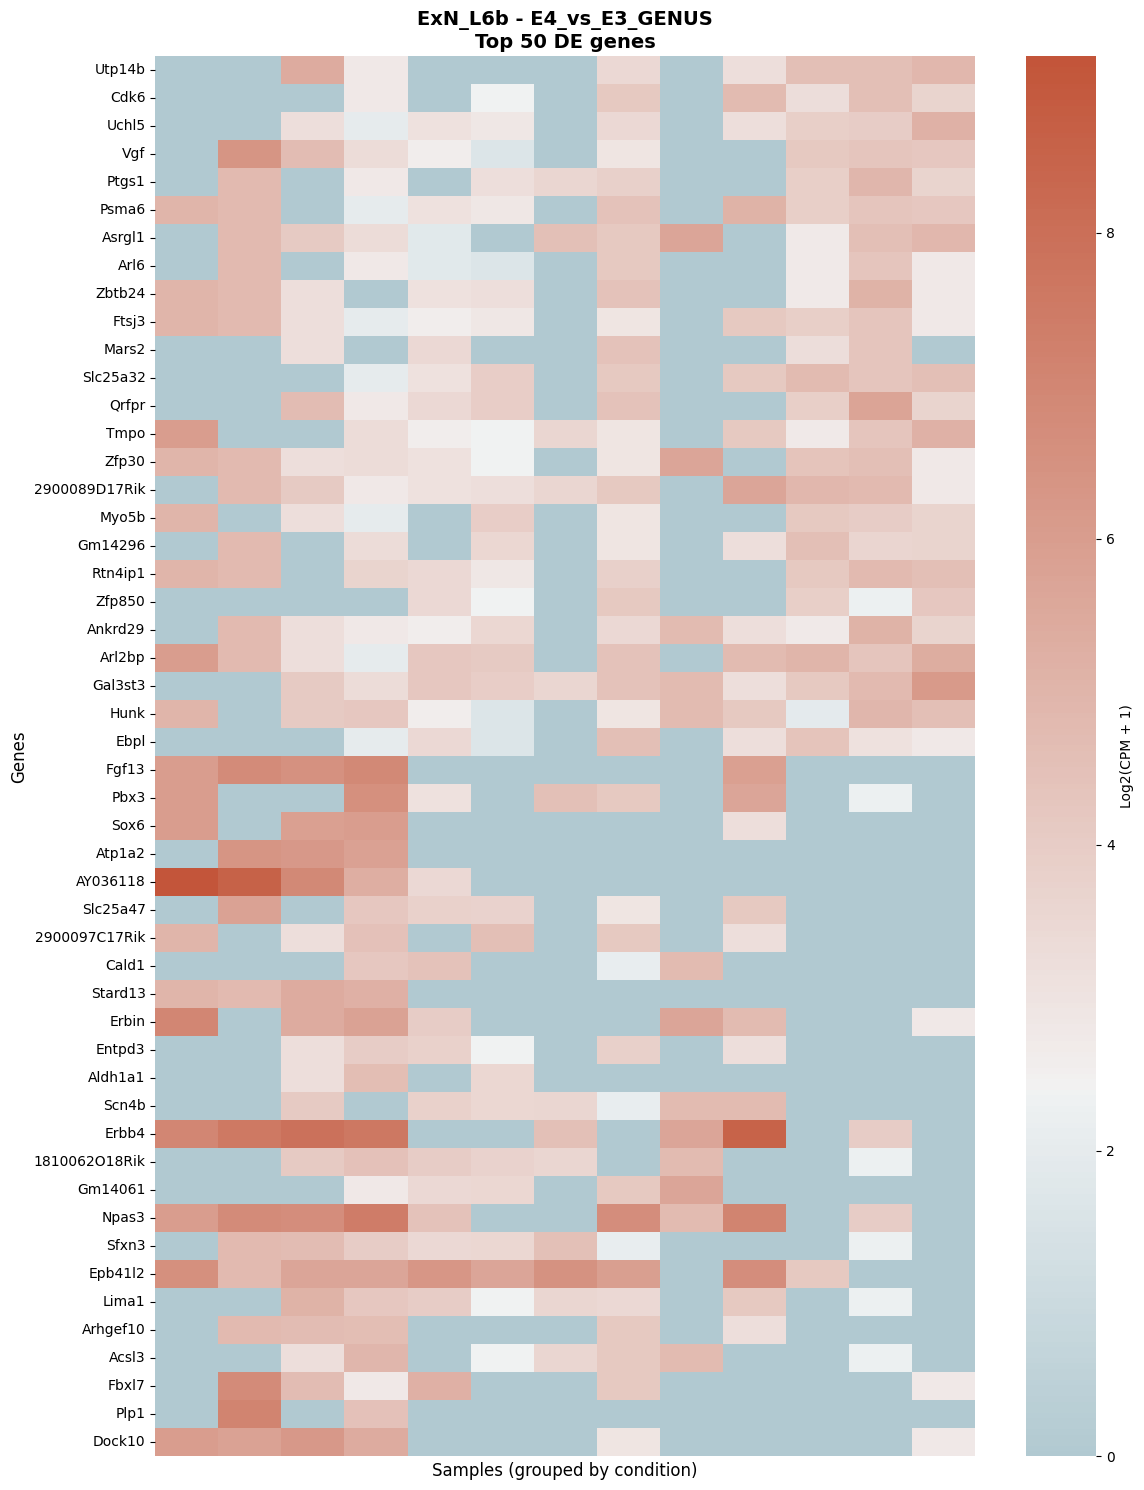

  Saved: plots/differential_expression/heatmap_InN_PVALB_E3_GENUS_vs_Ctrl.png


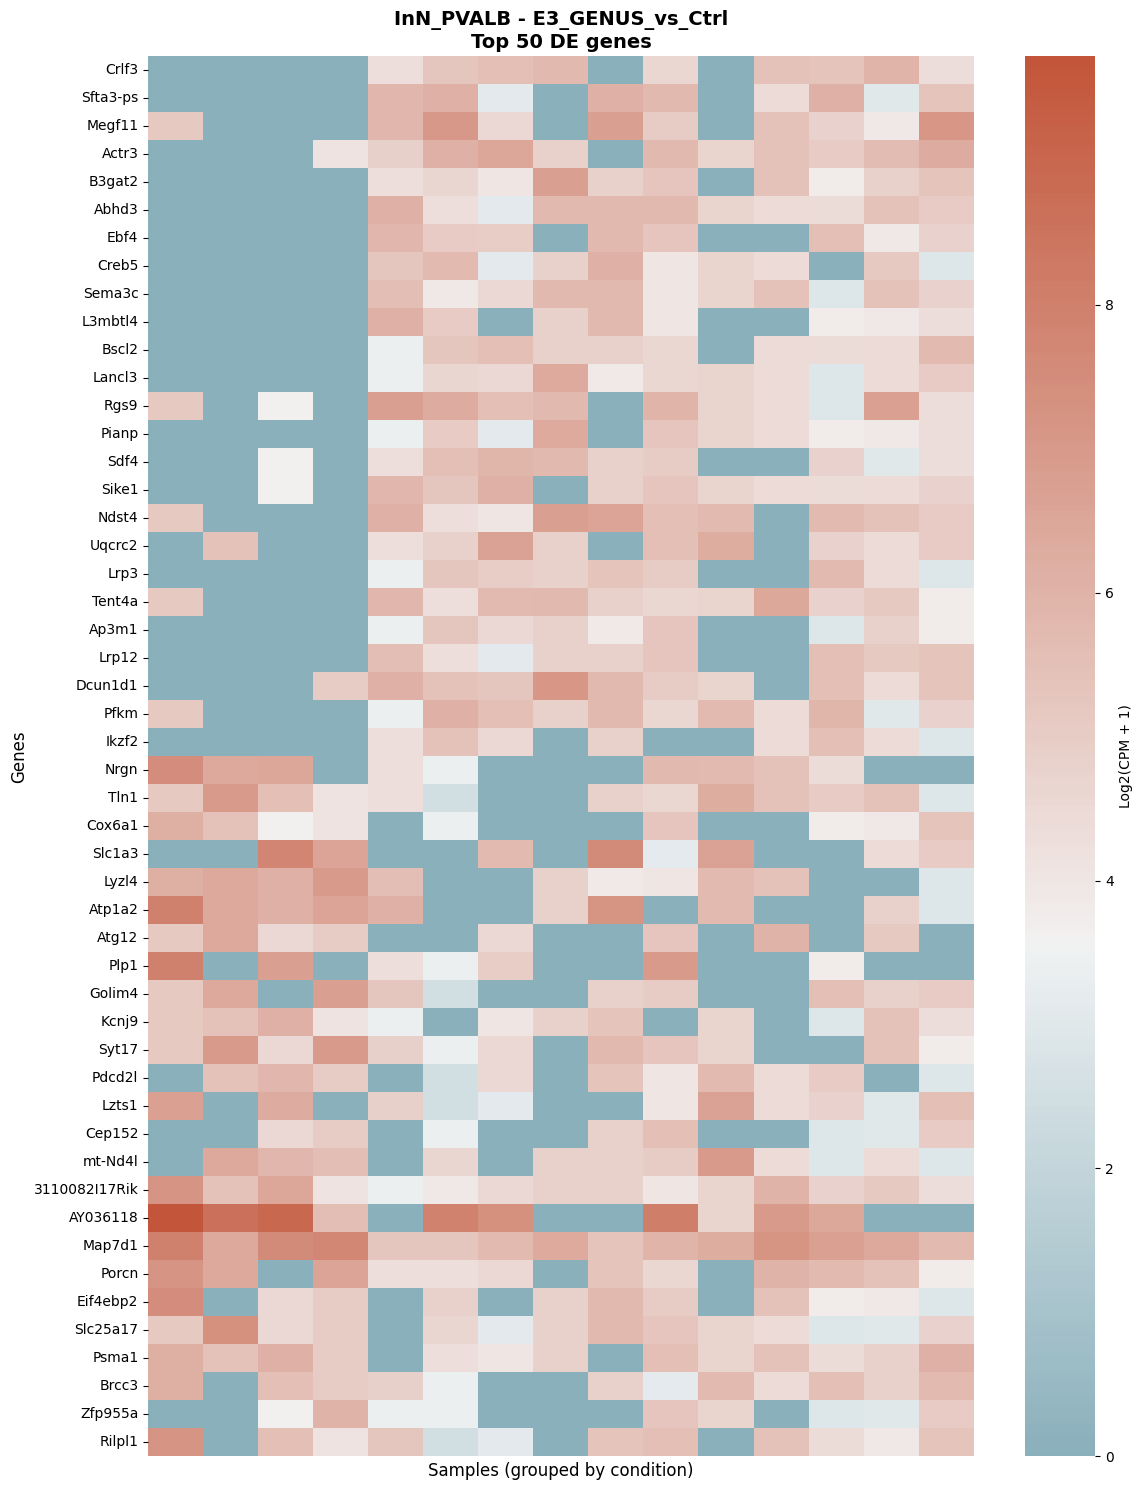

  Saved: plots/differential_expression/heatmap_InN_PVALB_E4_GENUS_vs_Ctrl.png


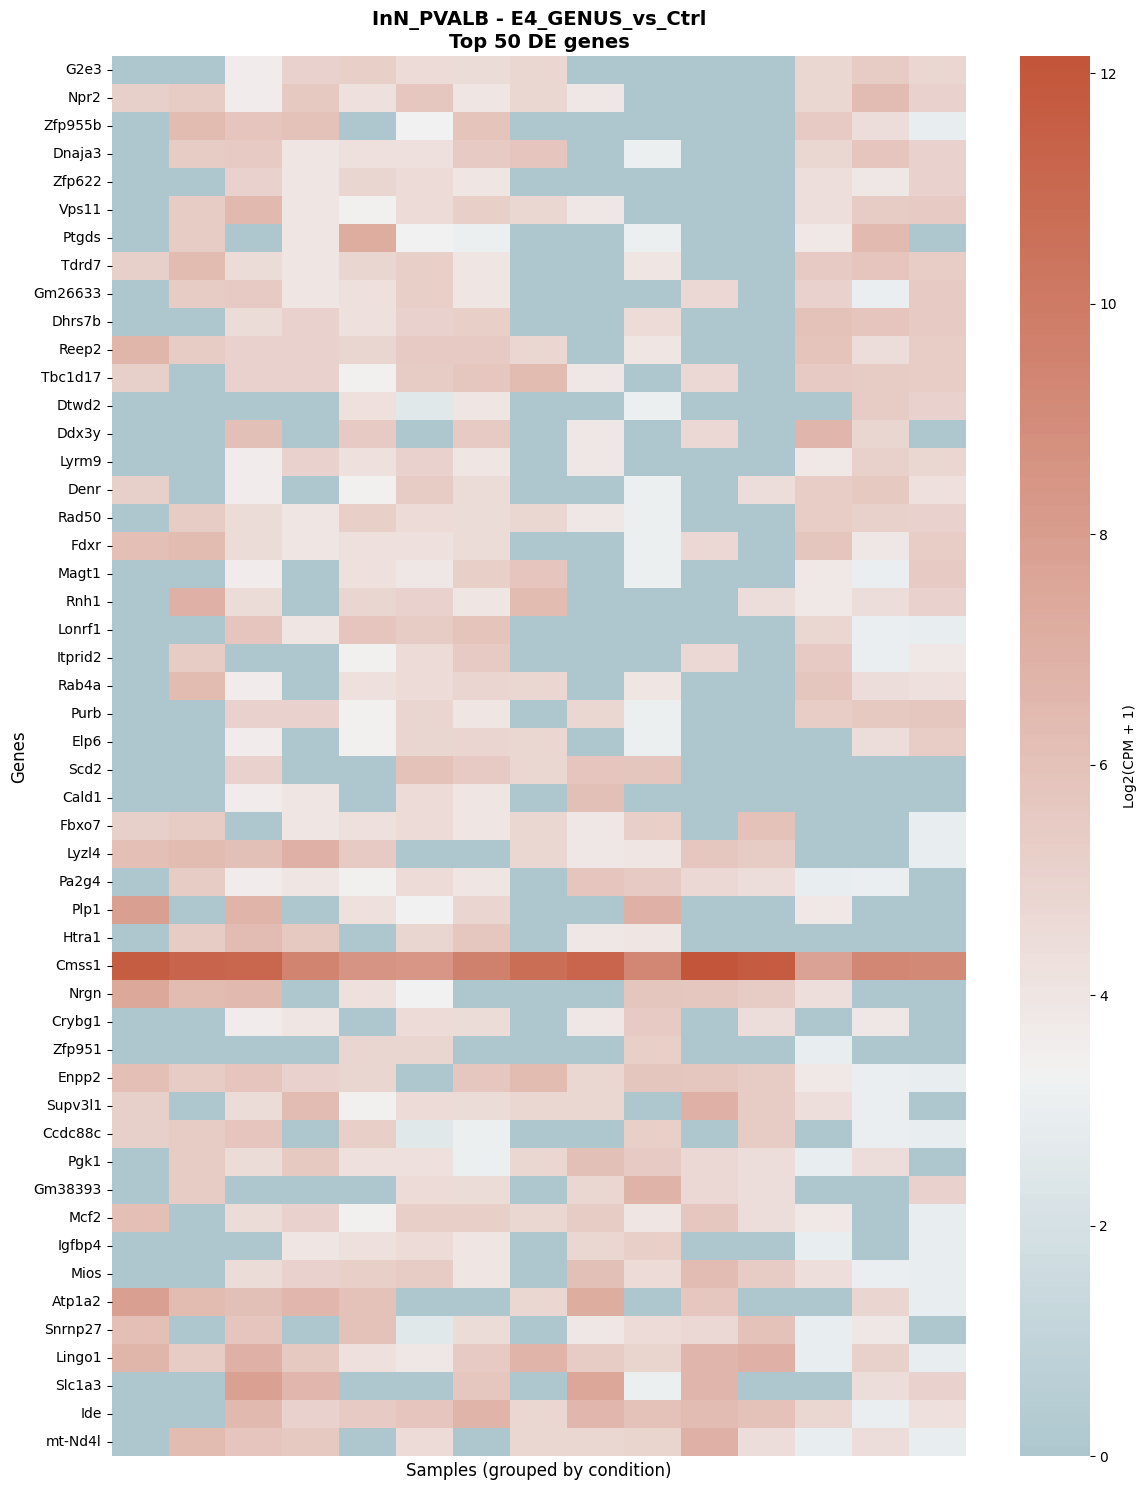

  Saved: plots/differential_expression/heatmap_InN_PVALB_E4_vs_E3_Ctrl.png


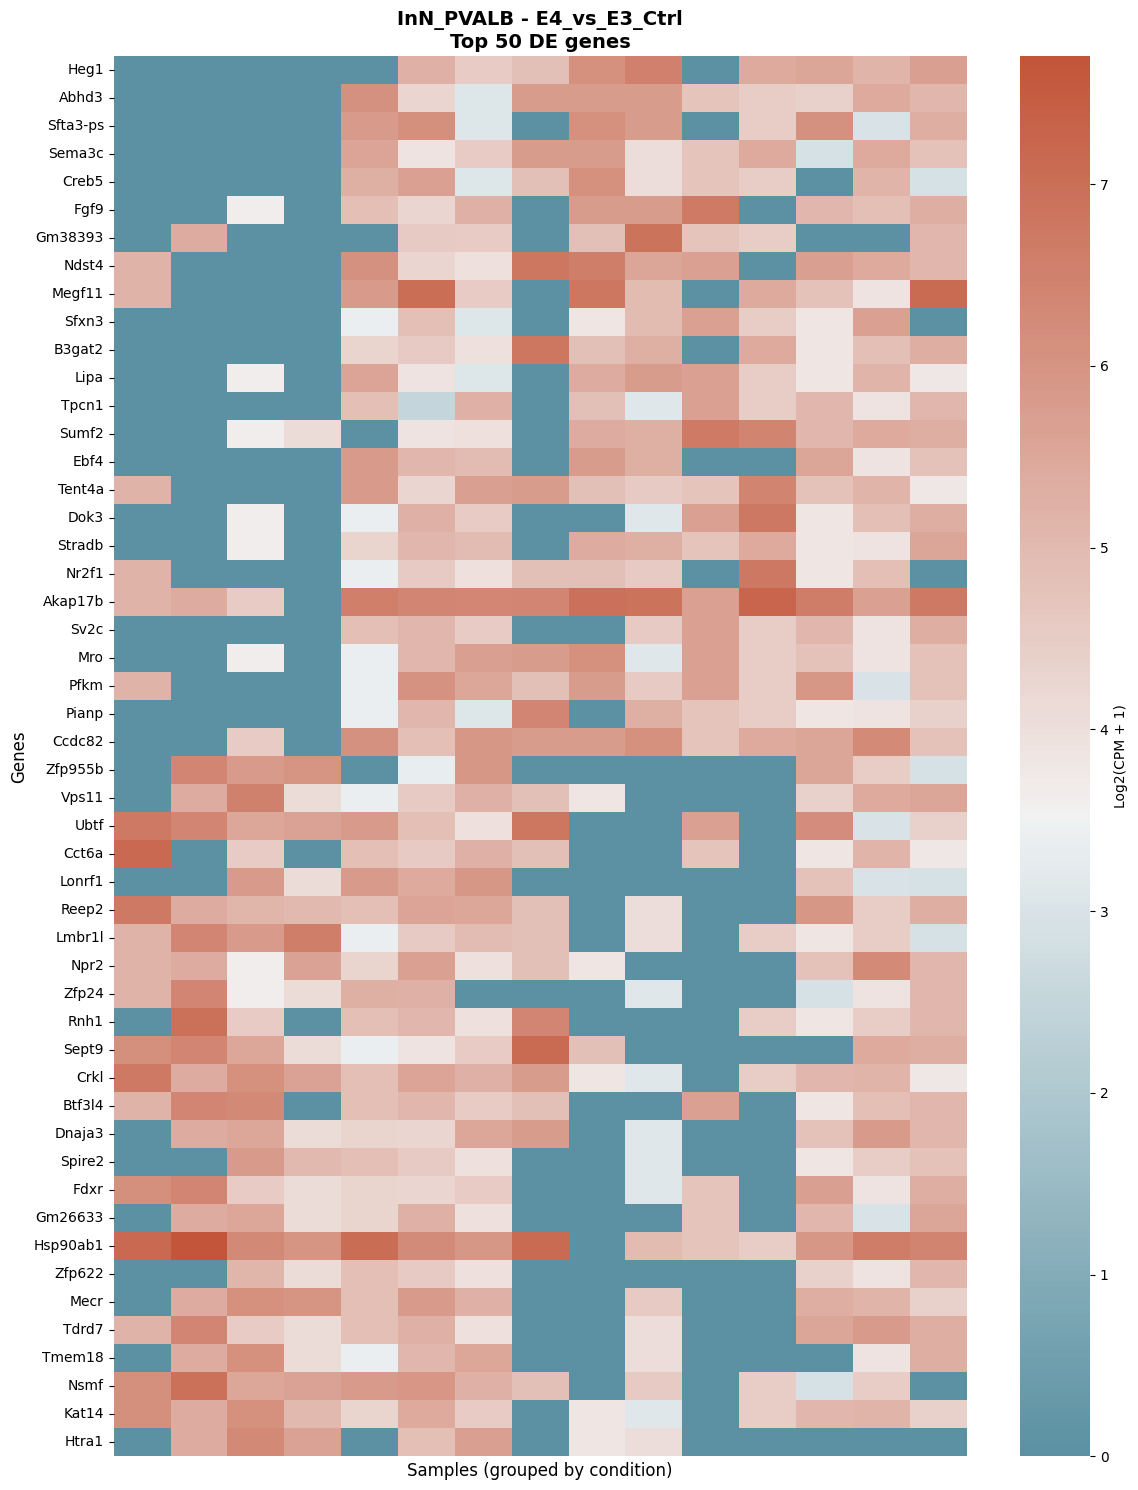

  Saved: plots/differential_expression/heatmap_InN_PVALB_E4_vs_E3_GENUS.png


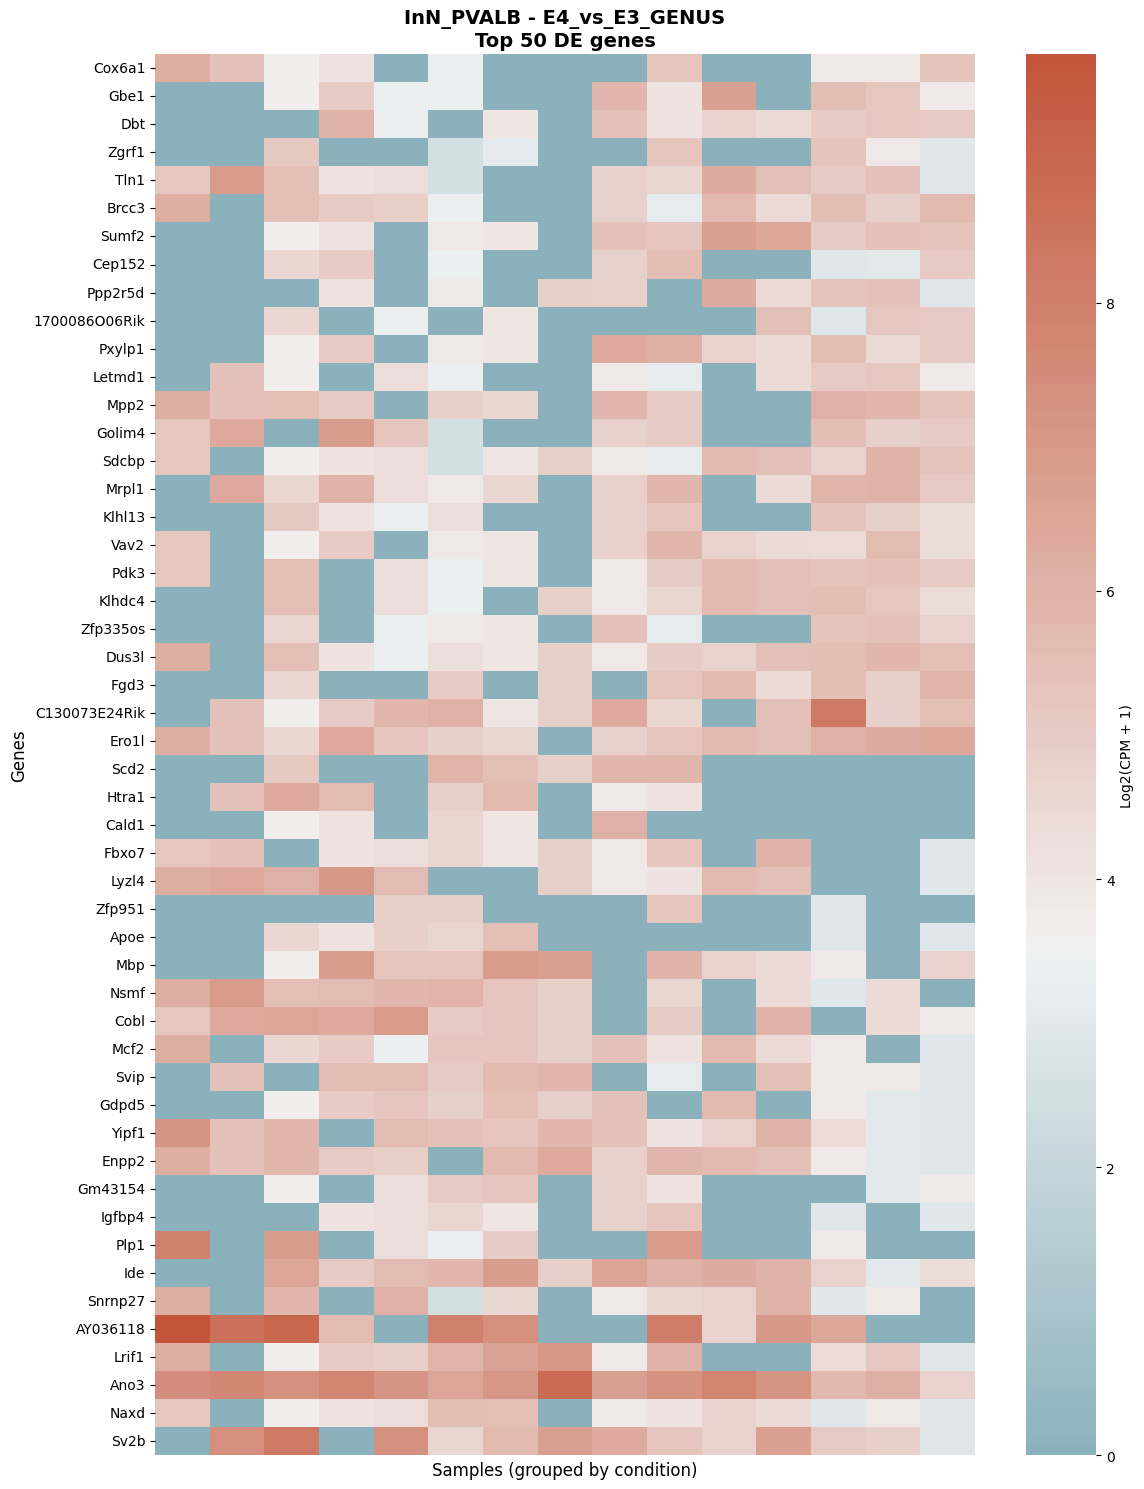

  Saved: plots/differential_expression/heatmap_Astro_E3_GENUS_vs_Ctrl.png


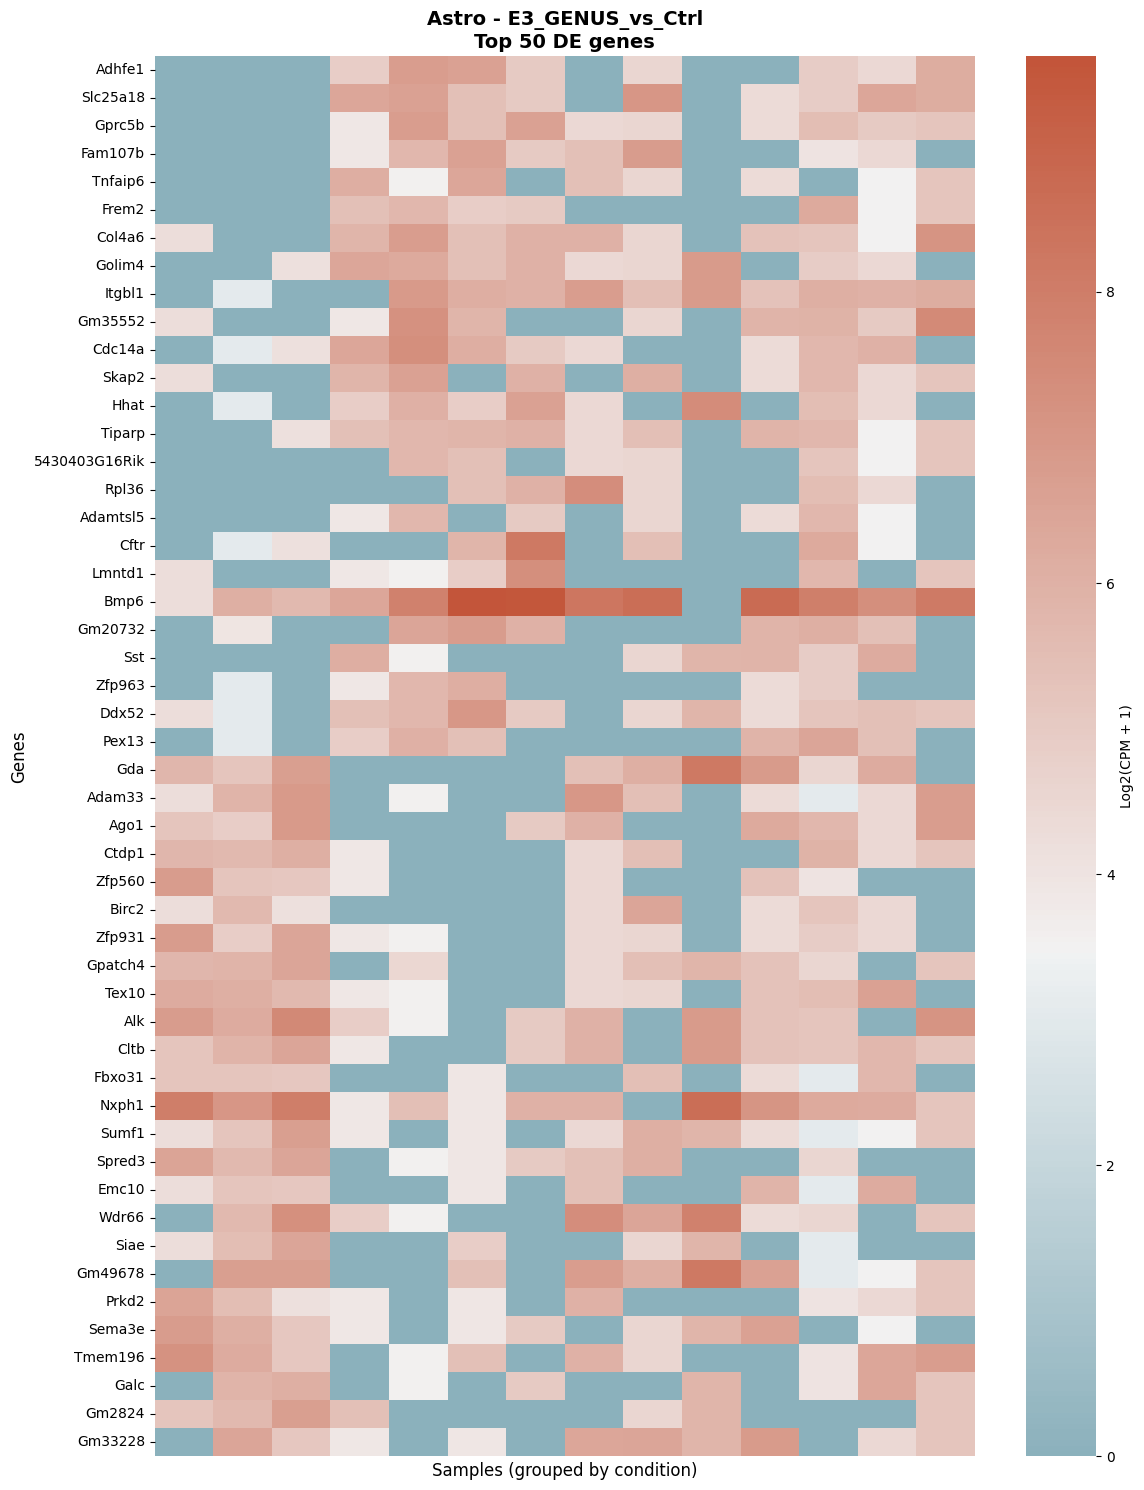

  Saved: plots/differential_expression/heatmap_Astro_E4_GENUS_vs_Ctrl.png


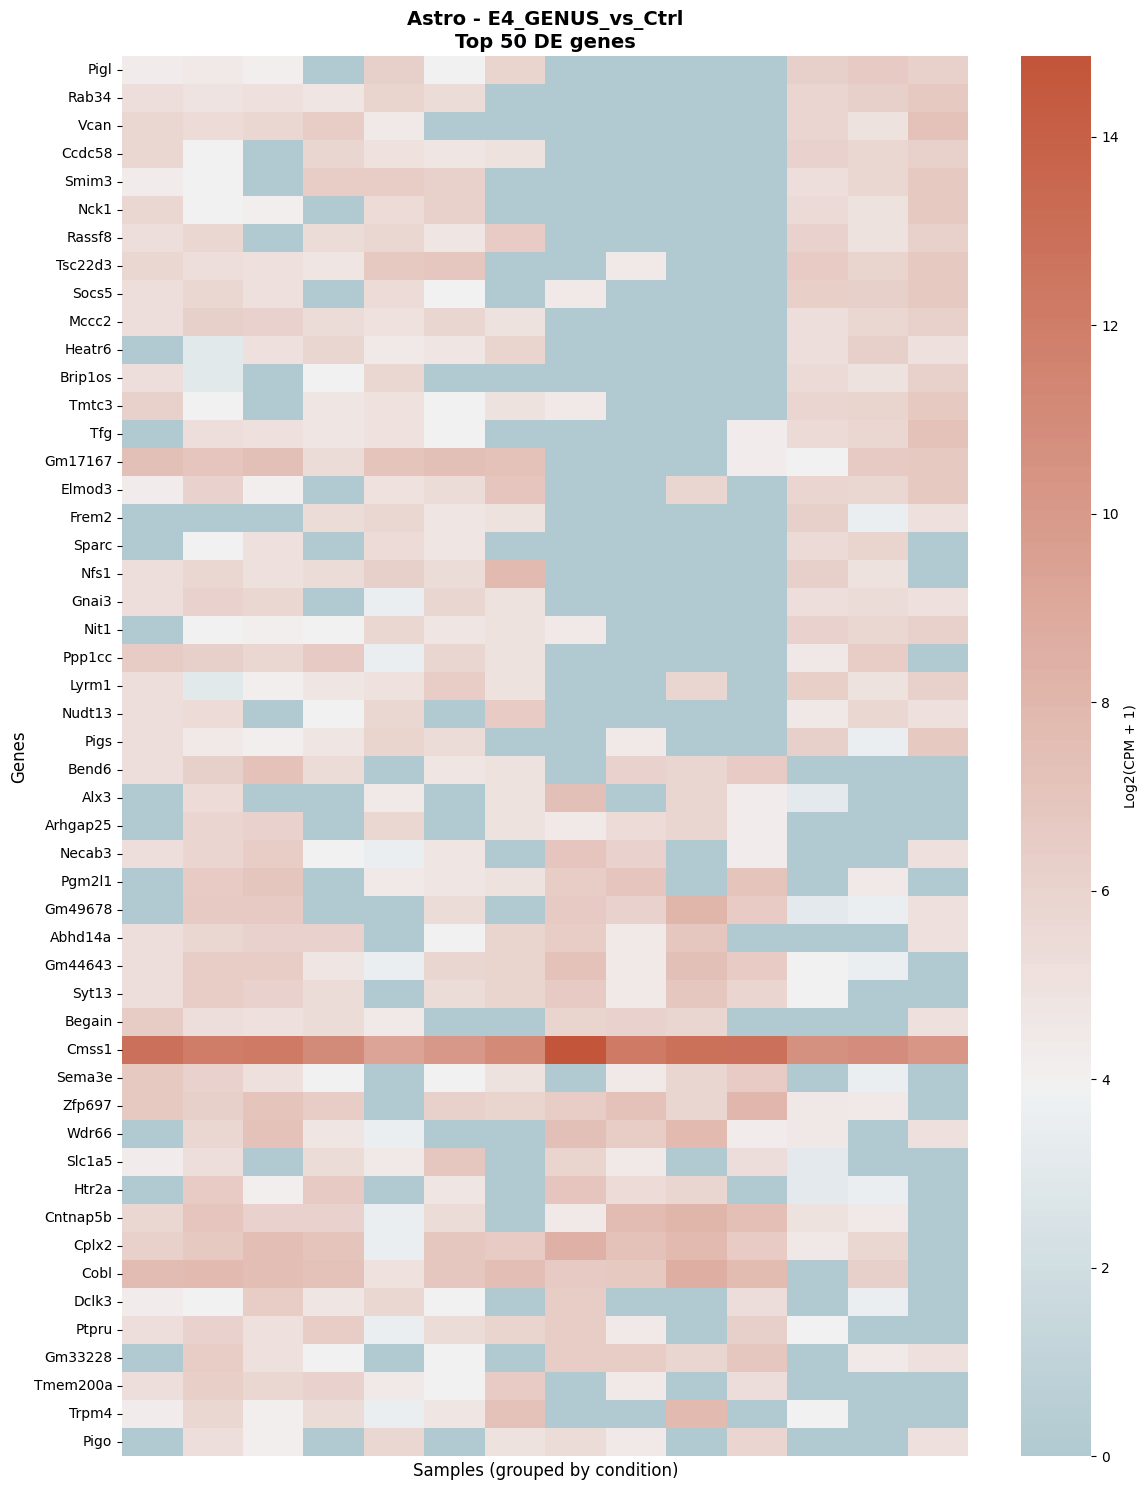

  Saved: plots/differential_expression/heatmap_Astro_E4_vs_E3_Ctrl.png


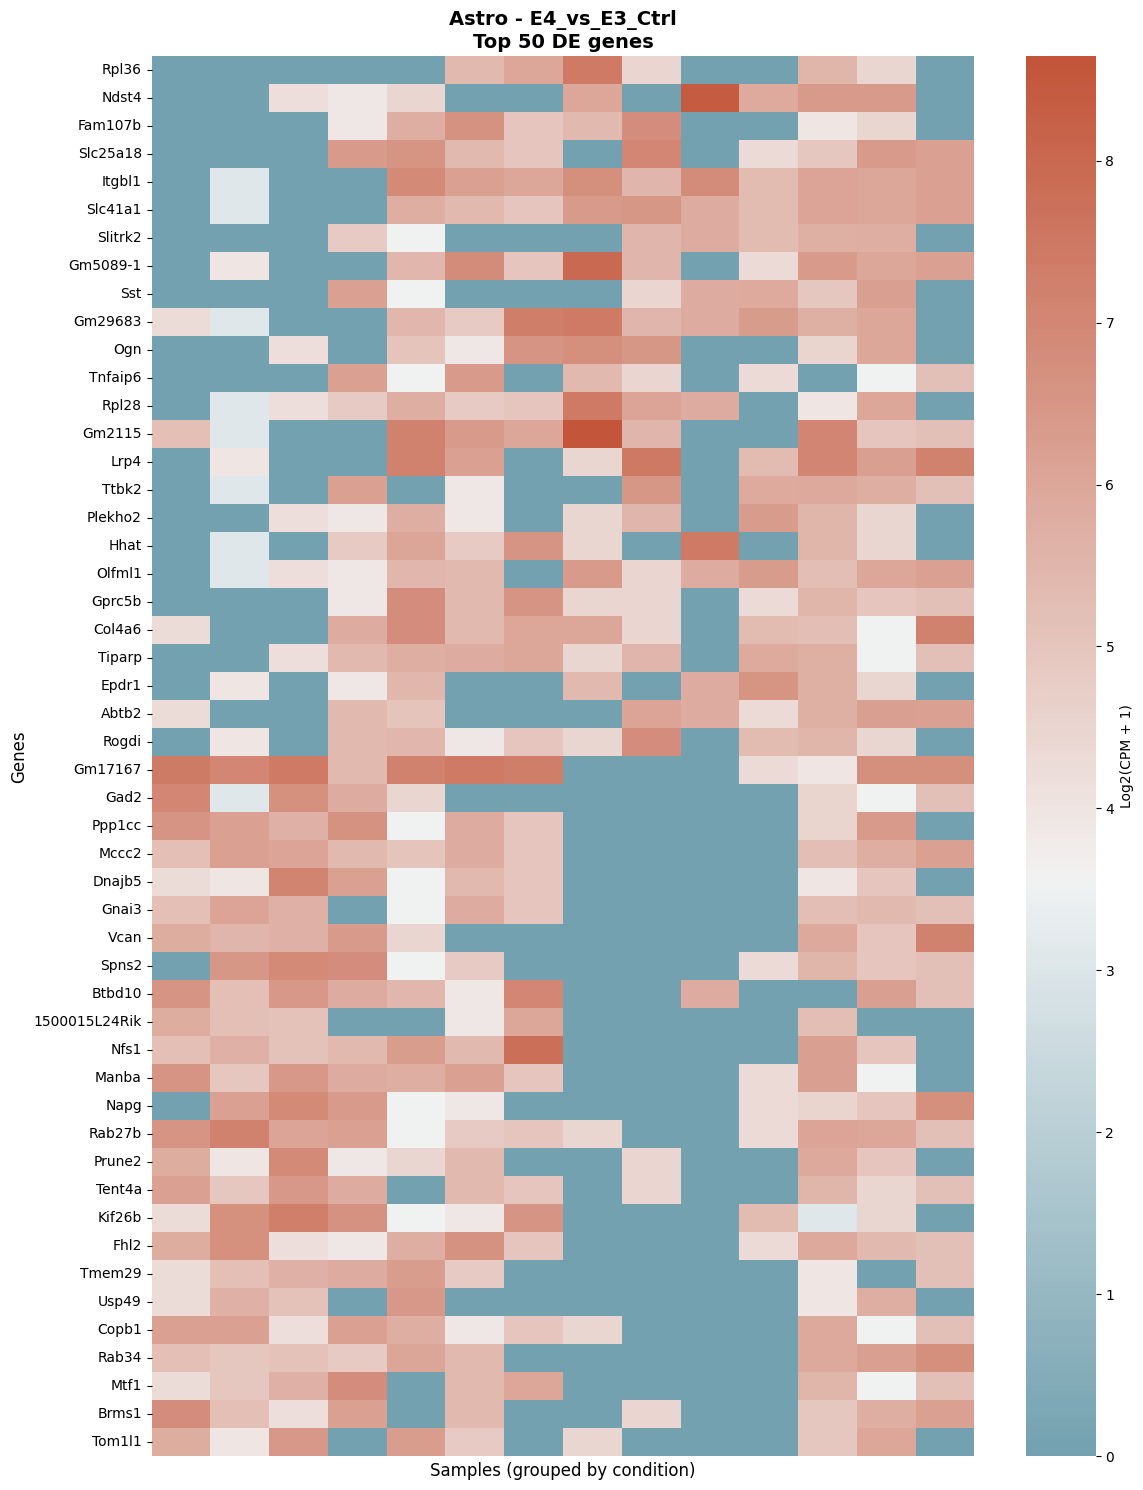

  Saved: plots/differential_expression/heatmap_Astro_E4_vs_E3_GENUS.png


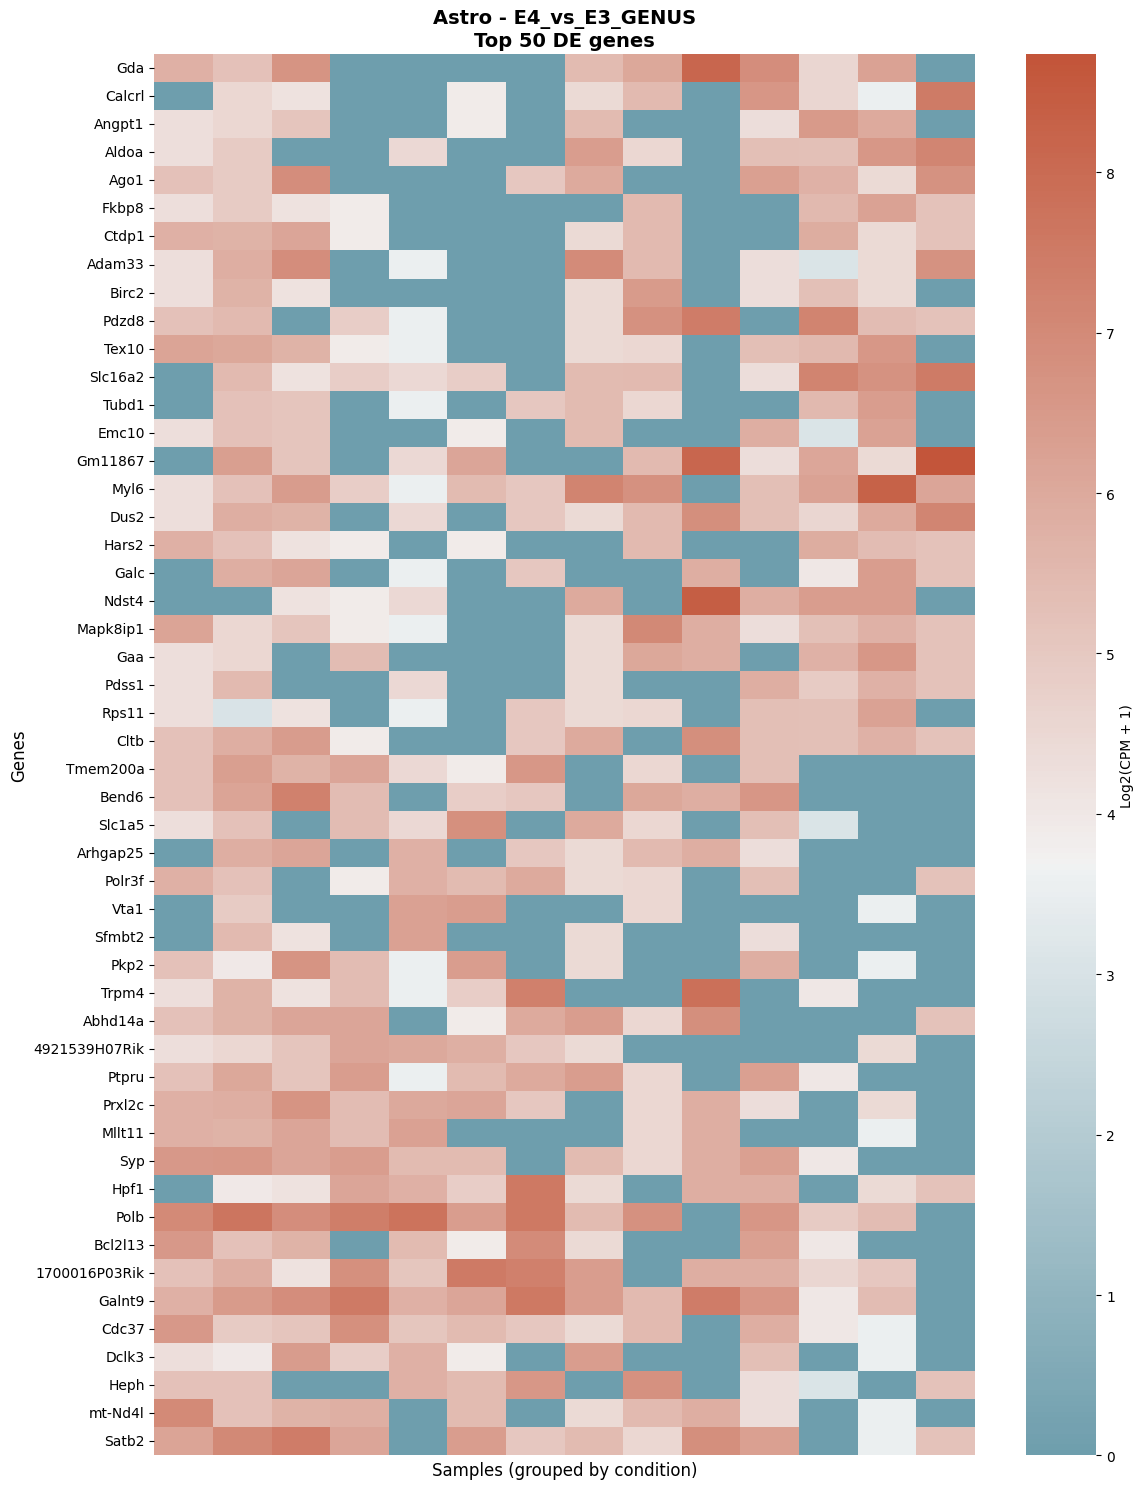

  Saved: plots/differential_expression/heatmap_Inhib_E3_GENUS_vs_Ctrl.png


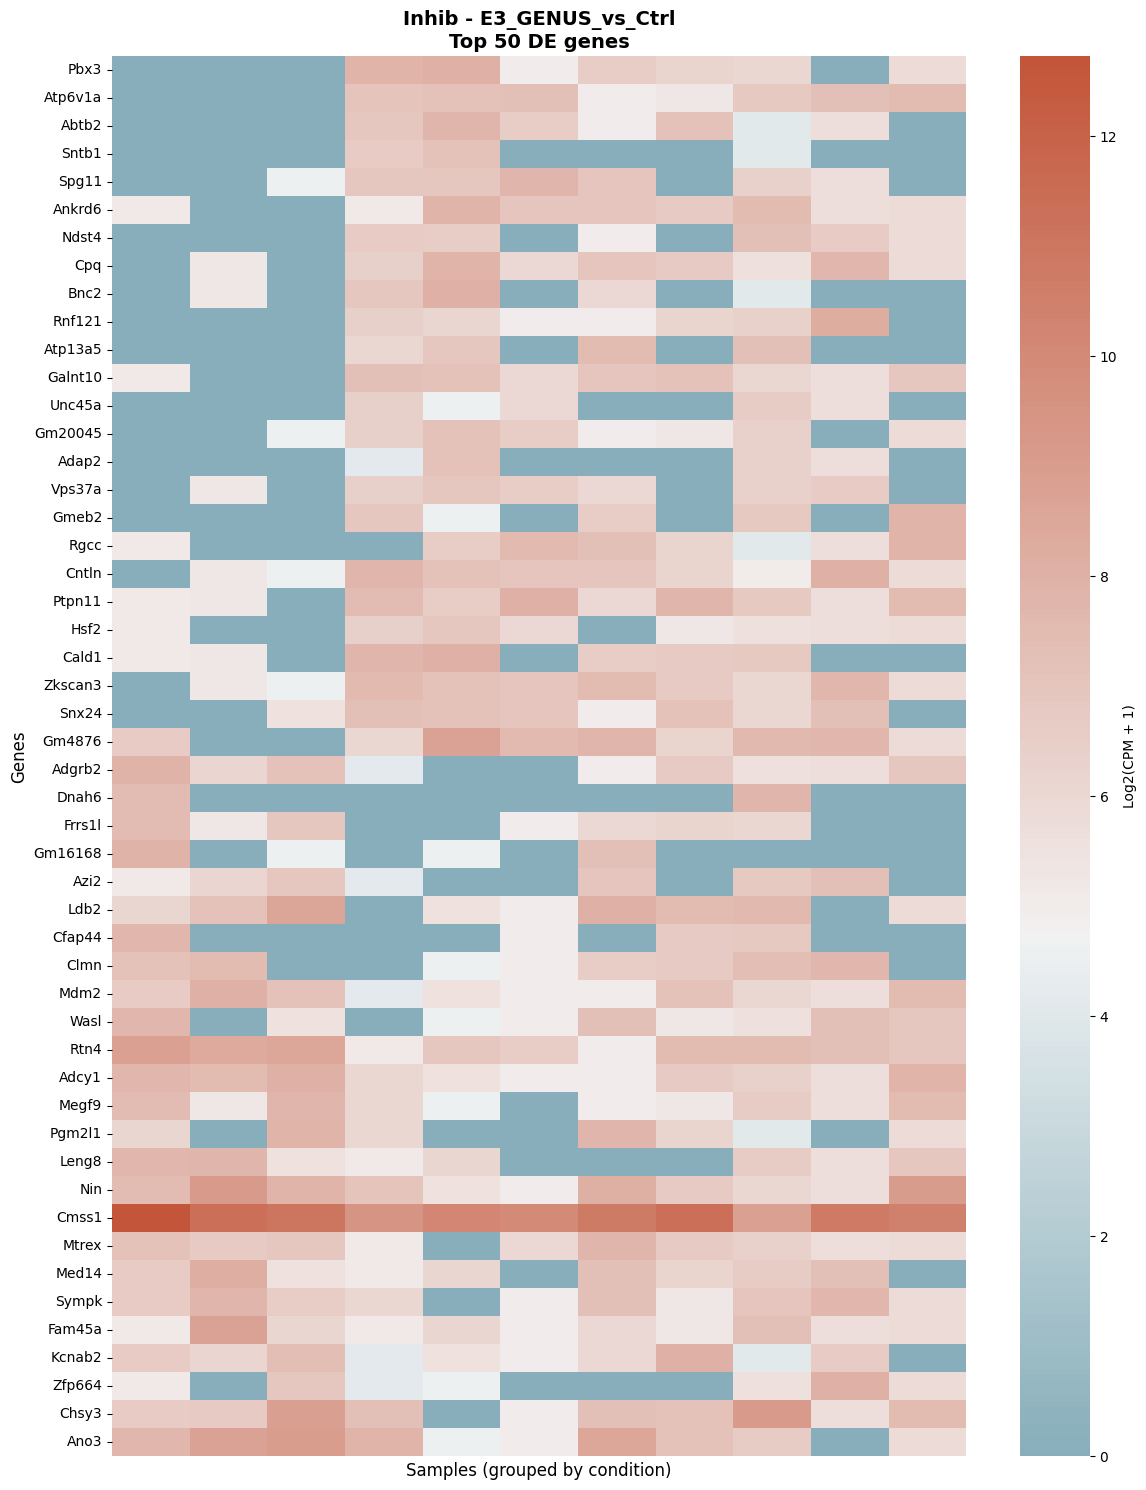

  Saved: plots/differential_expression/heatmap_Inhib_E4_GENUS_vs_Ctrl.png


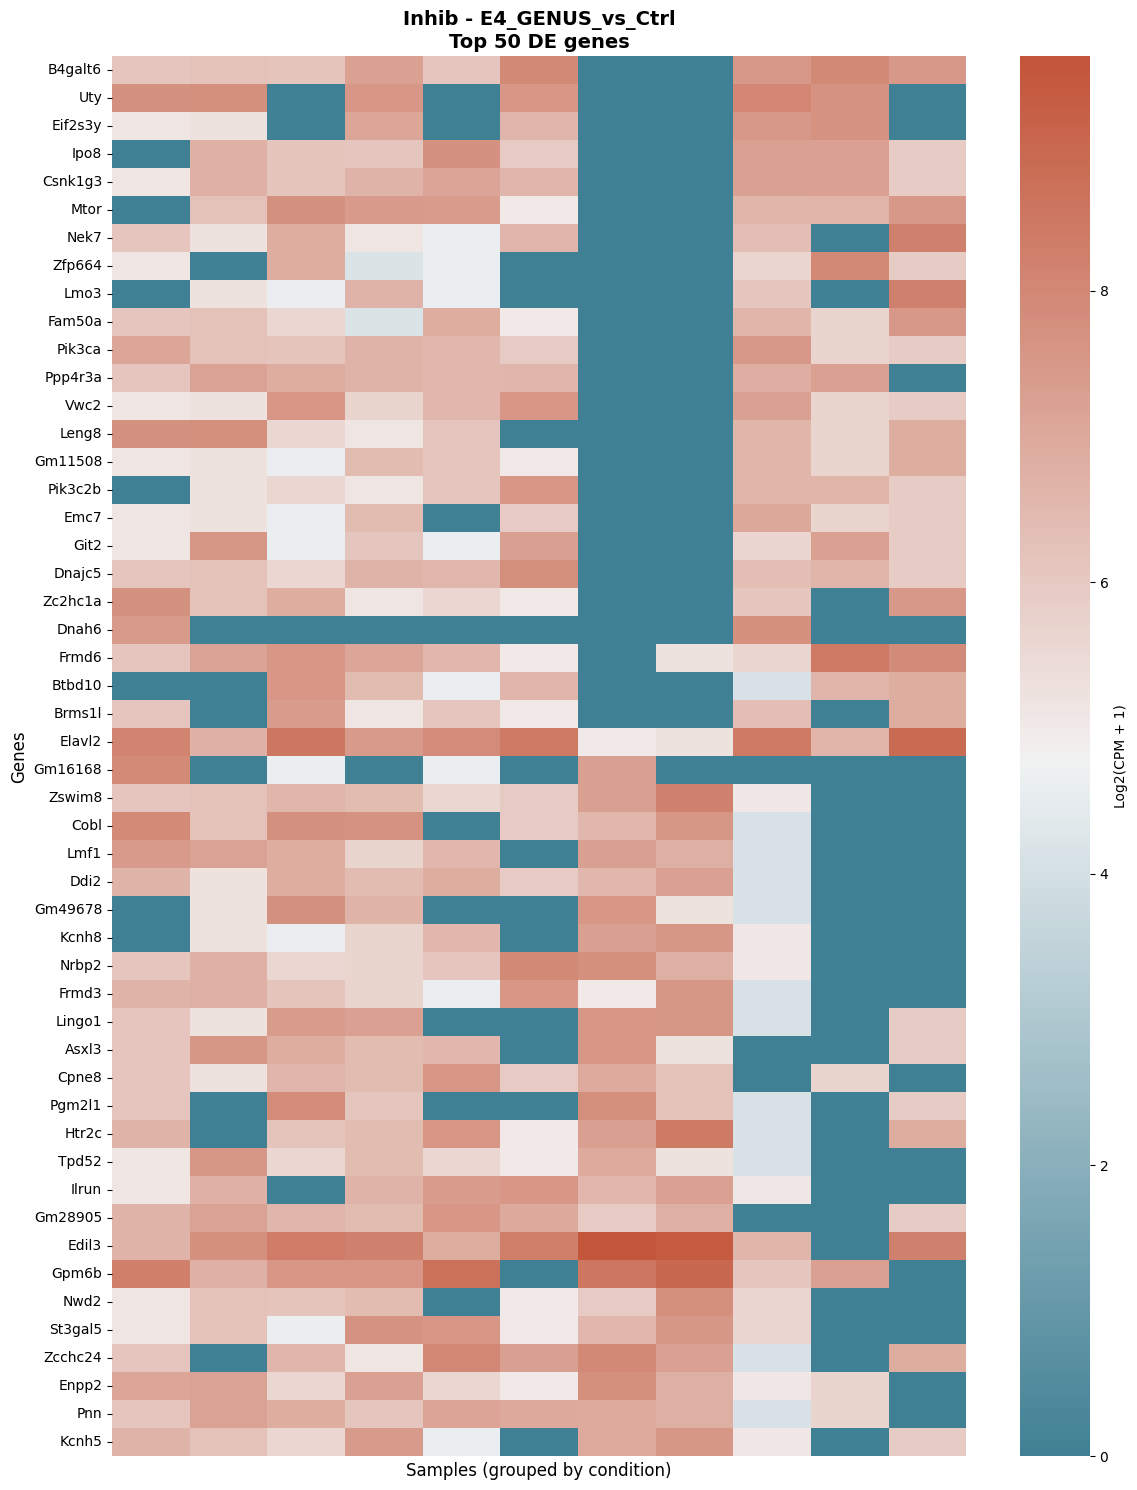

  Saved: plots/differential_expression/heatmap_Inhib_E4_vs_E3_Ctrl.png


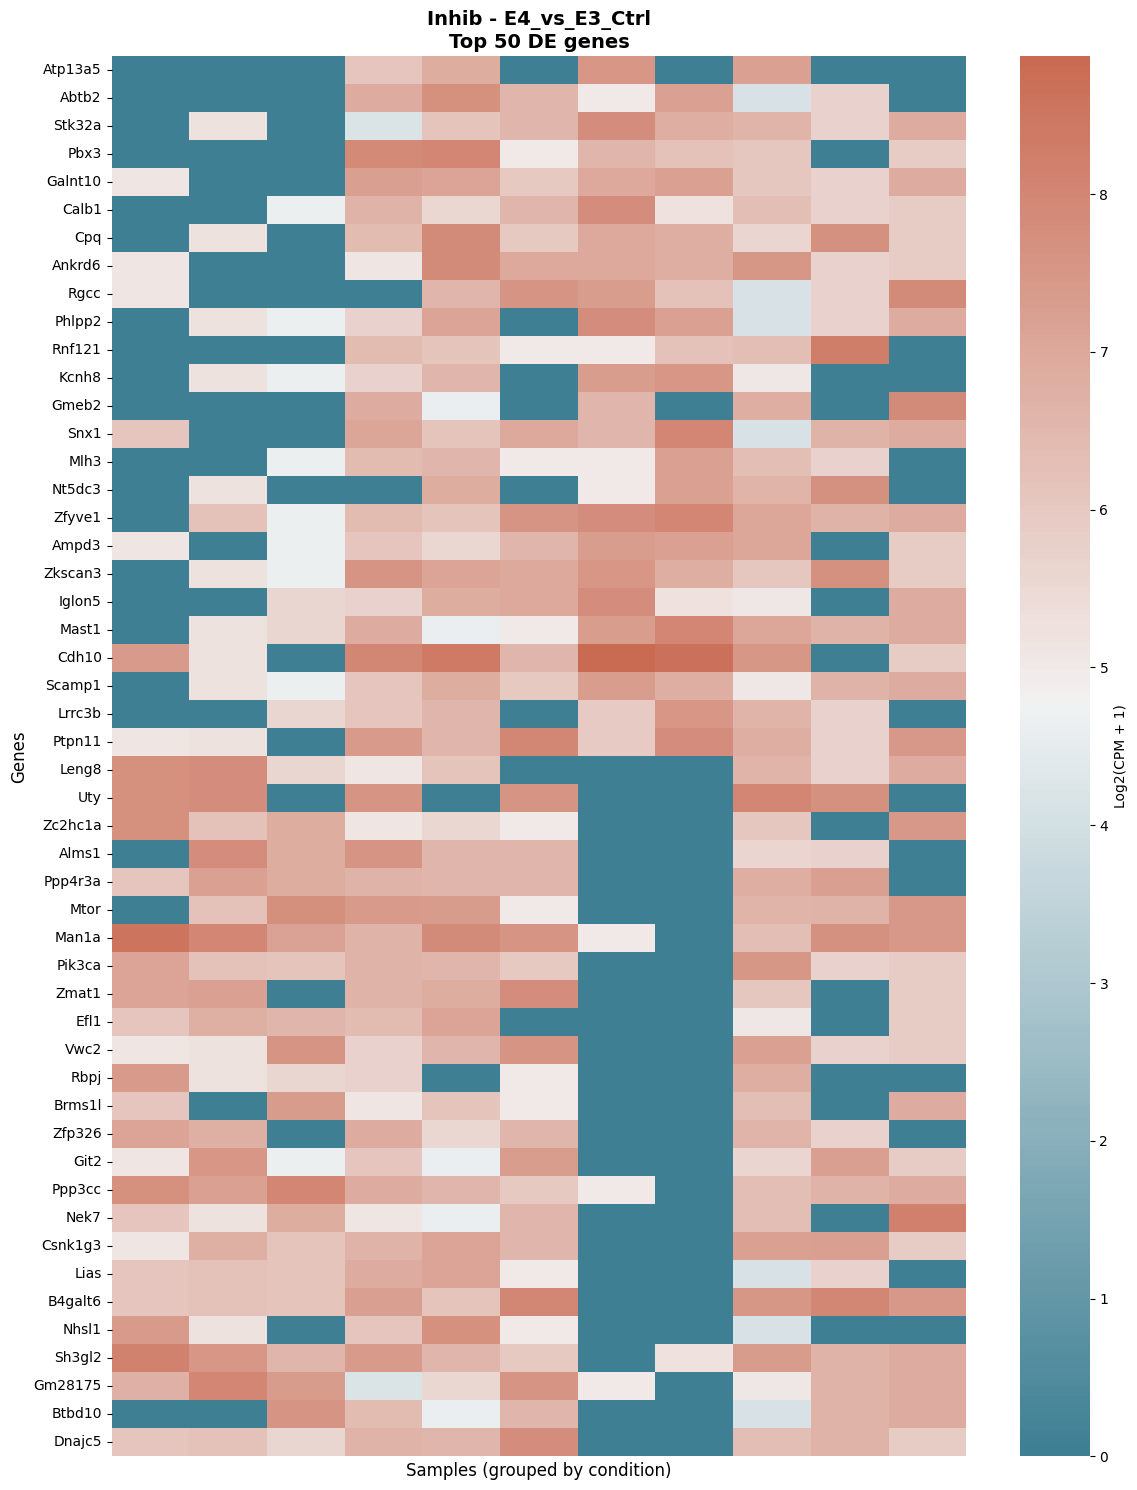

  Saved: plots/differential_expression/heatmap_Inhib_E4_vs_E3_GENUS.png


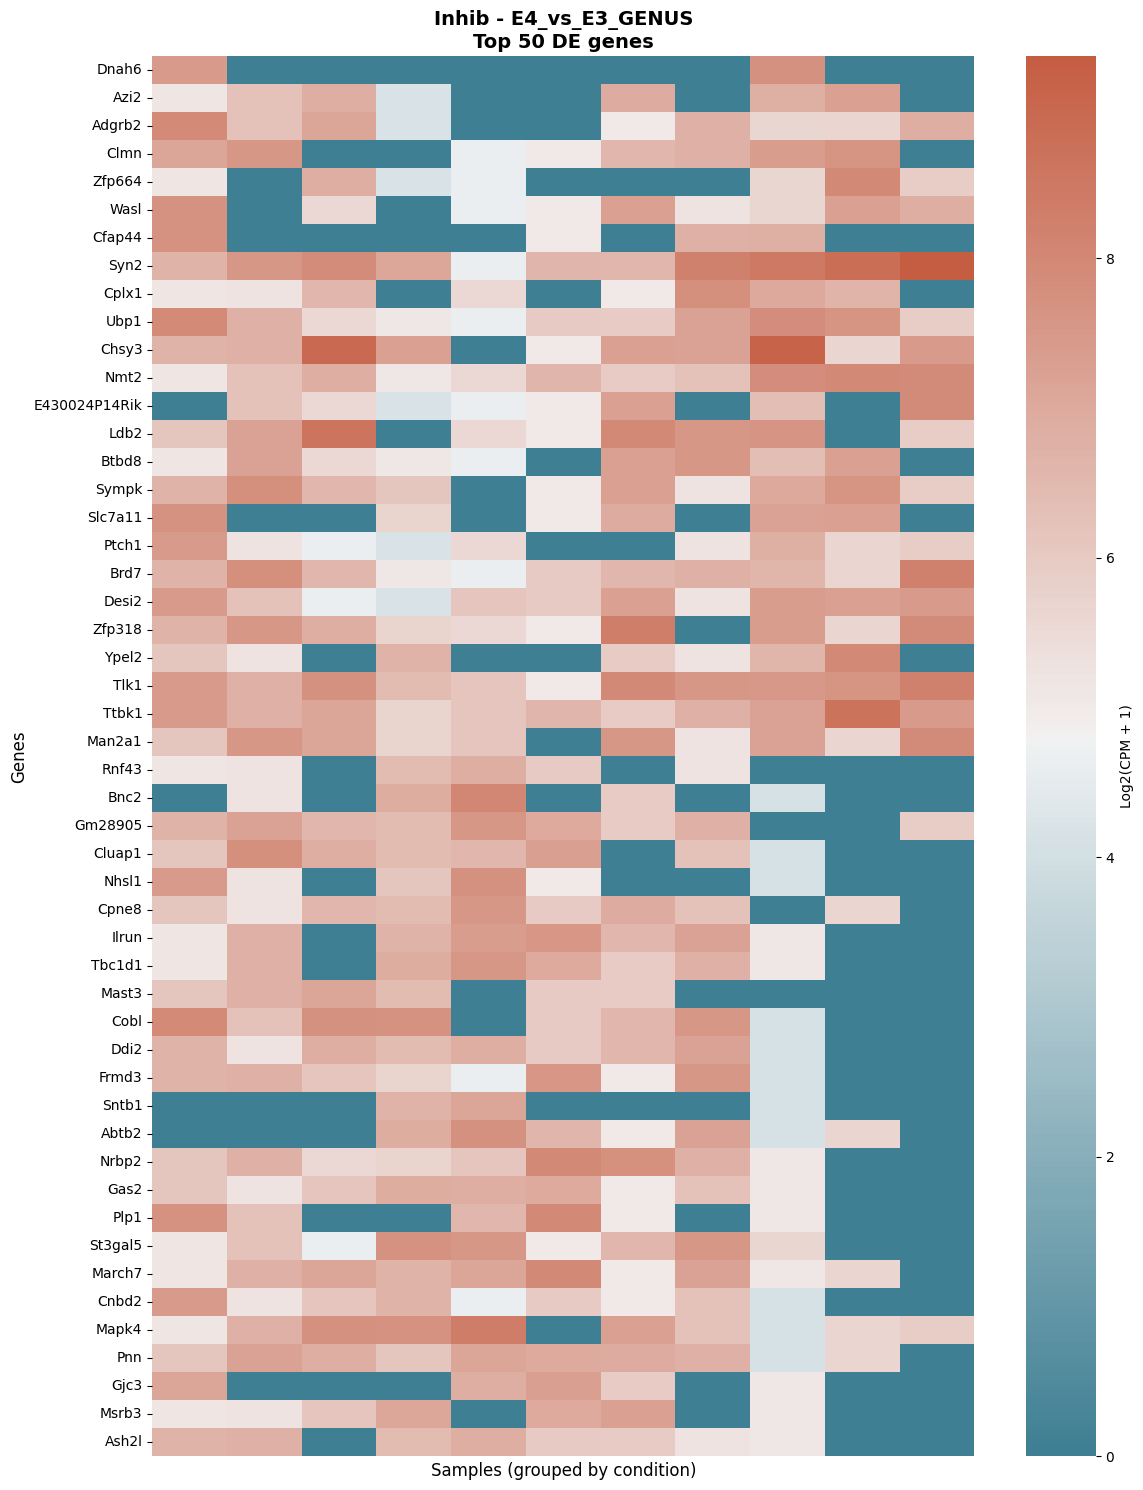

  Saved: plots/differential_expression/heatmap_InN_VIP_E3_GENUS_vs_Ctrl.png


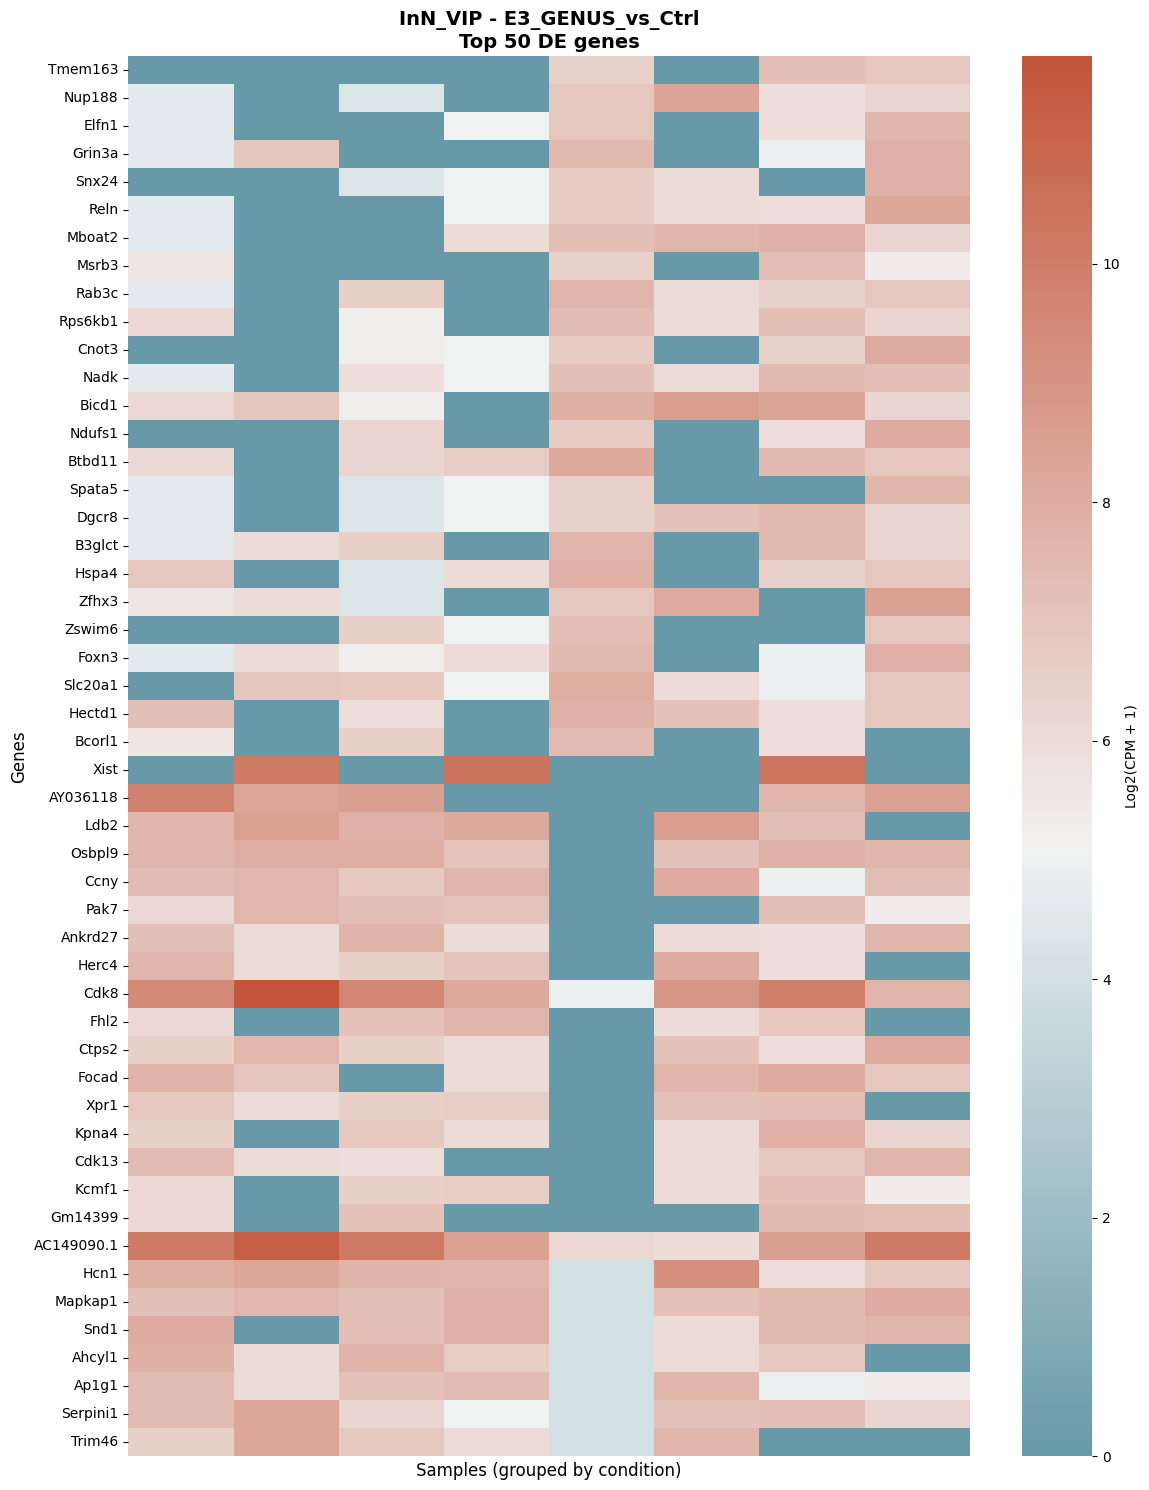

  Saved: plots/differential_expression/heatmap_InN_VIP_E4_vs_E3_Ctrl.png


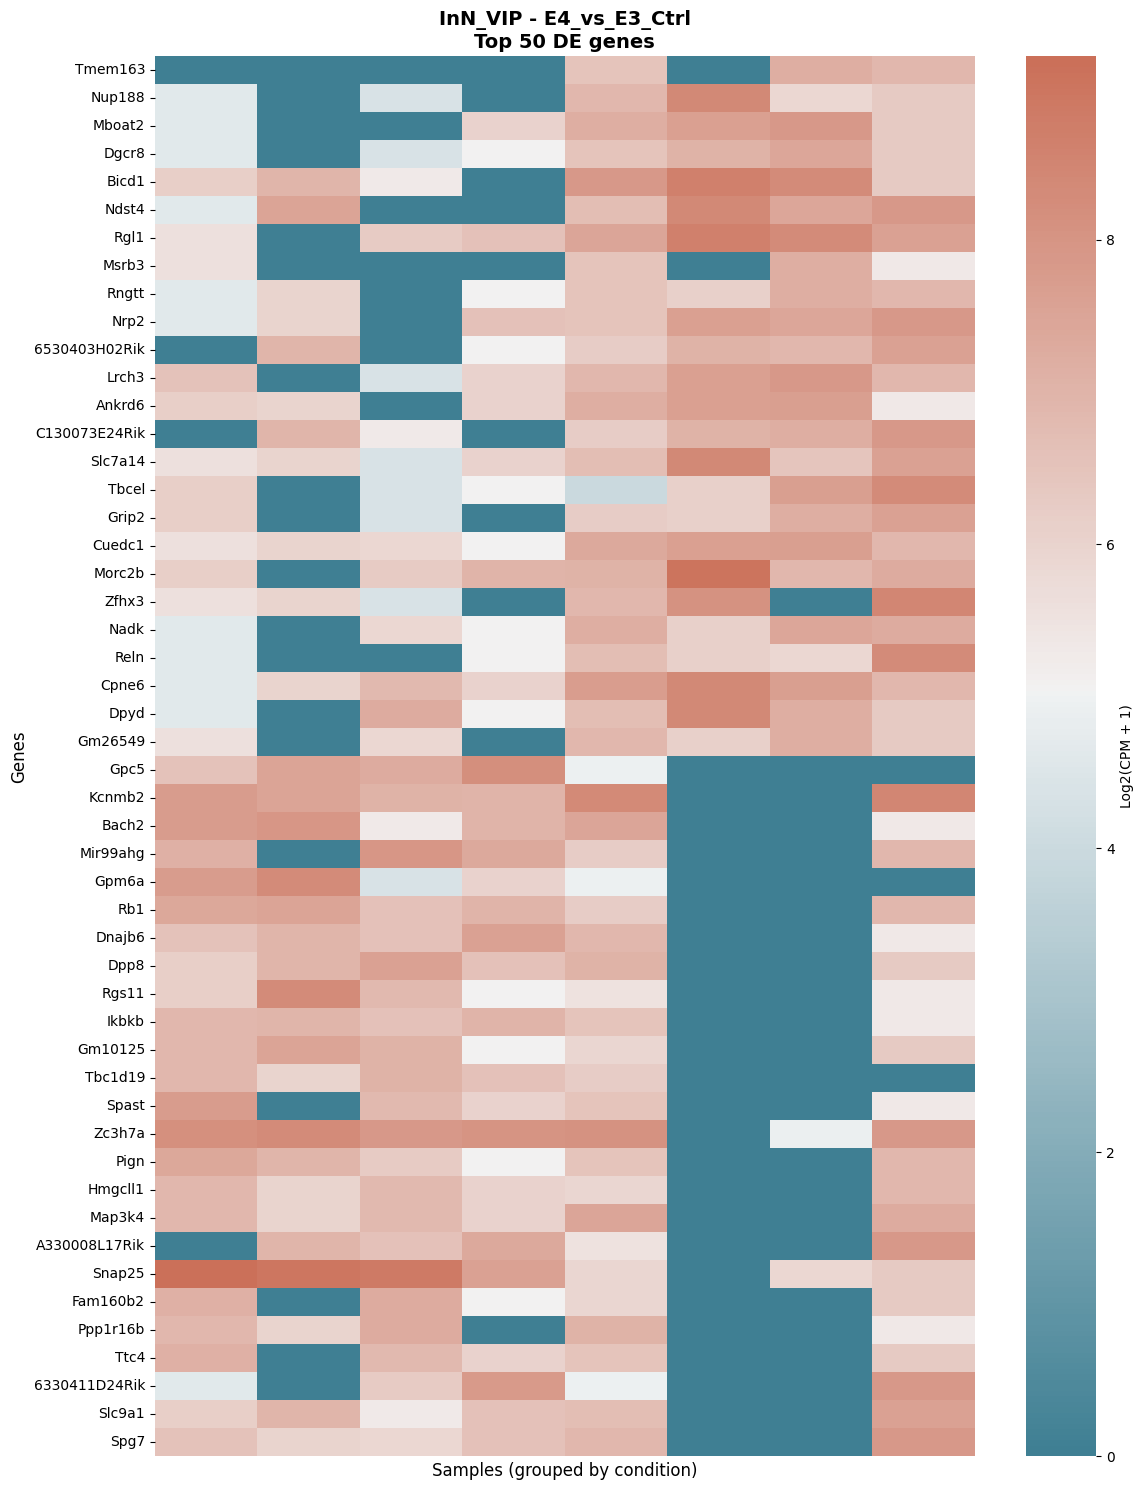

  Saved: plots/differential_expression/heatmap_Endo_E3_GENUS_vs_Ctrl.png


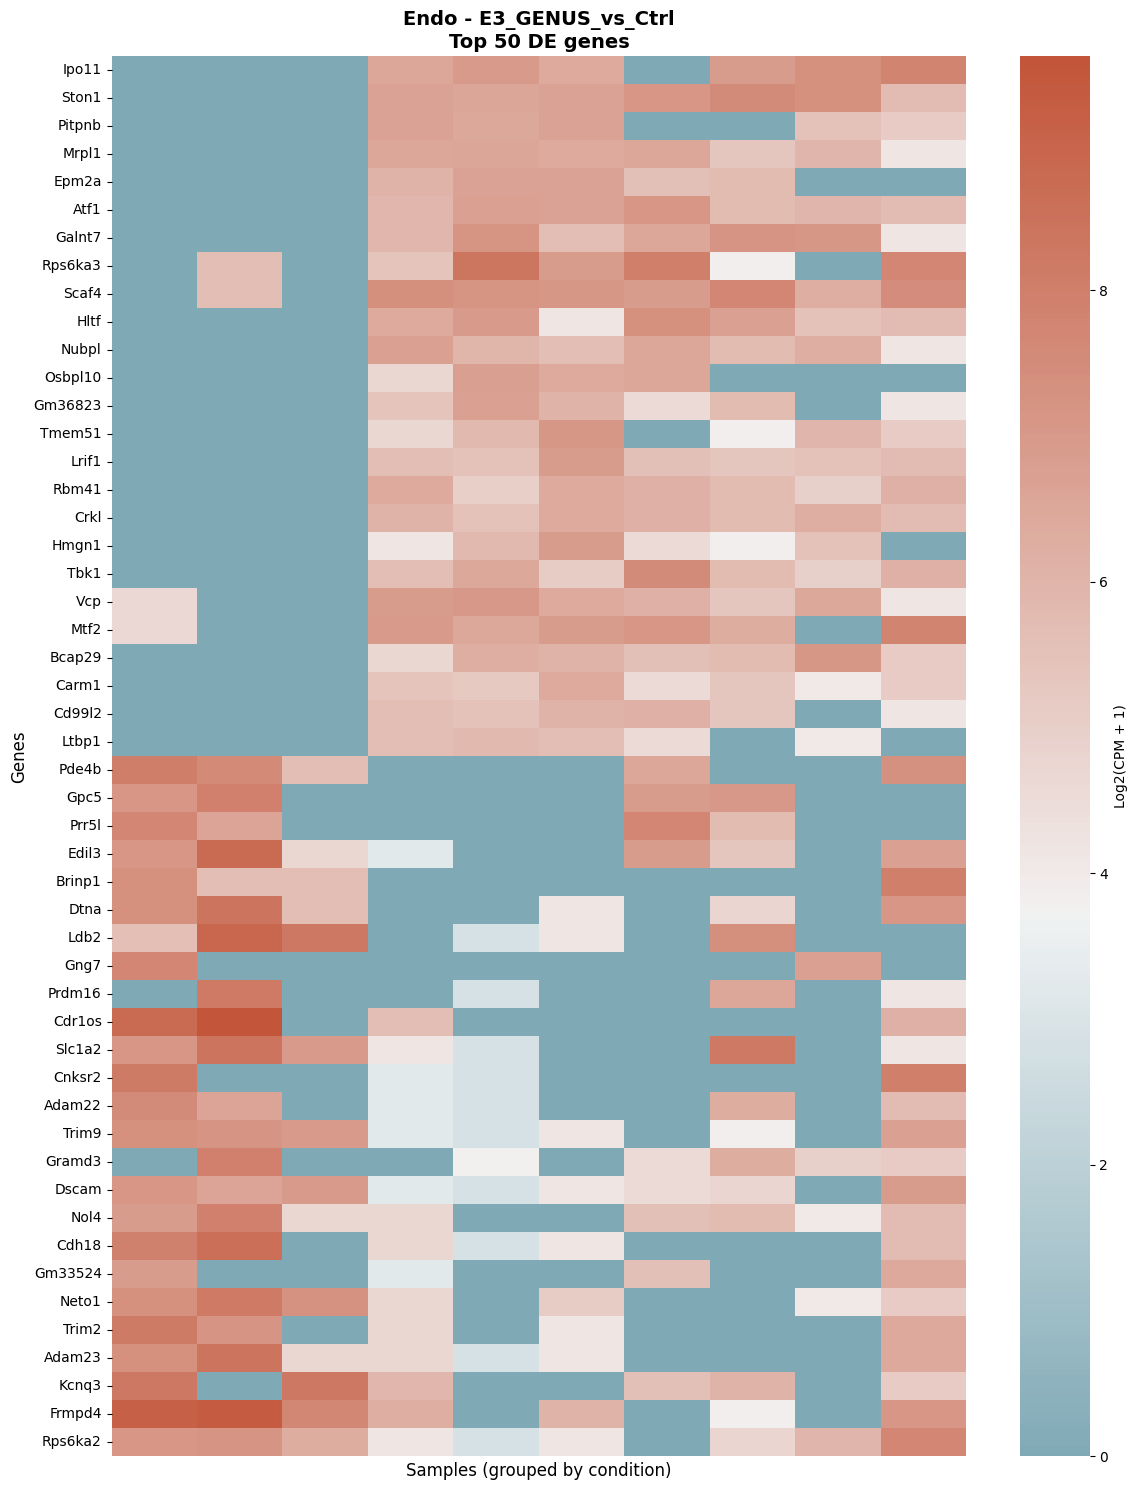

  Saved: plots/differential_expression/heatmap_Endo_E4_GENUS_vs_Ctrl.png


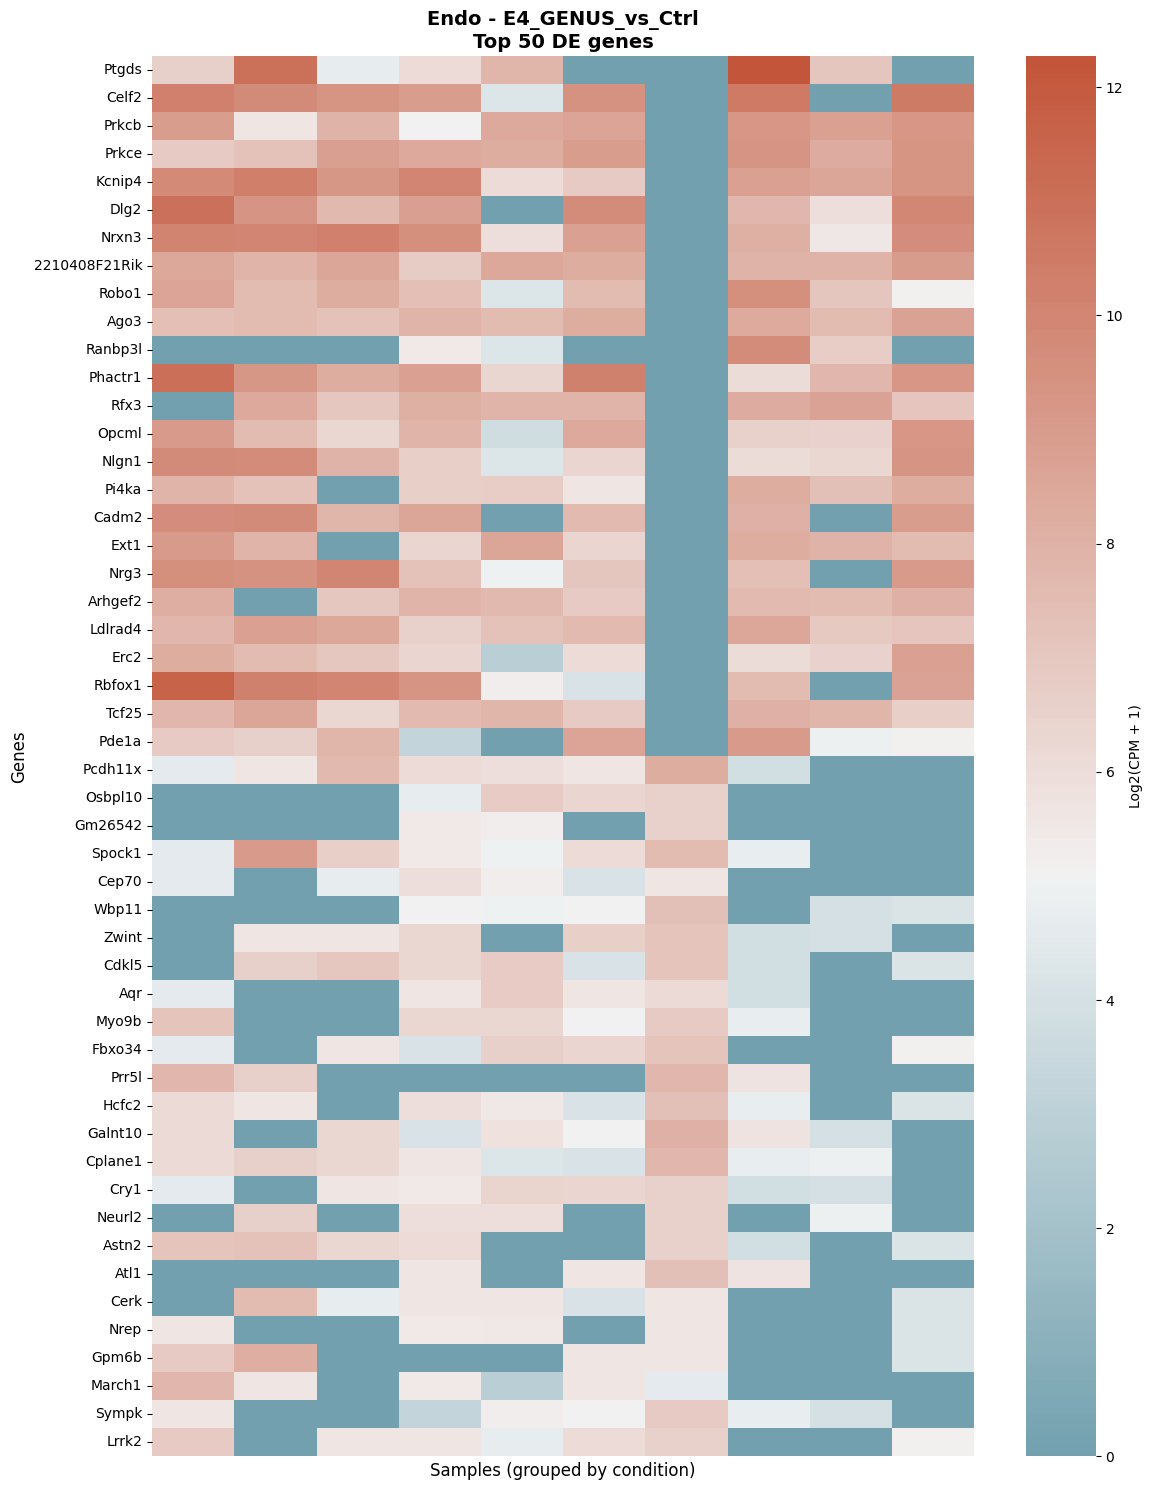

  Saved: plots/differential_expression/heatmap_Endo_E4_vs_E3_Ctrl.png


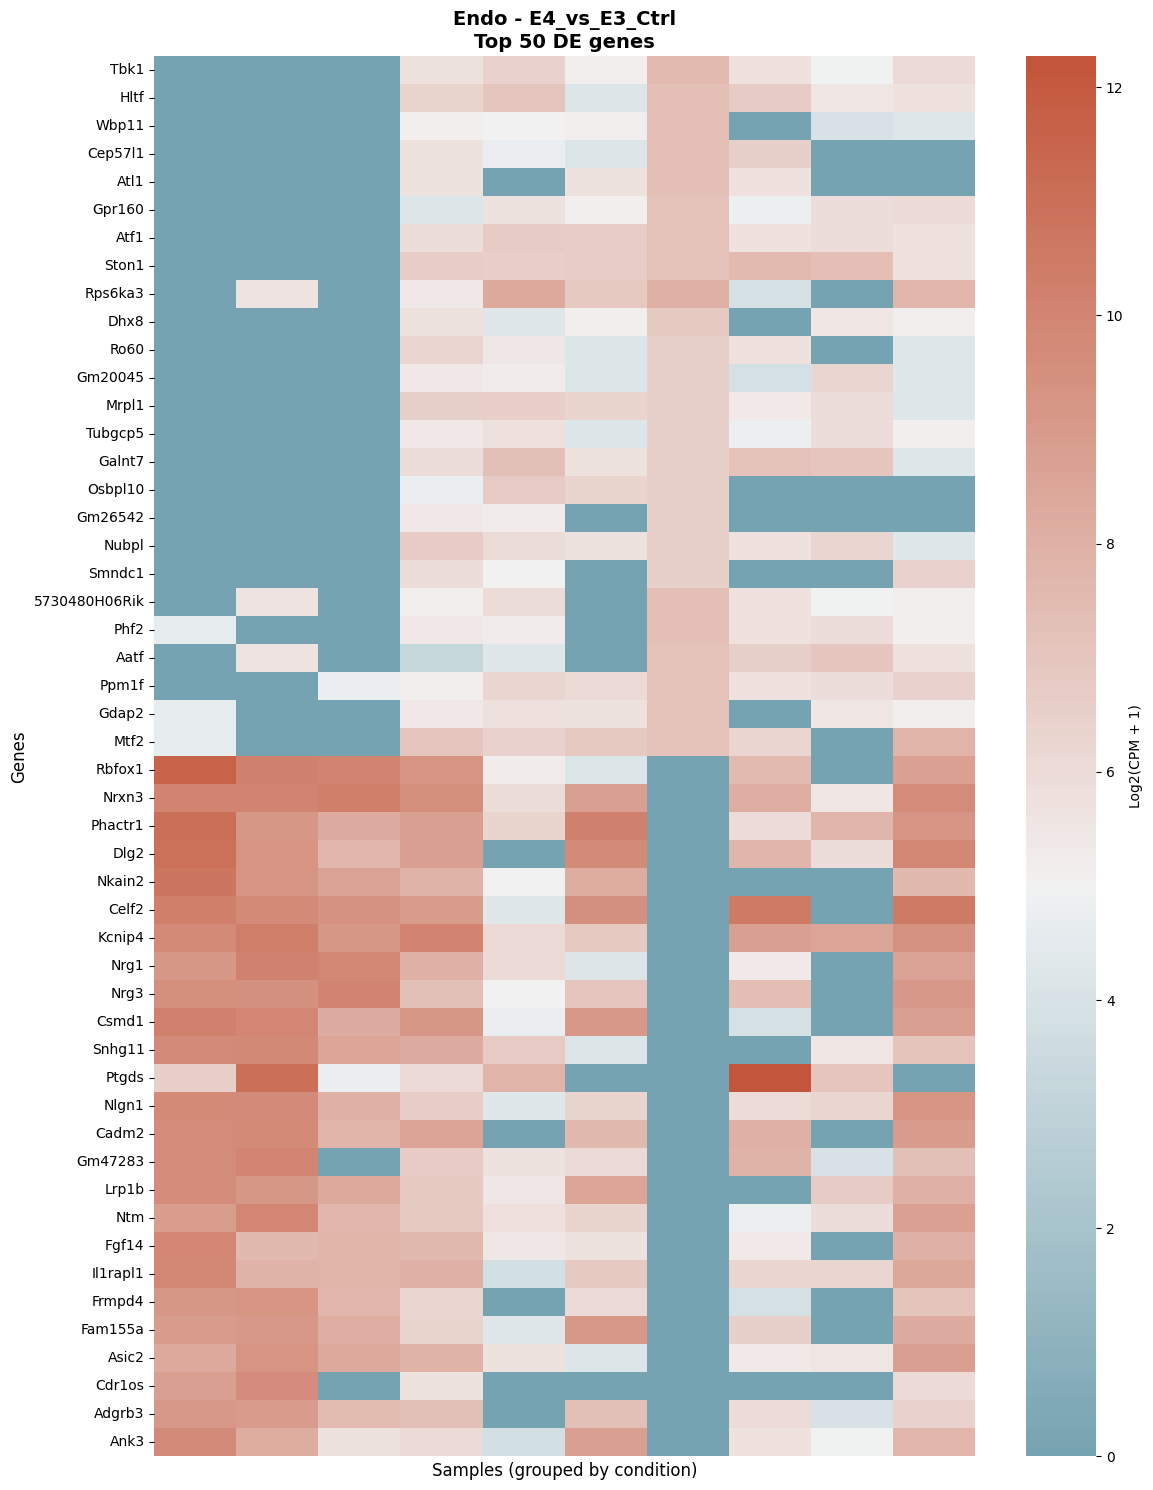

  Saved: plots/differential_expression/heatmap_Endo_E4_vs_E3_GENUS.png


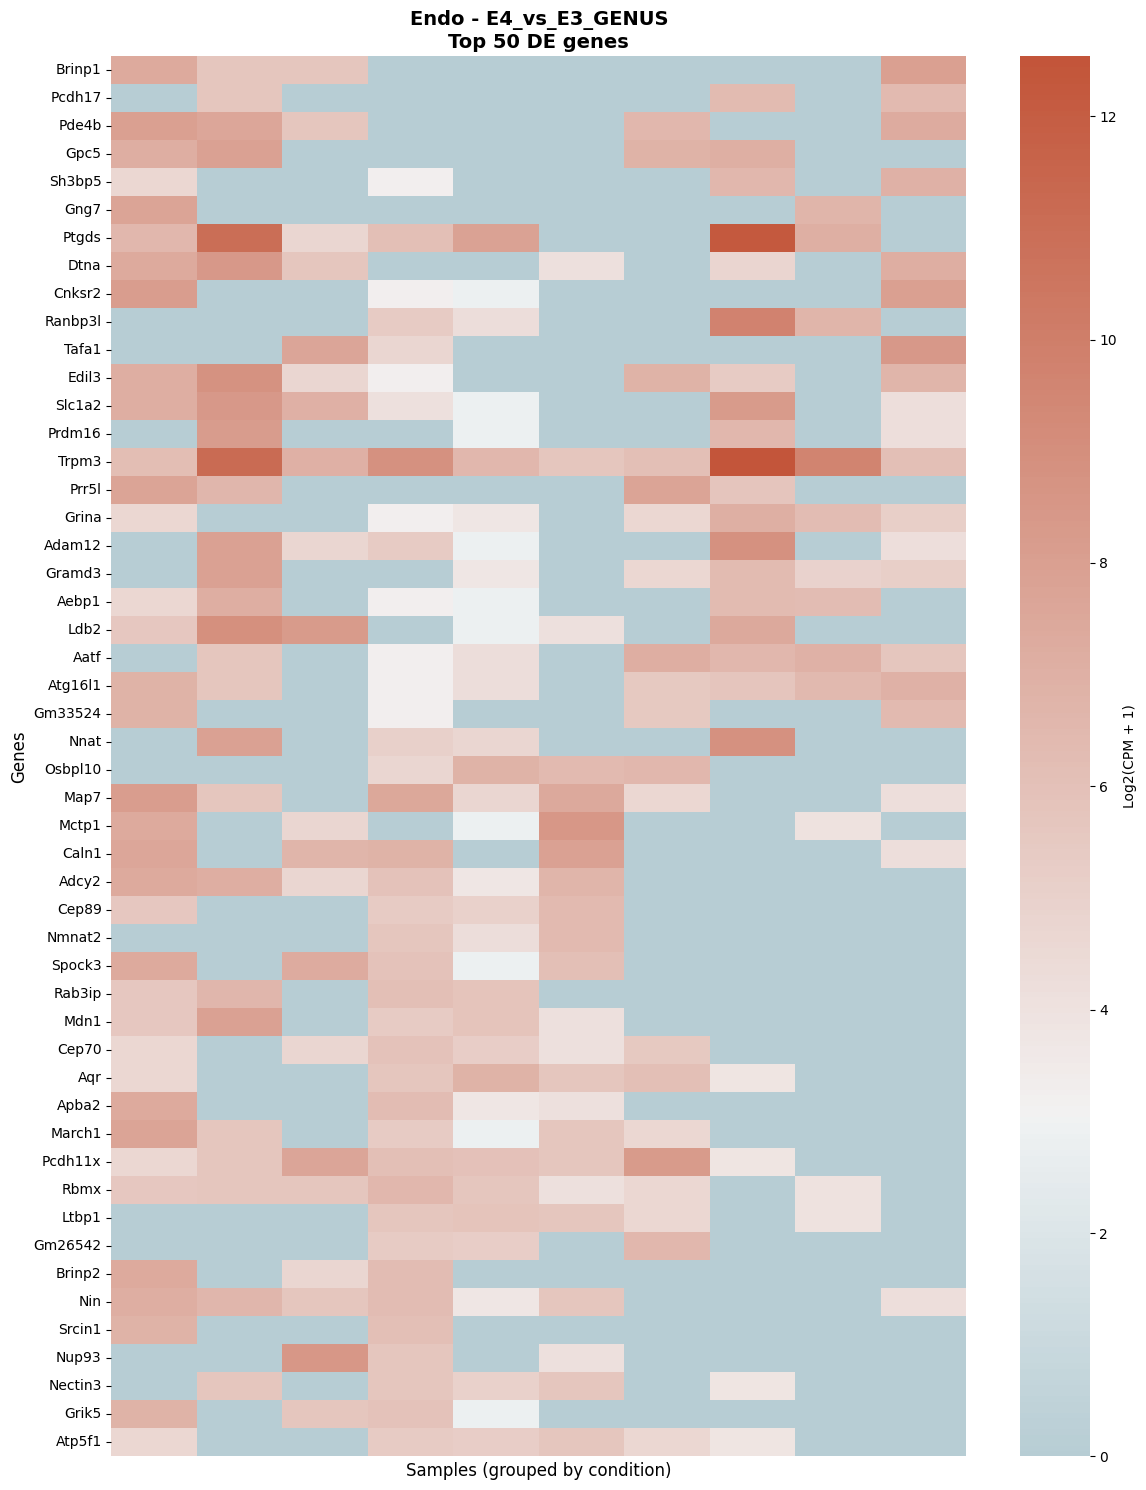

  Saved: plots/differential_expression/heatmap_Oligo_E3_GENUS_vs_Ctrl.png


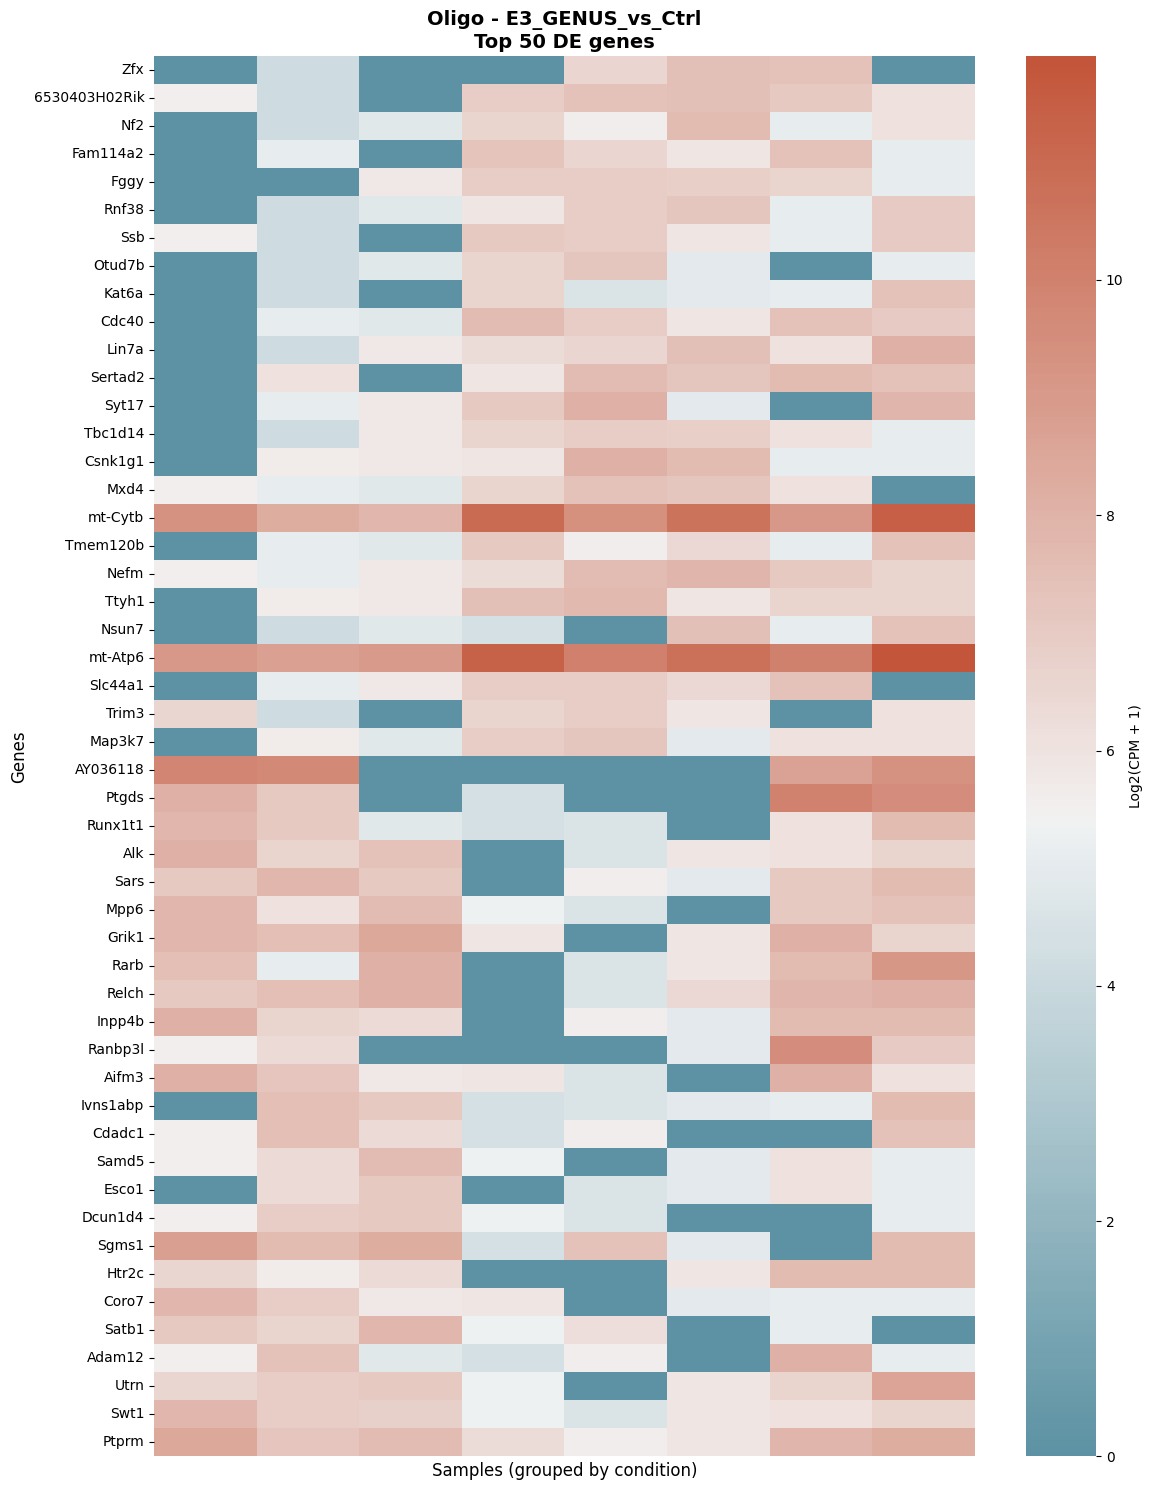

  Saved: plots/differential_expression/heatmap_Oligo_E4_vs_E3_Ctrl.png


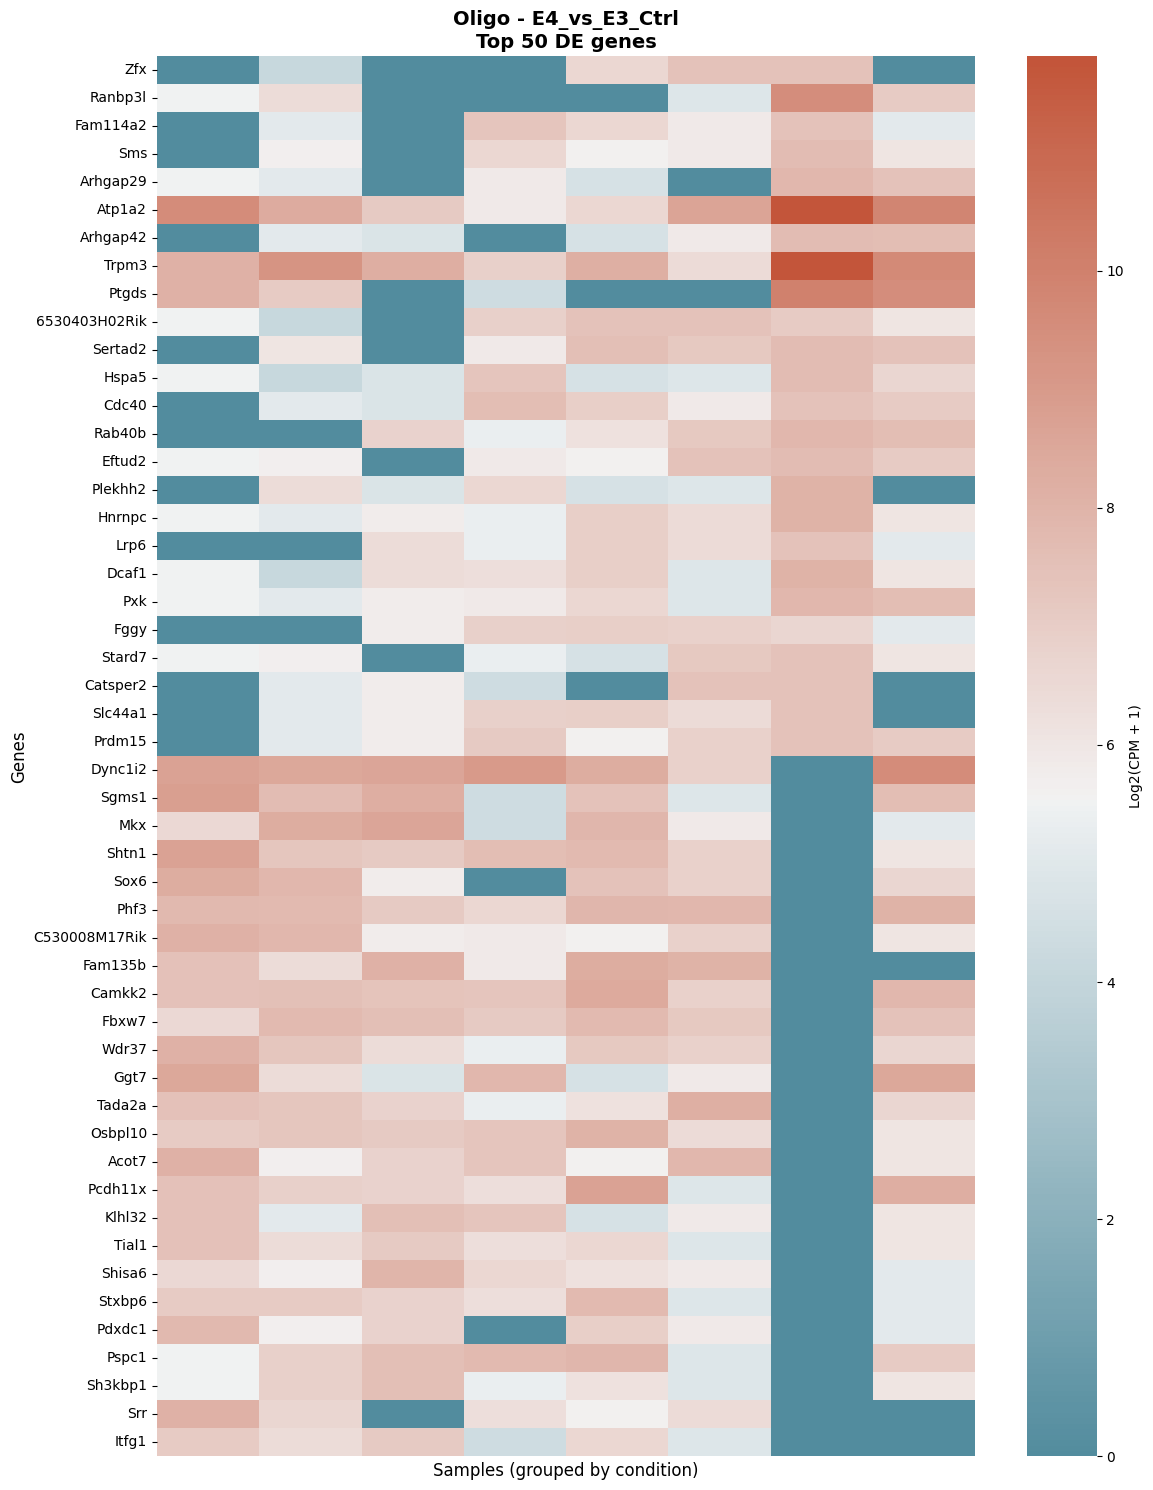

  Saved: plots/differential_expression/heatmap_Oligo_E4_vs_E3_GENUS.png


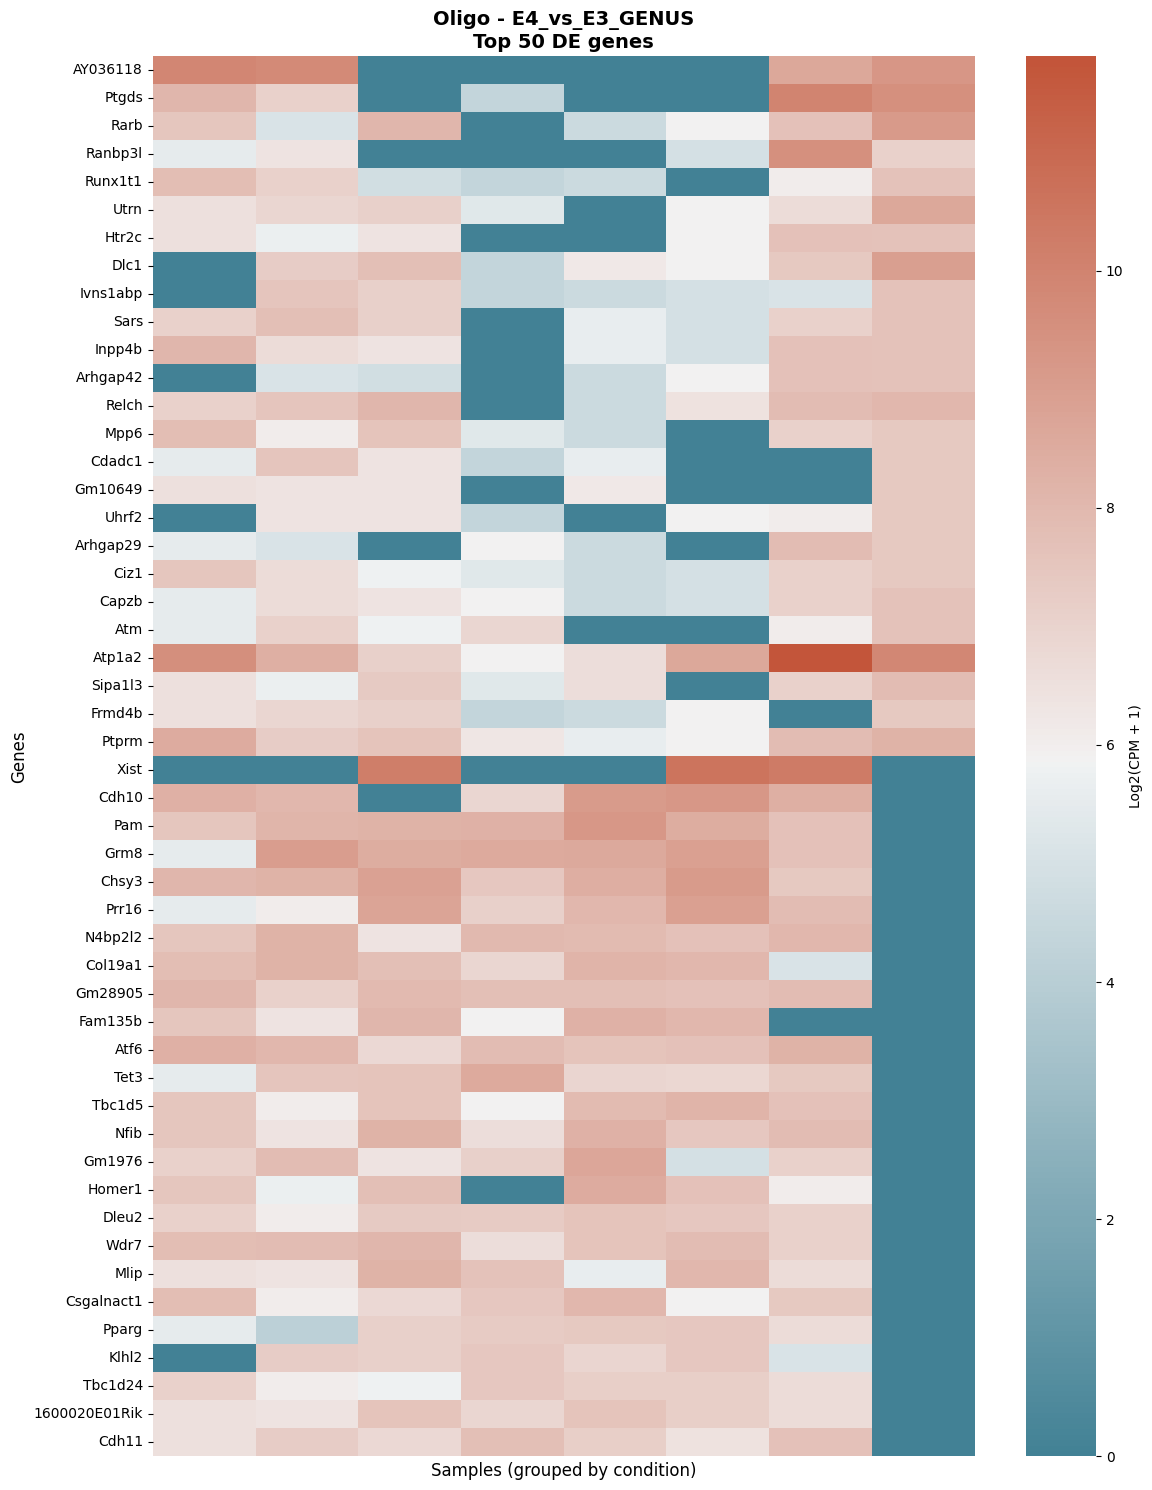

  Saved: plots/differential_expression/heatmap_InN_SST_E4_GENUS_vs_Ctrl.png


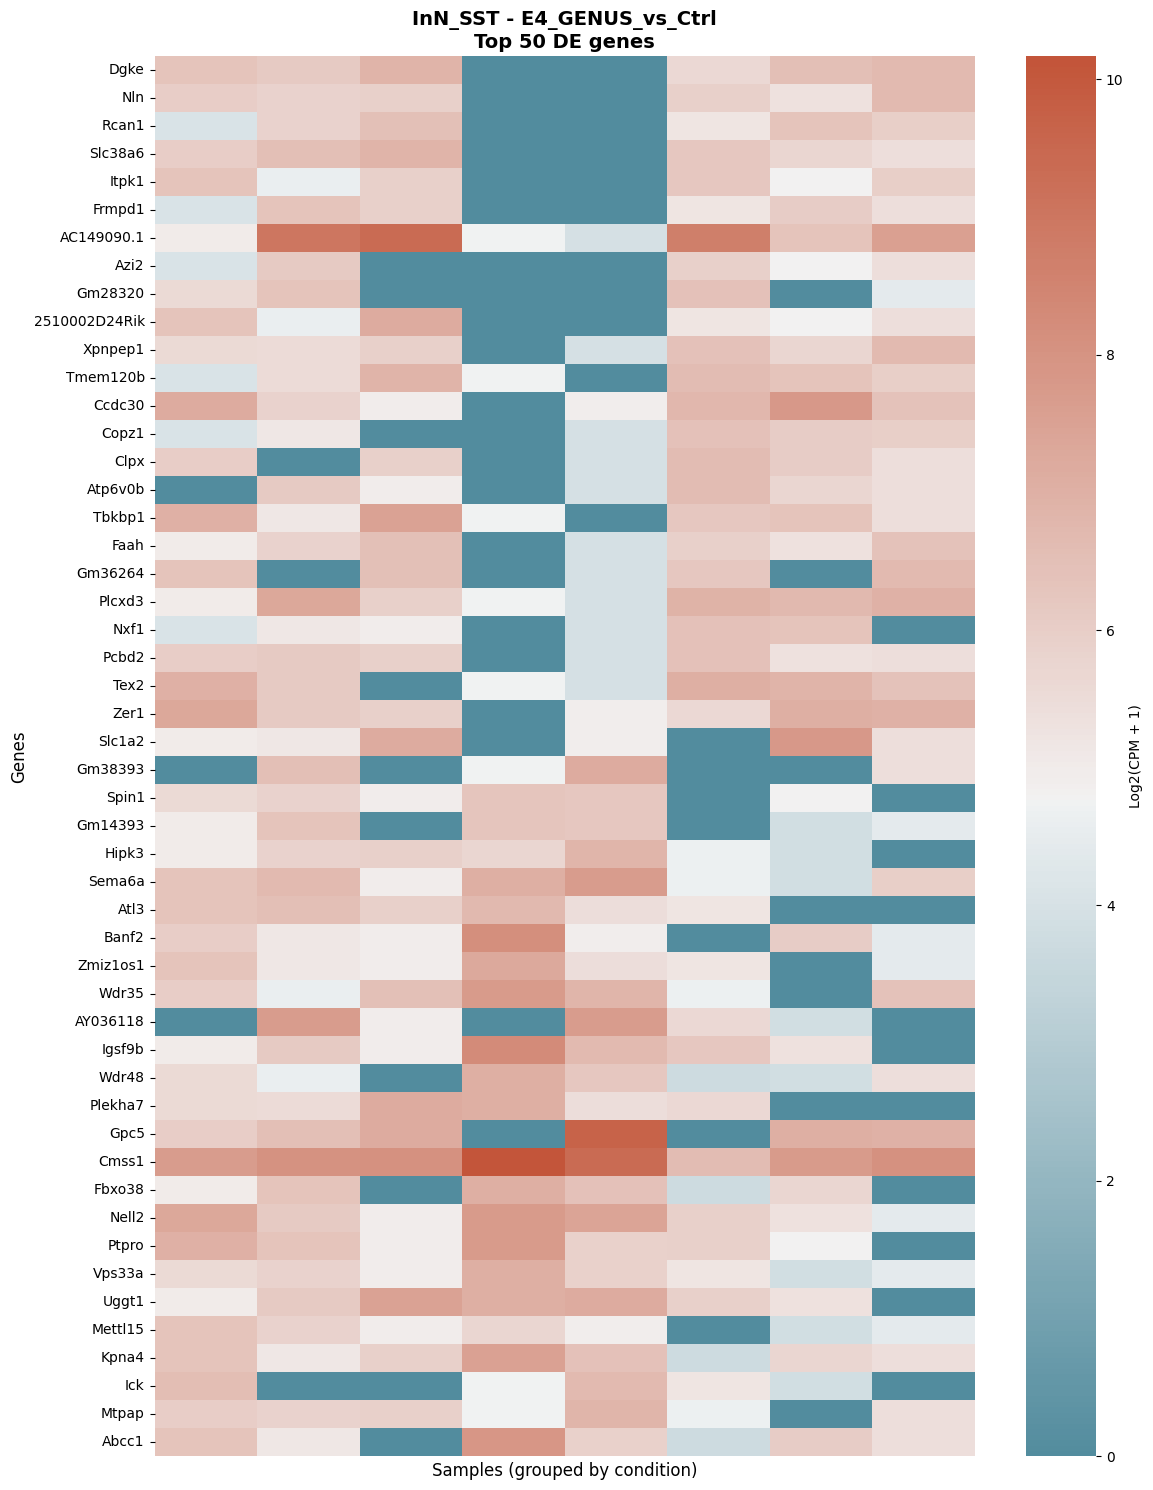

  Saved: plots/differential_expression/heatmap_InN_SST_E4_vs_E3_GENUS.png


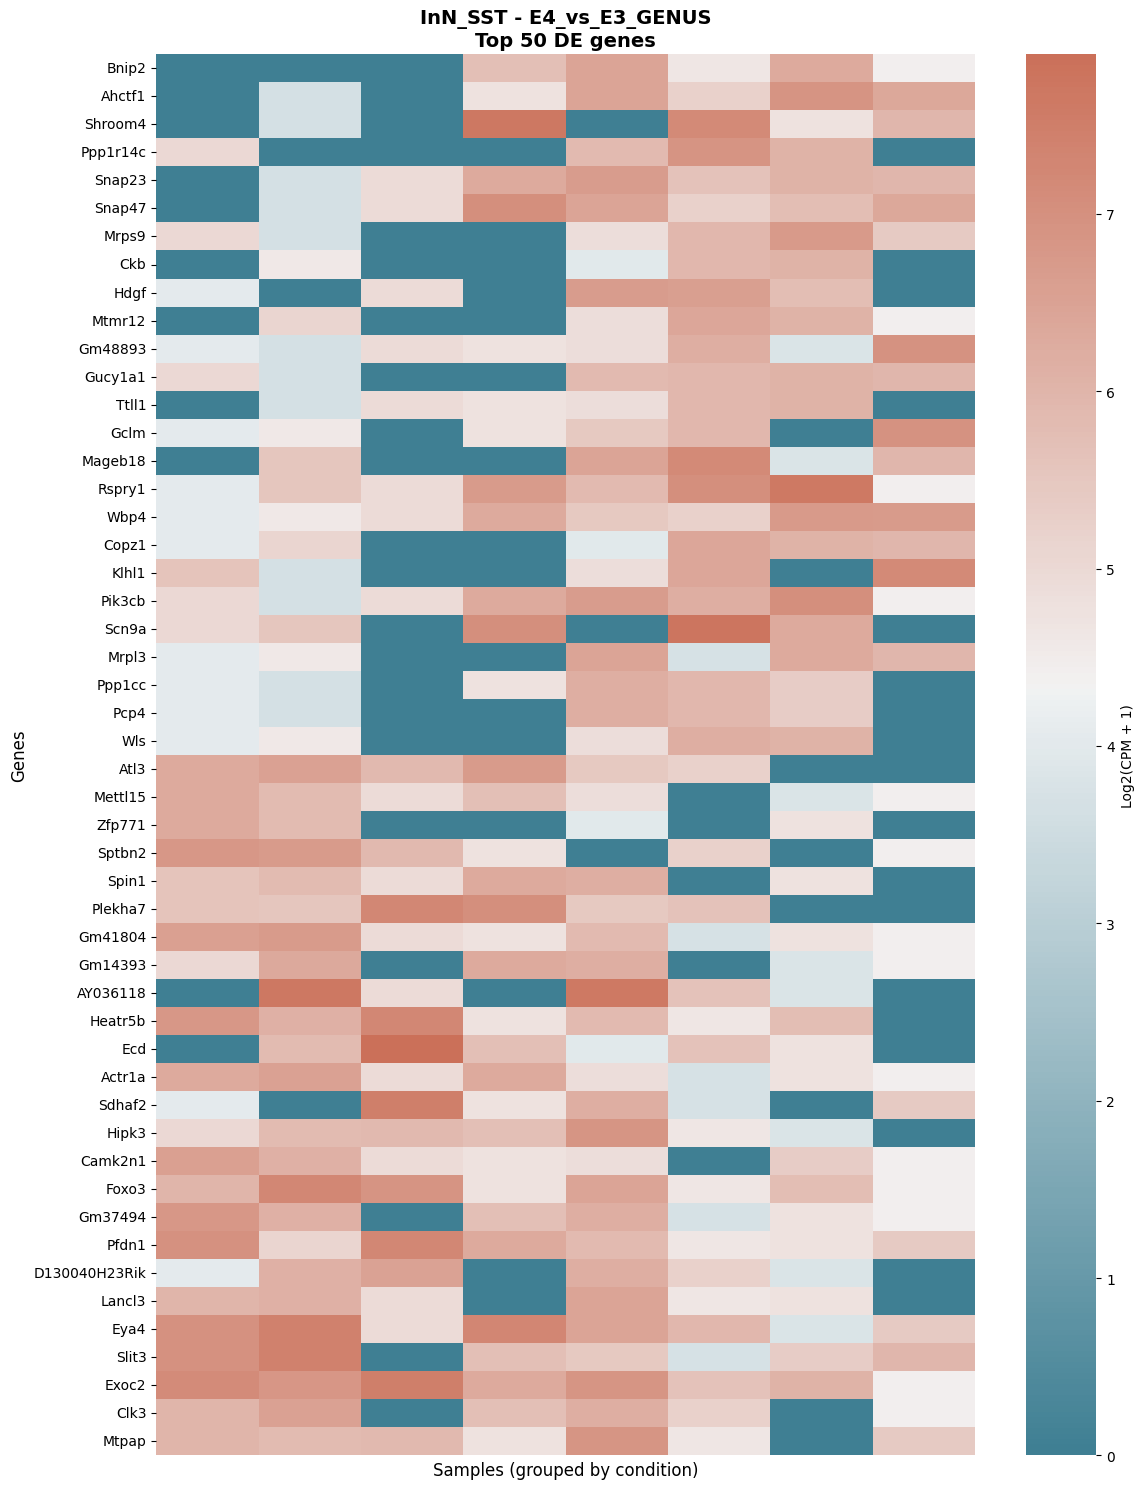

  Saved: plots/differential_expression/heatmap_Micro_E4_vs_E3_GENUS.png


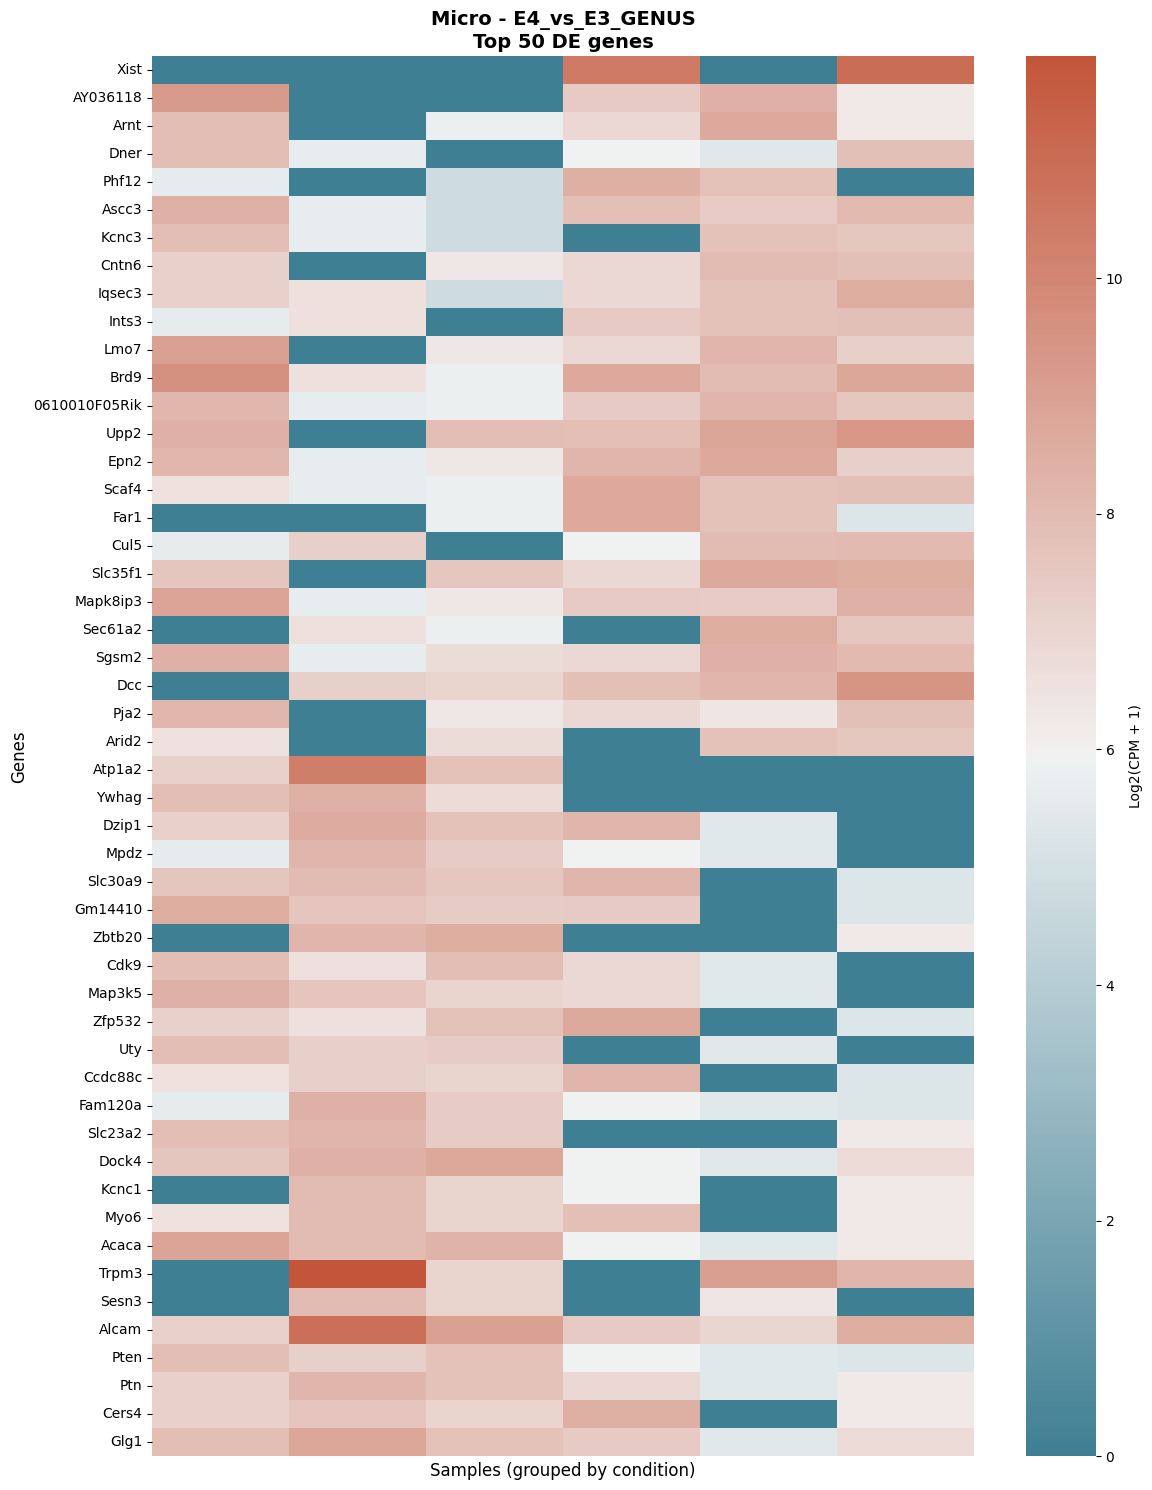

In [63]:
# Plot heatmaps for each cell type and contrast
if combined_results is not None:
    print("\n" + "="*60)
    print("GENERATING HEATMAPS")
    print("="*60)
    
    for cell_type in CELL_TYPES_TO_ANALYZE:
        ct_results = combined_results[combined_results['cell_type'] == cell_type]
        contrasts = ct_results['contrast'].unique()
        
        for contrast in contrasts:
            # Also plot heatmap of NUMBER of upregulated and downregulated genes, before disaggregating by individual genes
            save_path = PLOTS_DIR / f'heatmap_{cell_type}_{contrast}.png'
            plot_de_heatmap(
                pb_df,
                sample_info_df,
                combined_results,
                cell_type,
                contrast,
                top_n=VIZ_PARAMS['top_n_genes'],
                save_path=save_path
            )


## 8. Visualization: Volcano Plots

Create volcano plots showing differential expression patterns for each cell type and contrast.


## 8. Visualization: Volcano Plots

Create volcano plots showing differential expression patterns for each cell type and contrast.


In [64]:
# Import volcano plot function from utils
from utils.differential_expression import plot_volcano



GENERATING VOLCANO PLOTS
  Saved: plots/differential_expression/volcano_Excit_E3_GENUS_vs_Ctrl.png


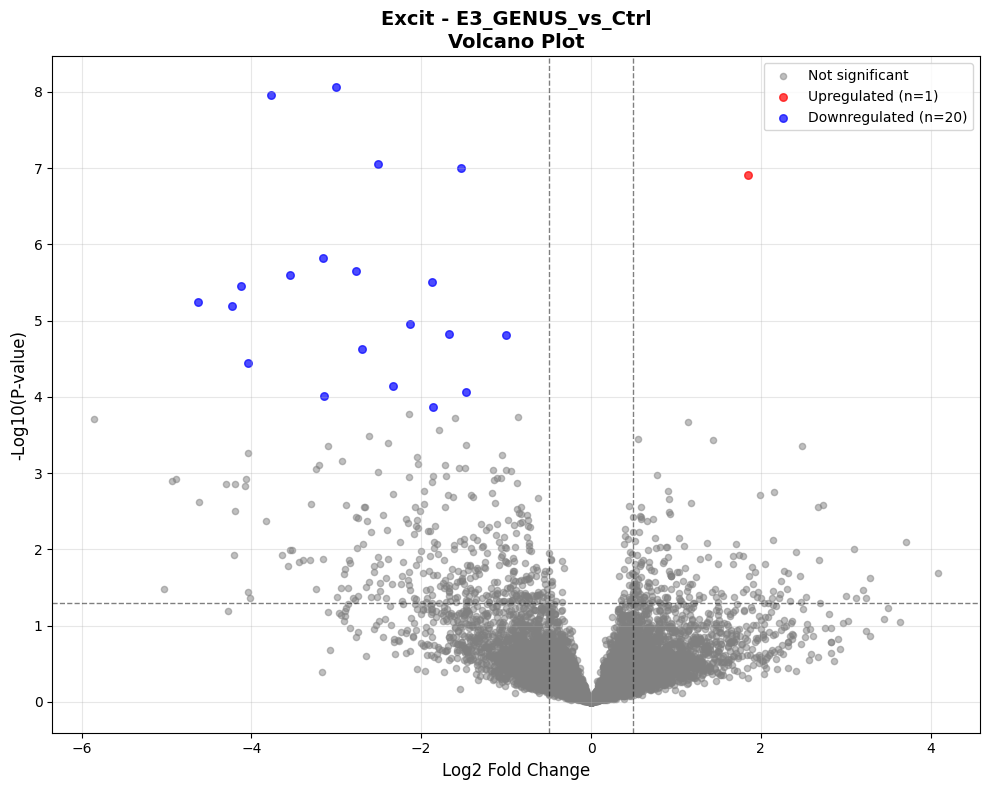

  Saved: plots/differential_expression/volcano_Excit_E4_GENUS_vs_Ctrl.png


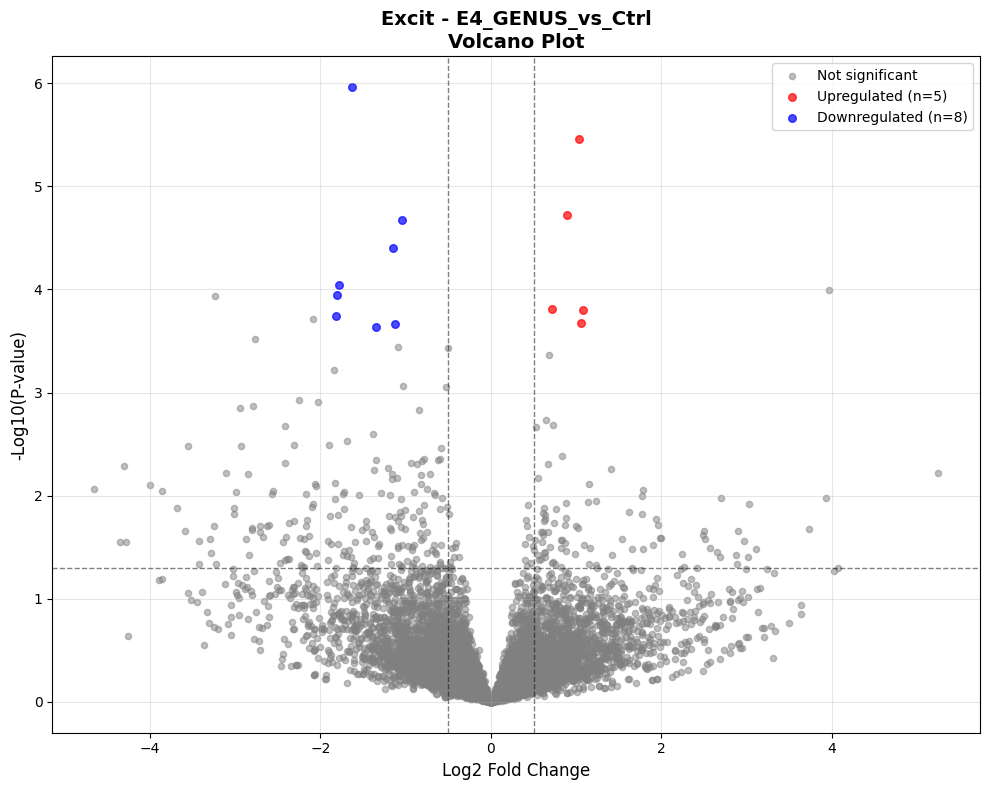

  Saved: plots/differential_expression/volcano_Excit_E4_vs_E3_Ctrl.png


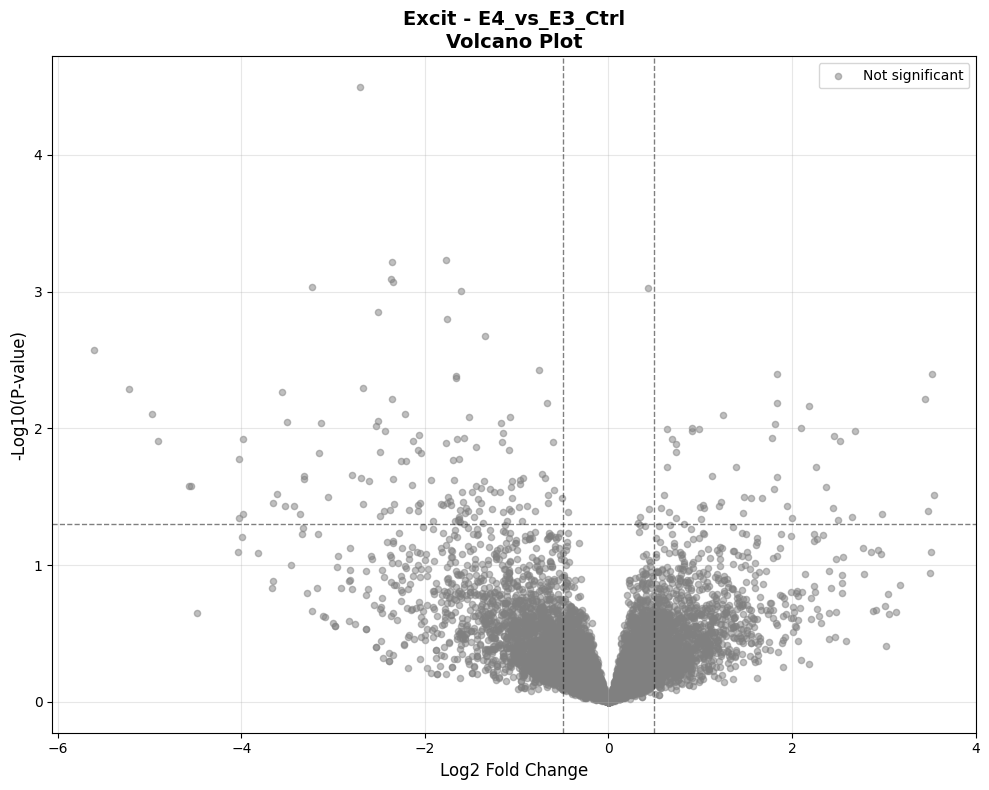

  Saved: plots/differential_expression/volcano_Excit_E4_vs_E3_GENUS.png


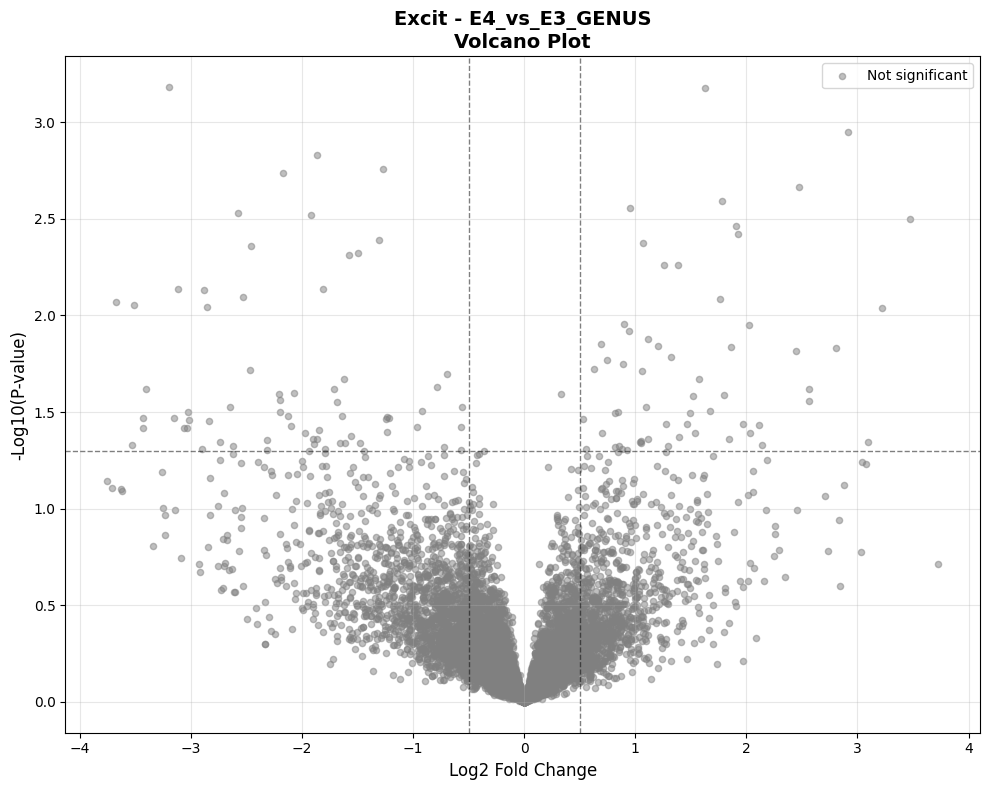

  Saved: plots/differential_expression/volcano_OPC_E3_GENUS_vs_Ctrl.png


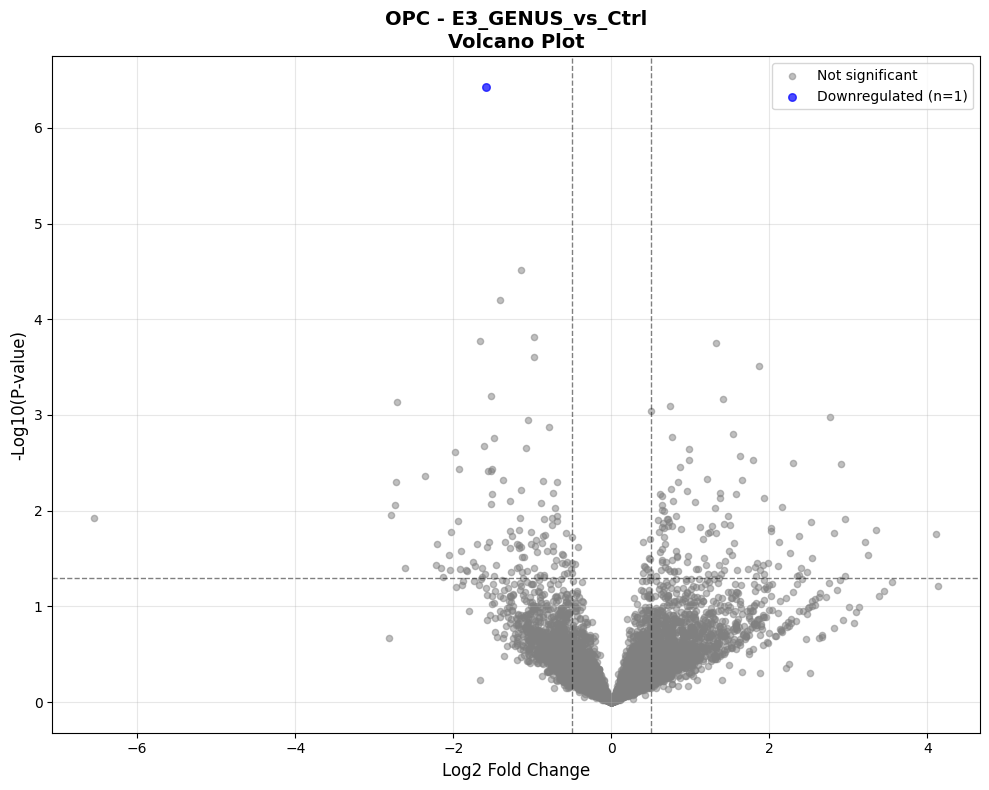

  Saved: plots/differential_expression/volcano_OPC_E4_GENUS_vs_Ctrl.png


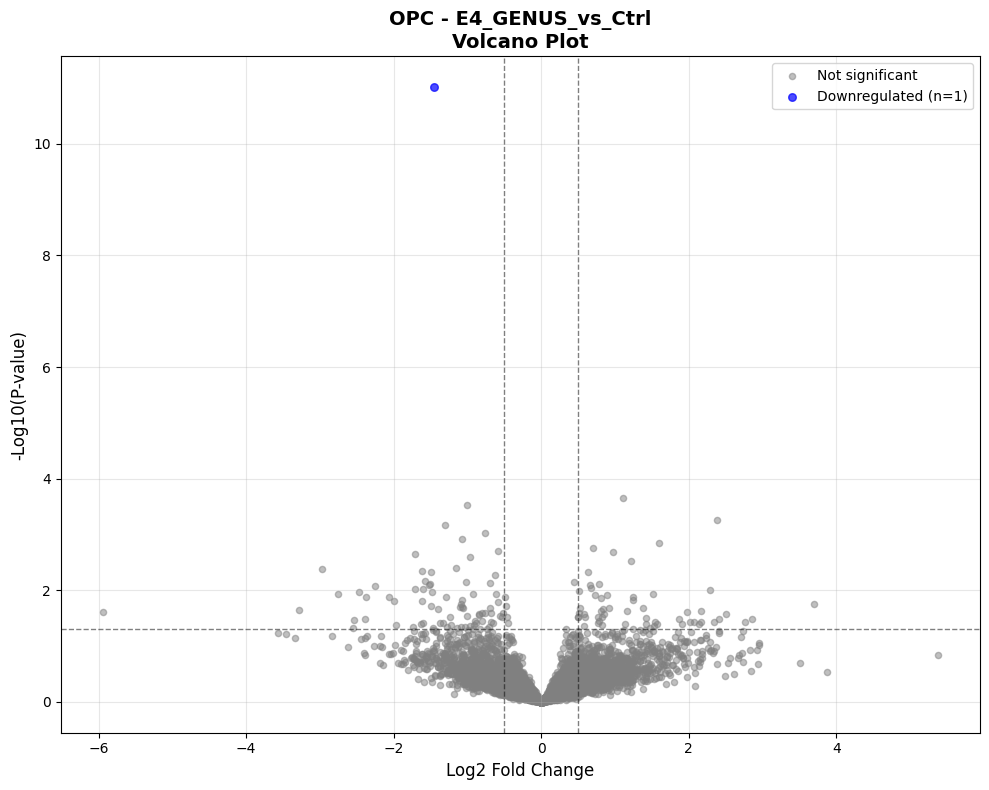

  Saved: plots/differential_expression/volcano_OPC_E4_vs_E3_Ctrl.png


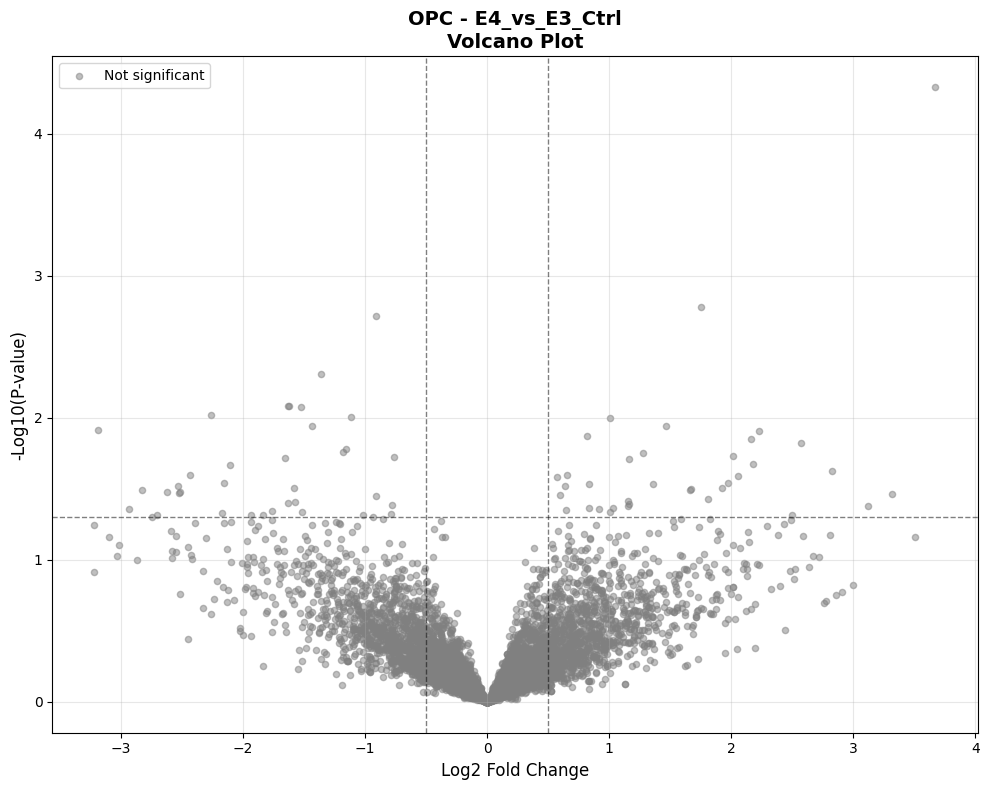

  Saved: plots/differential_expression/volcano_OPC_E4_vs_E3_GENUS.png


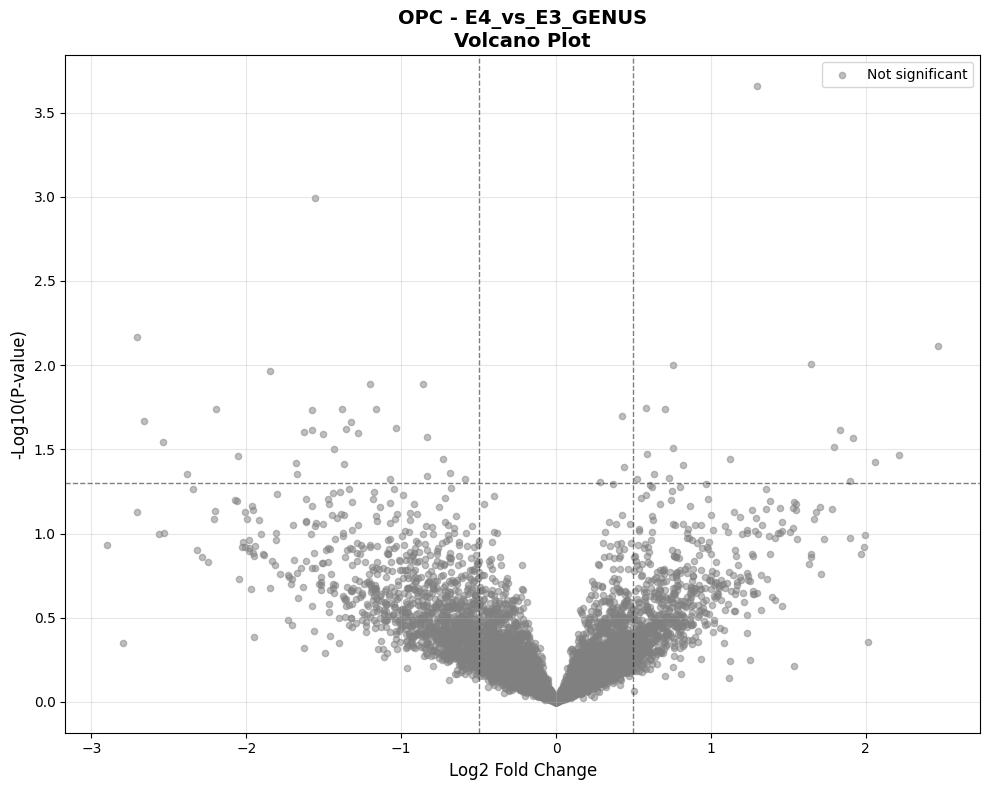

  Saved: plots/differential_expression/volcano_ExN_L6b_E3_GENUS_vs_Ctrl.png


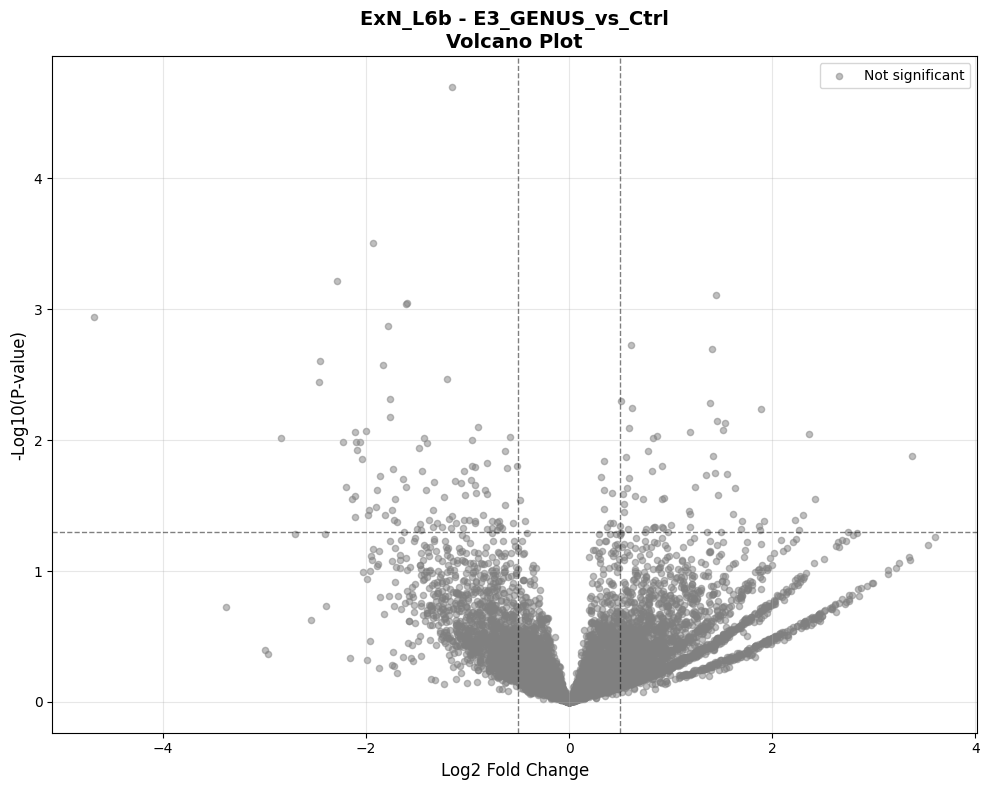

  Saved: plots/differential_expression/volcano_ExN_L6b_E4_GENUS_vs_Ctrl.png


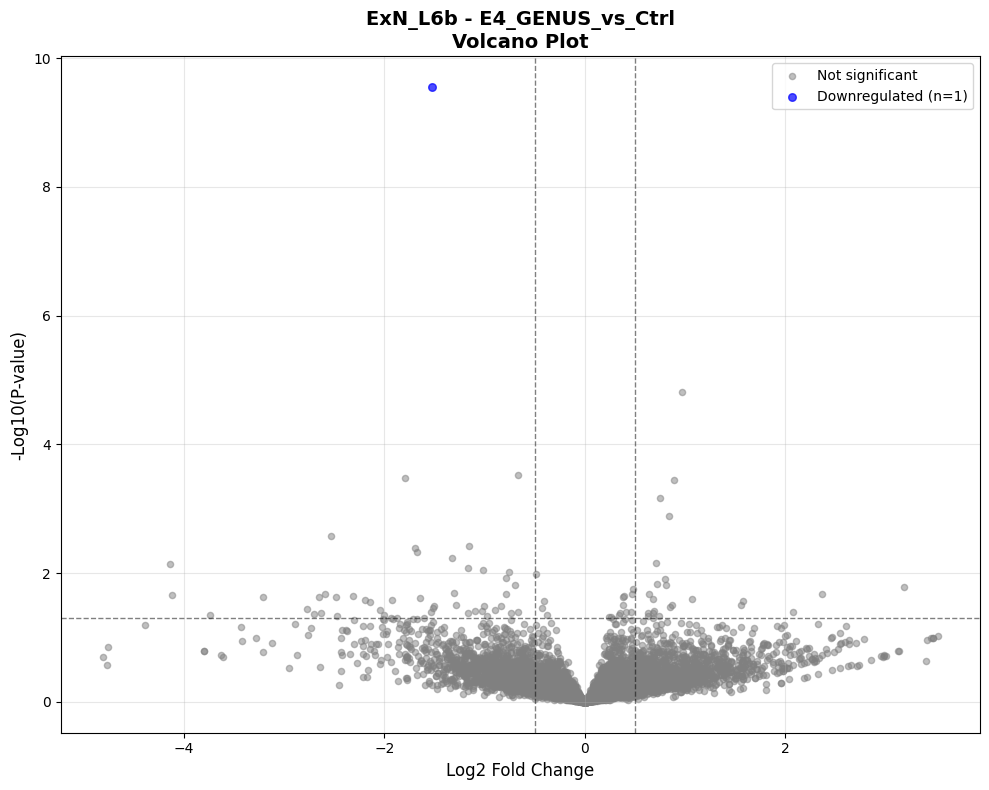

  Saved: plots/differential_expression/volcano_ExN_L6b_E4_vs_E3_Ctrl.png


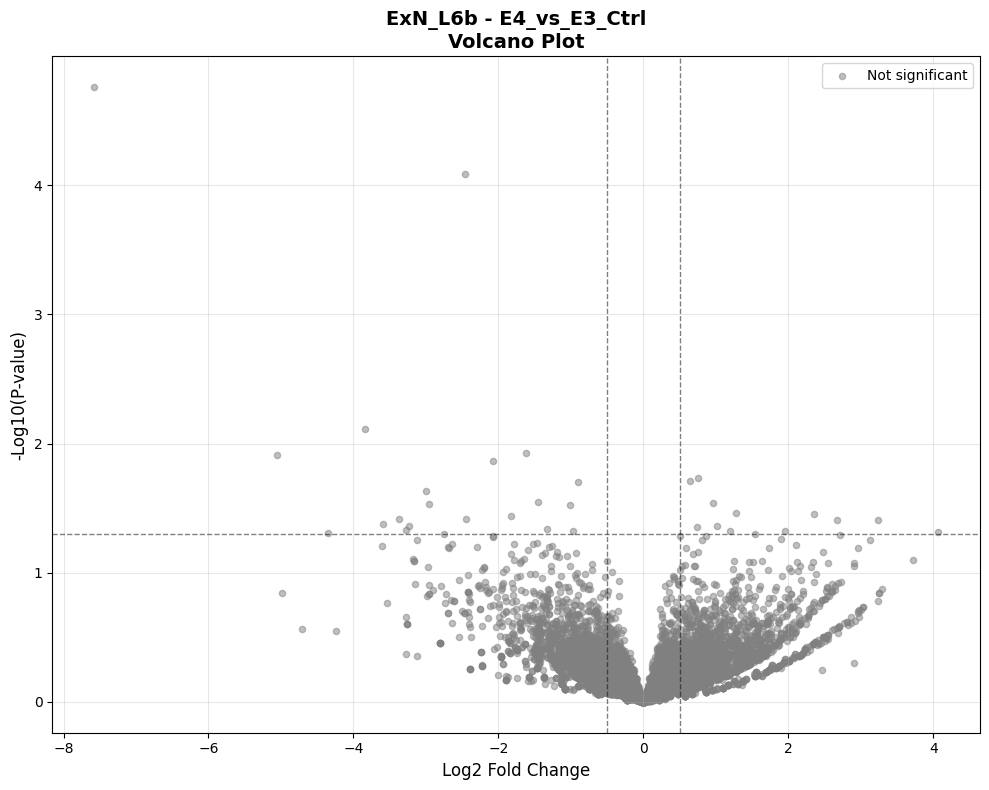

  Saved: plots/differential_expression/volcano_ExN_L6b_E4_vs_E3_GENUS.png


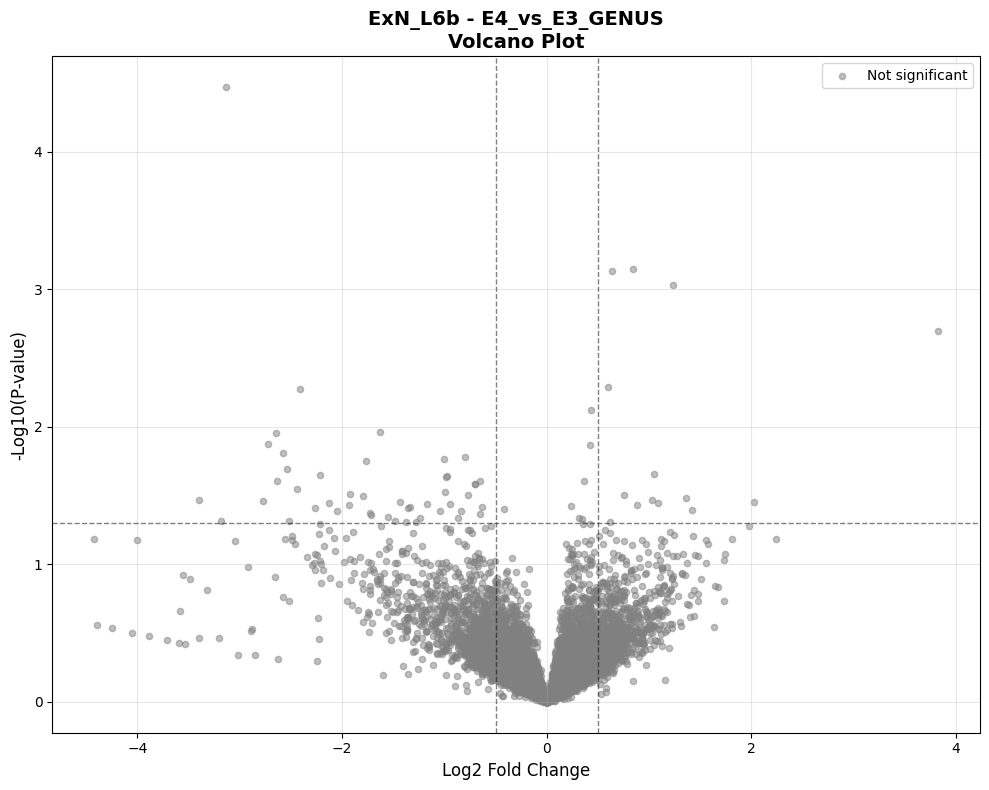

  Saved: plots/differential_expression/volcano_InN_PVALB_E3_GENUS_vs_Ctrl.png


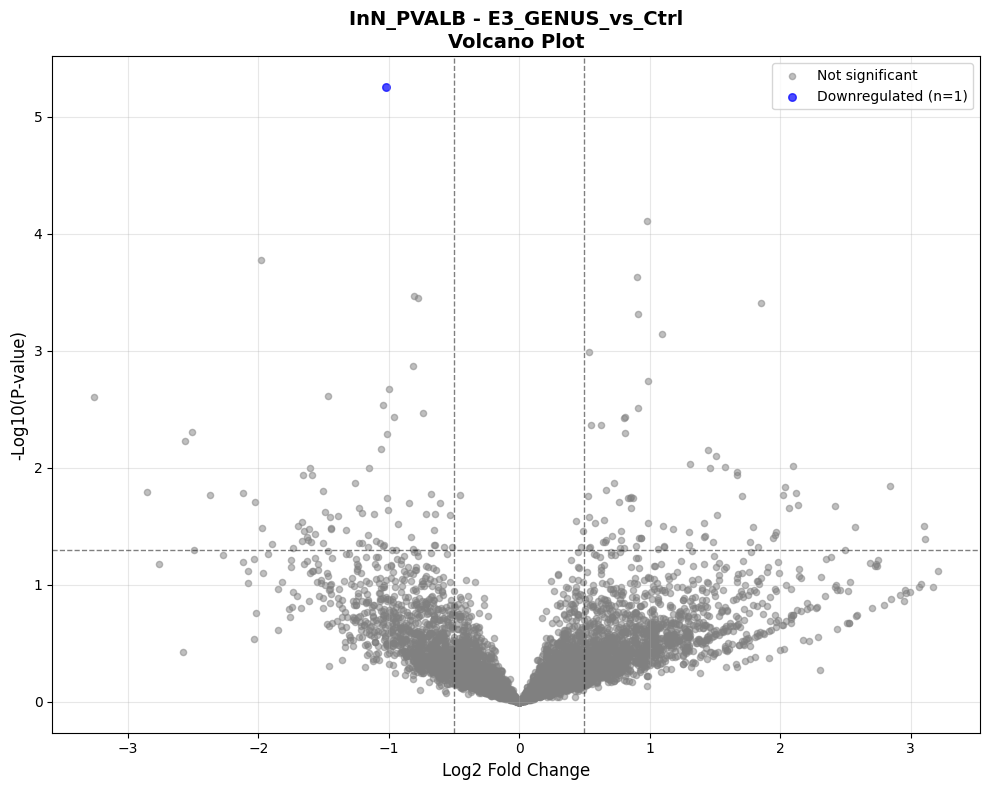

  Saved: plots/differential_expression/volcano_InN_PVALB_E4_GENUS_vs_Ctrl.png


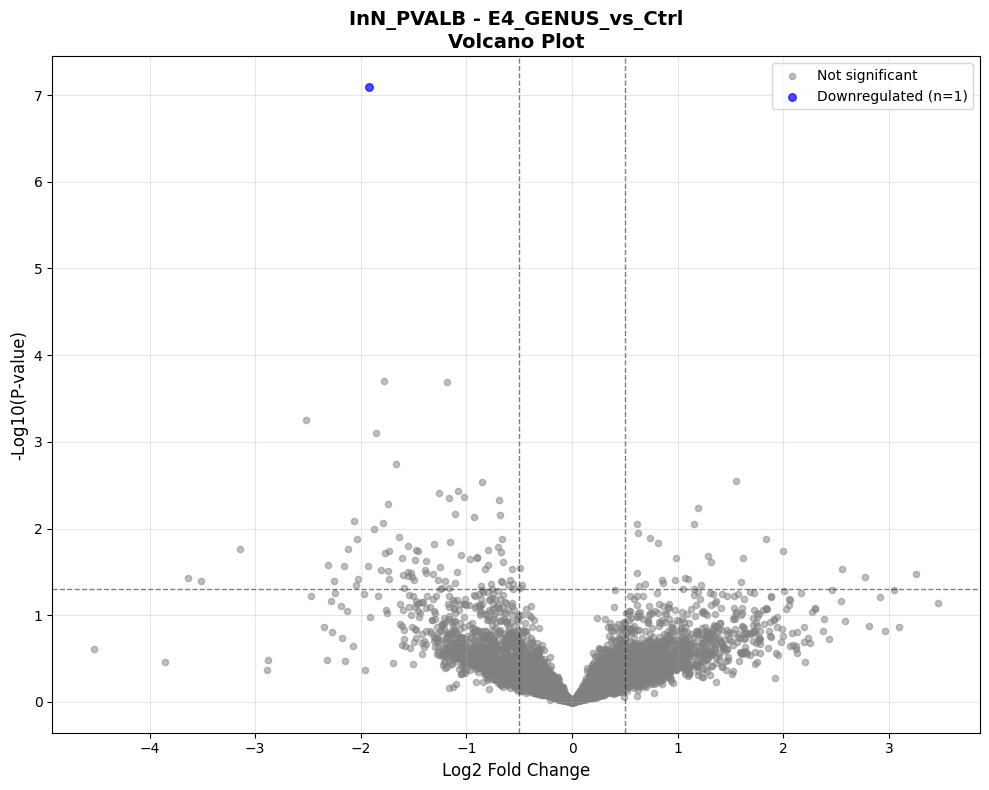

  Saved: plots/differential_expression/volcano_InN_PVALB_E4_vs_E3_Ctrl.png


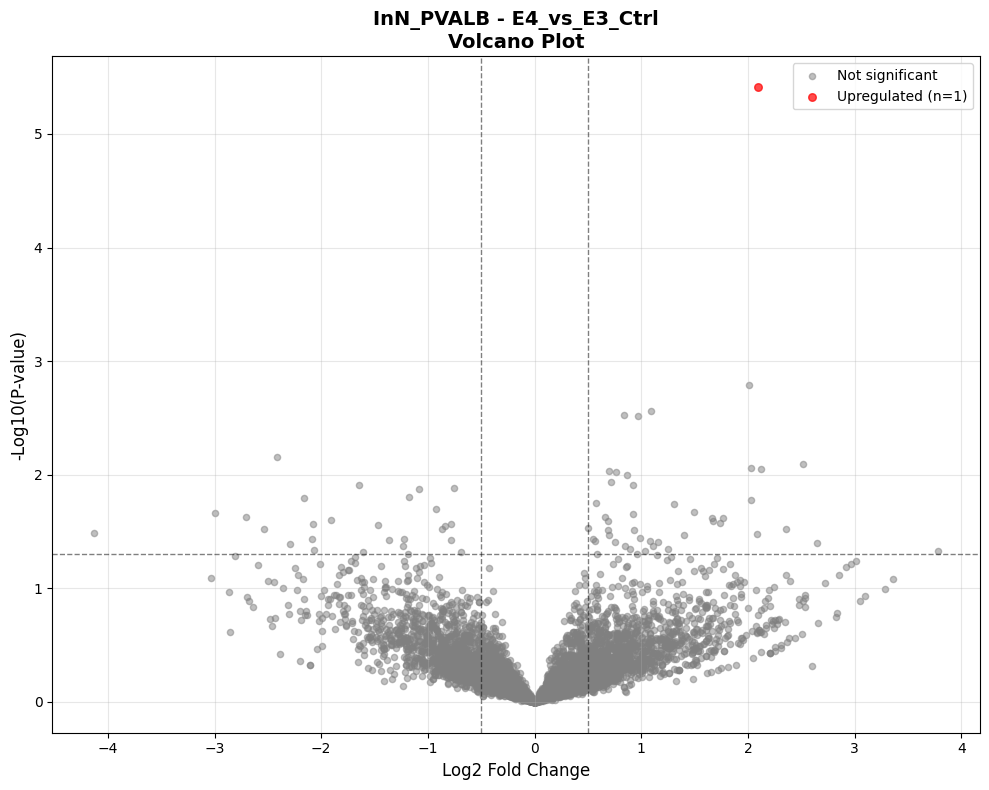

  Saved: plots/differential_expression/volcano_InN_PVALB_E4_vs_E3_GENUS.png


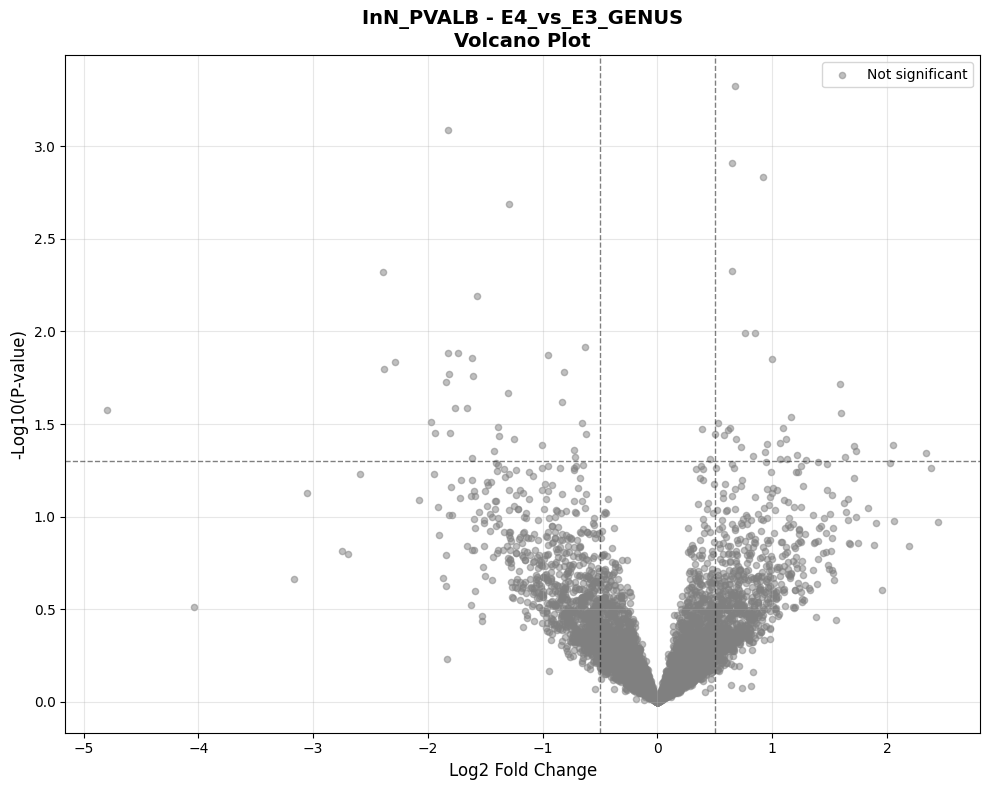

  Saved: plots/differential_expression/volcano_Astro_E3_GENUS_vs_Ctrl.png


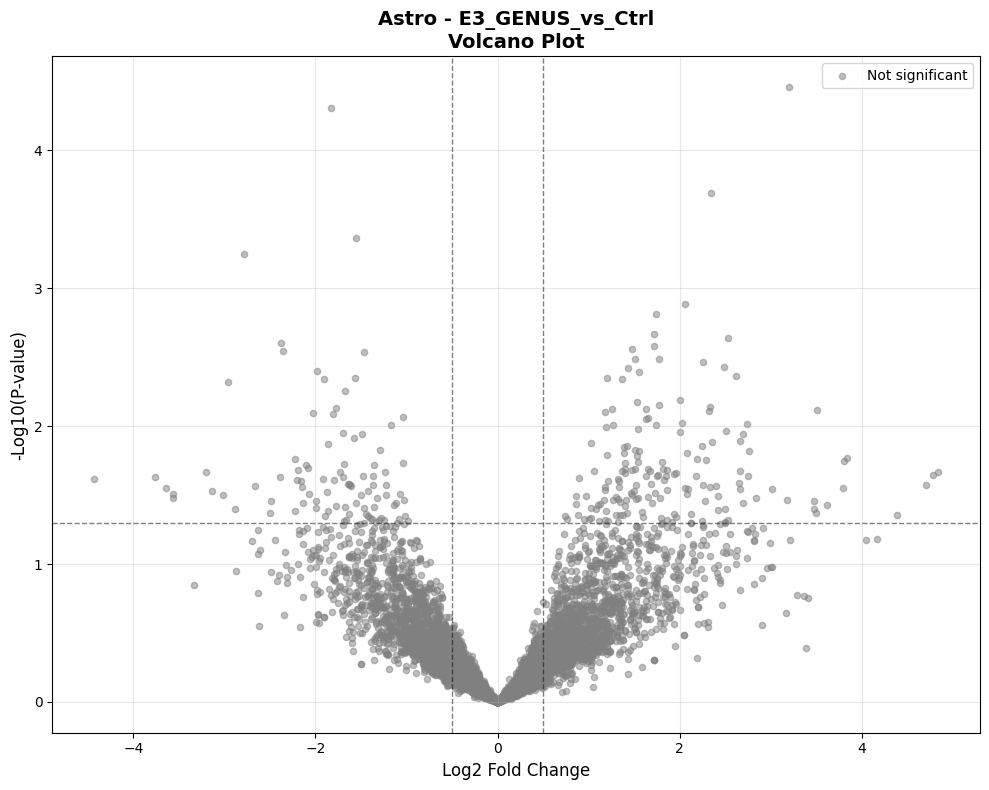

  Saved: plots/differential_expression/volcano_Astro_E4_GENUS_vs_Ctrl.png


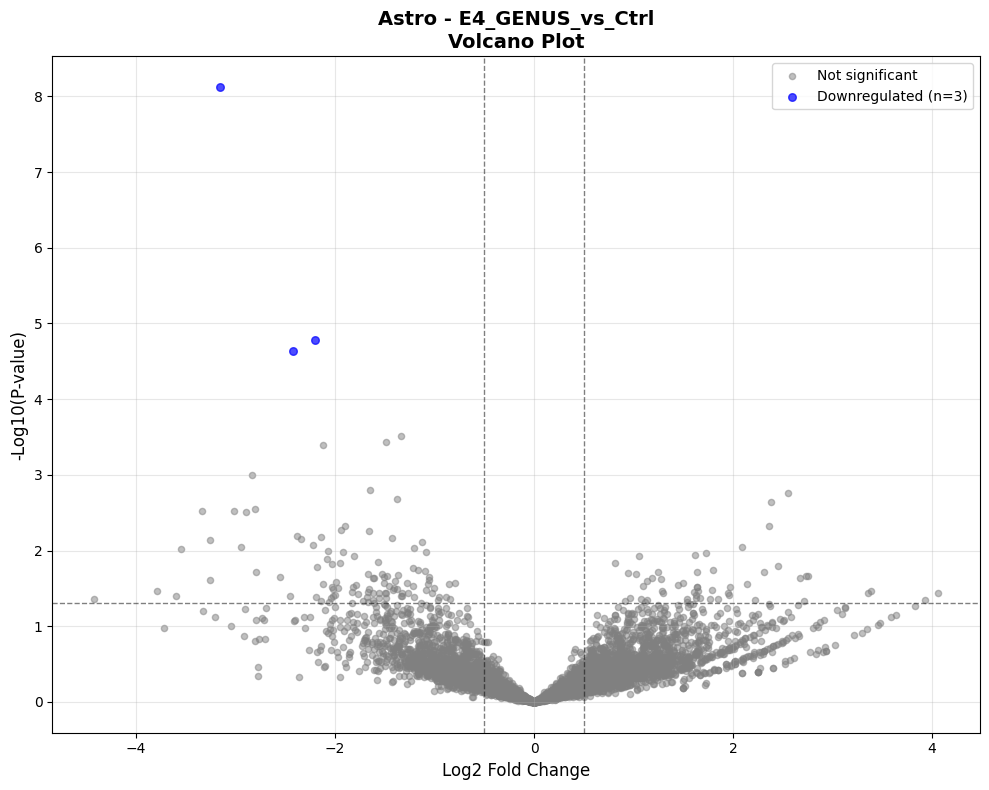

  Saved: plots/differential_expression/volcano_Astro_E4_vs_E3_Ctrl.png


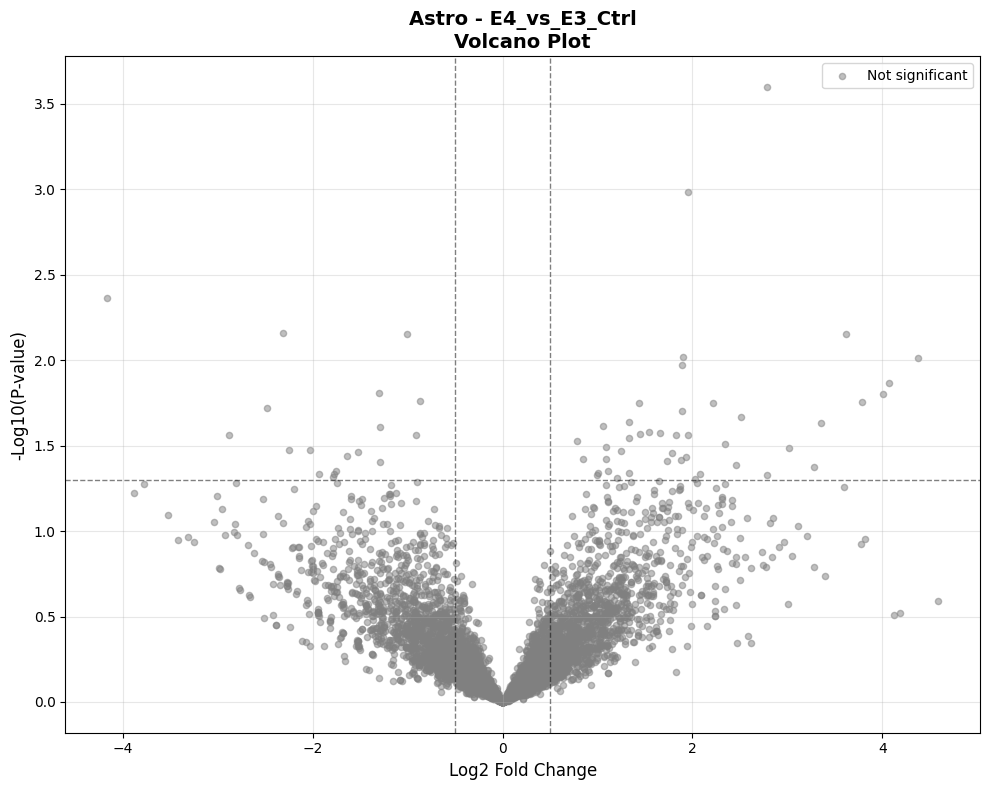

  Saved: plots/differential_expression/volcano_Astro_E4_vs_E3_GENUS.png


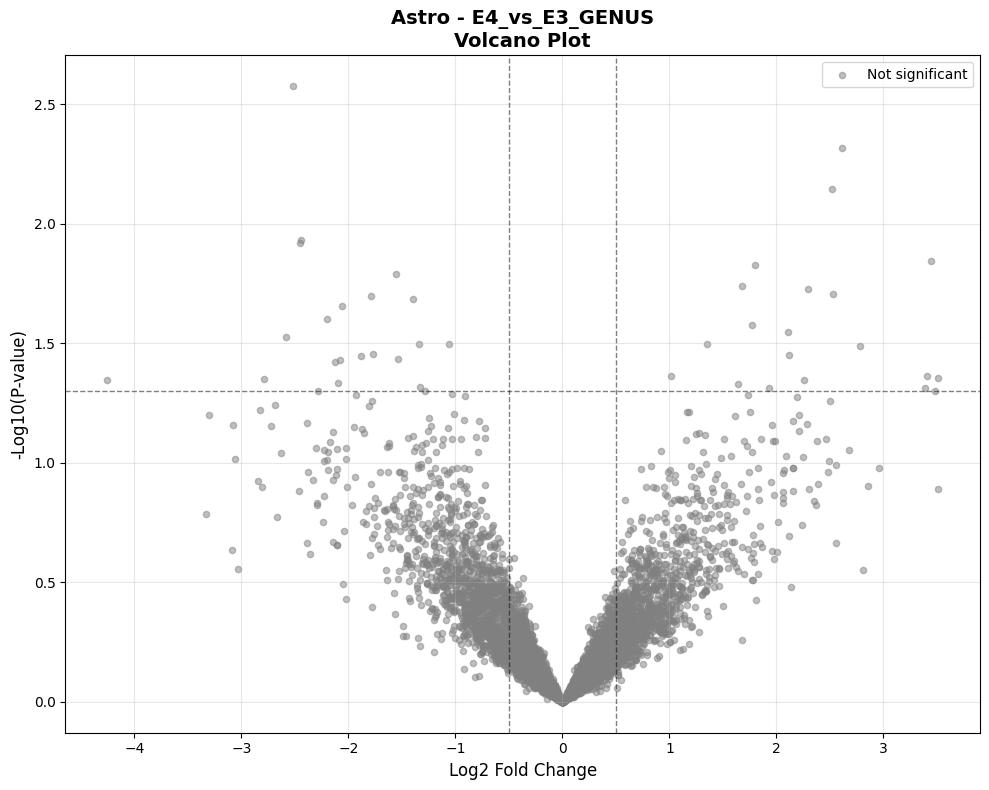

  Saved: plots/differential_expression/volcano_Inhib_E3_GENUS_vs_Ctrl.png


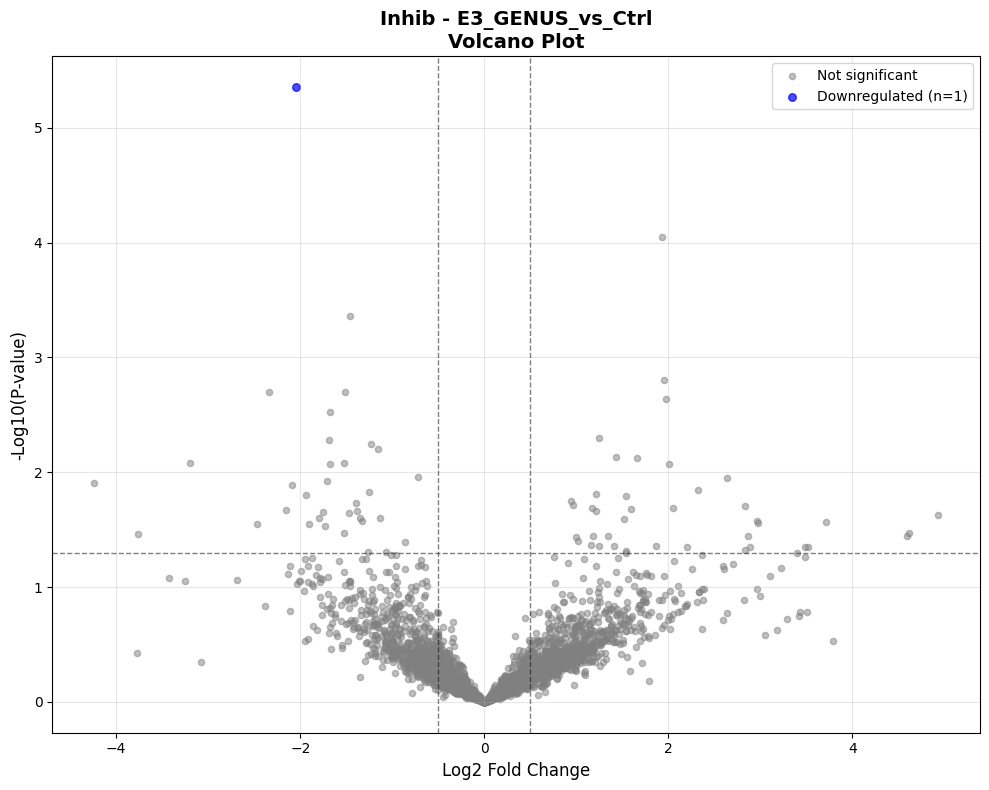

  Saved: plots/differential_expression/volcano_Inhib_E4_GENUS_vs_Ctrl.png


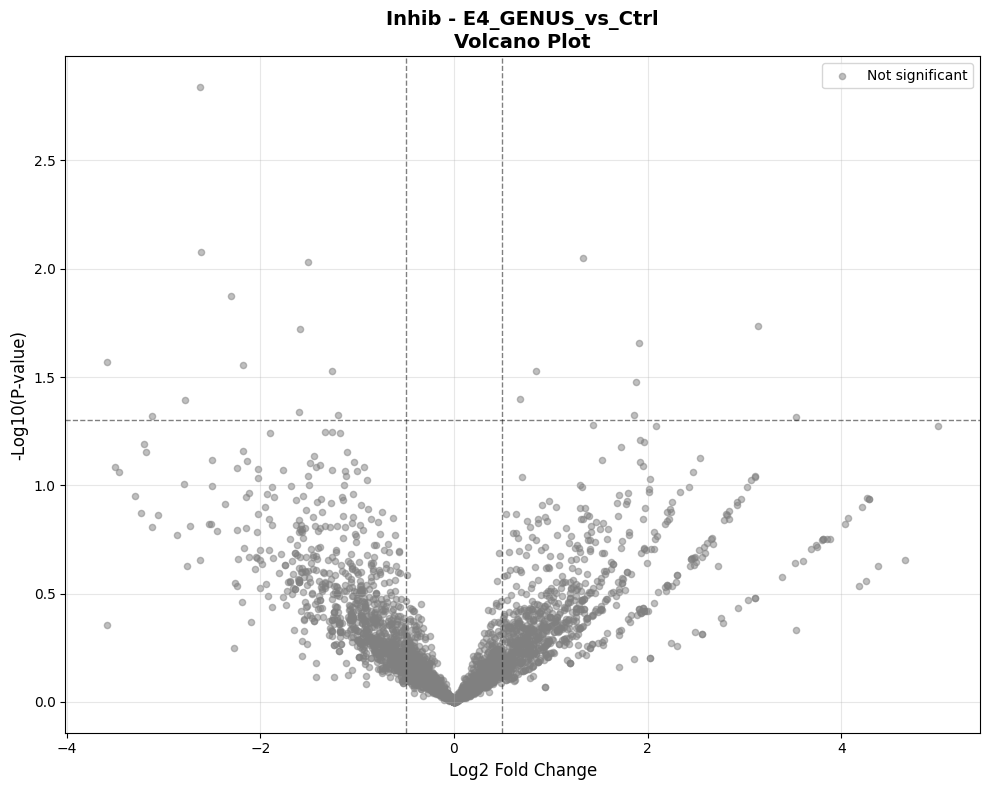

  Saved: plots/differential_expression/volcano_Inhib_E4_vs_E3_Ctrl.png


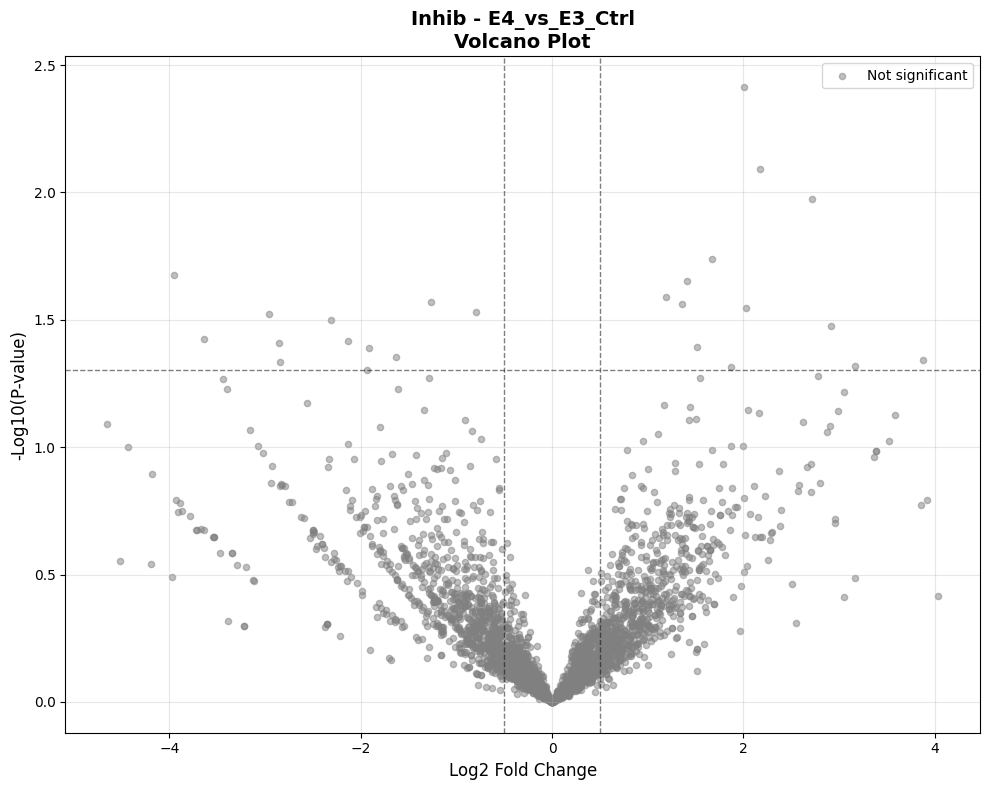

  Saved: plots/differential_expression/volcano_Inhib_E4_vs_E3_GENUS.png


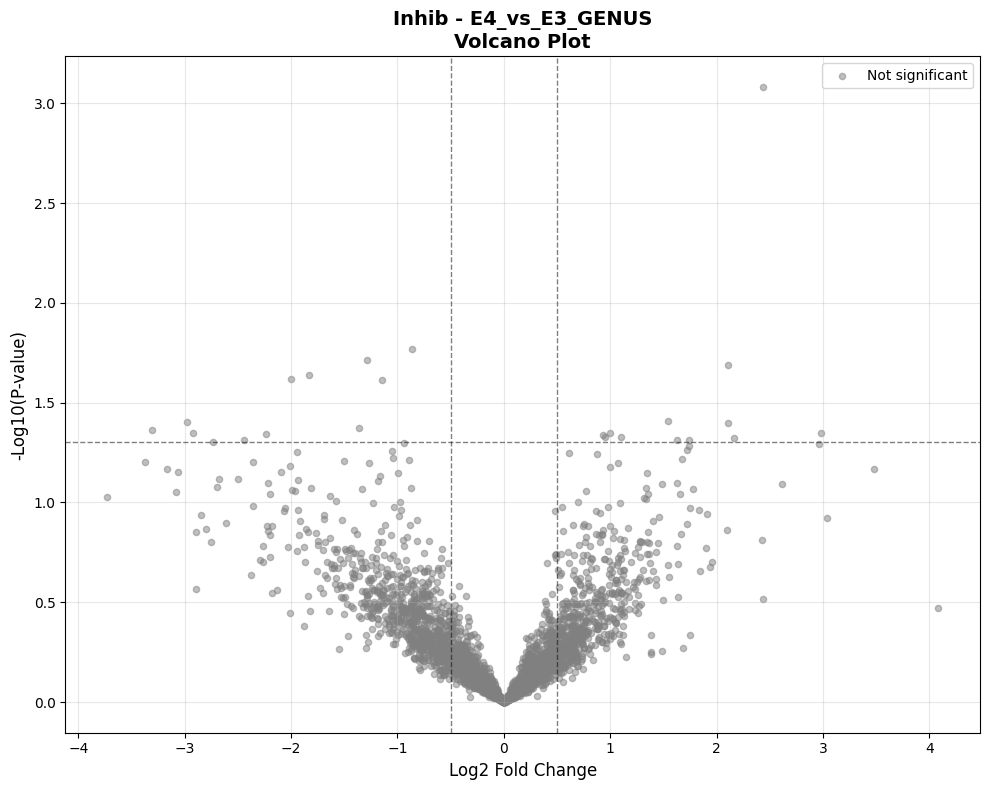

  Saved: plots/differential_expression/volcano_InN_VIP_E3_GENUS_vs_Ctrl.png


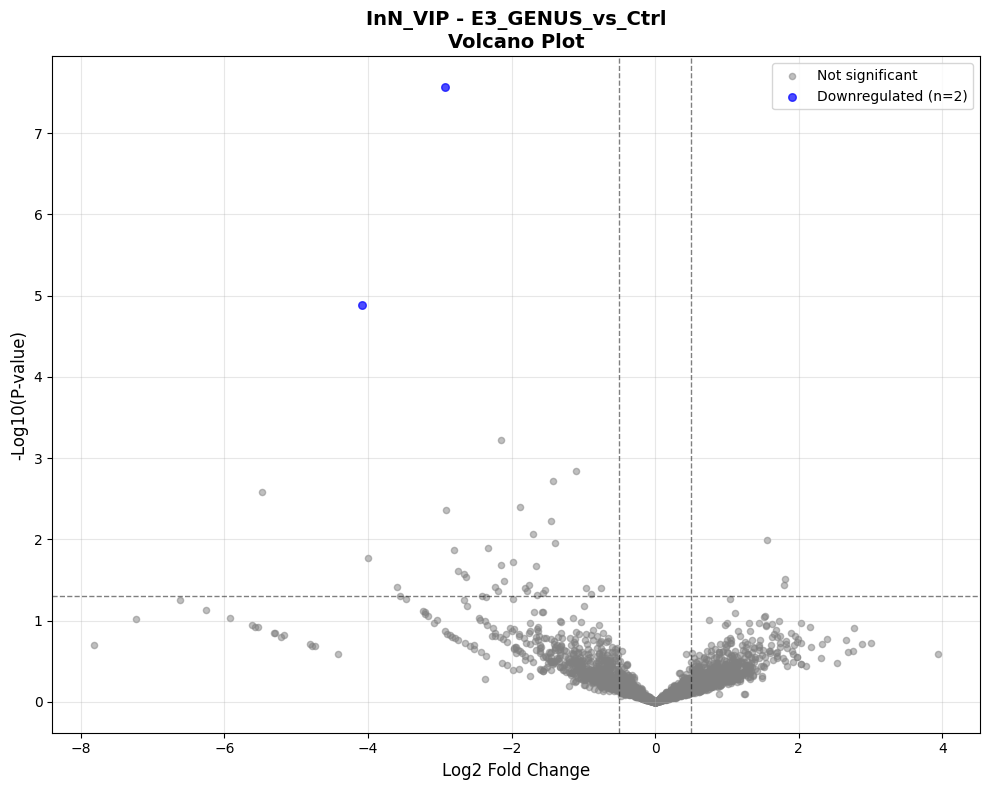

  Saved: plots/differential_expression/volcano_InN_VIP_E4_vs_E3_Ctrl.png


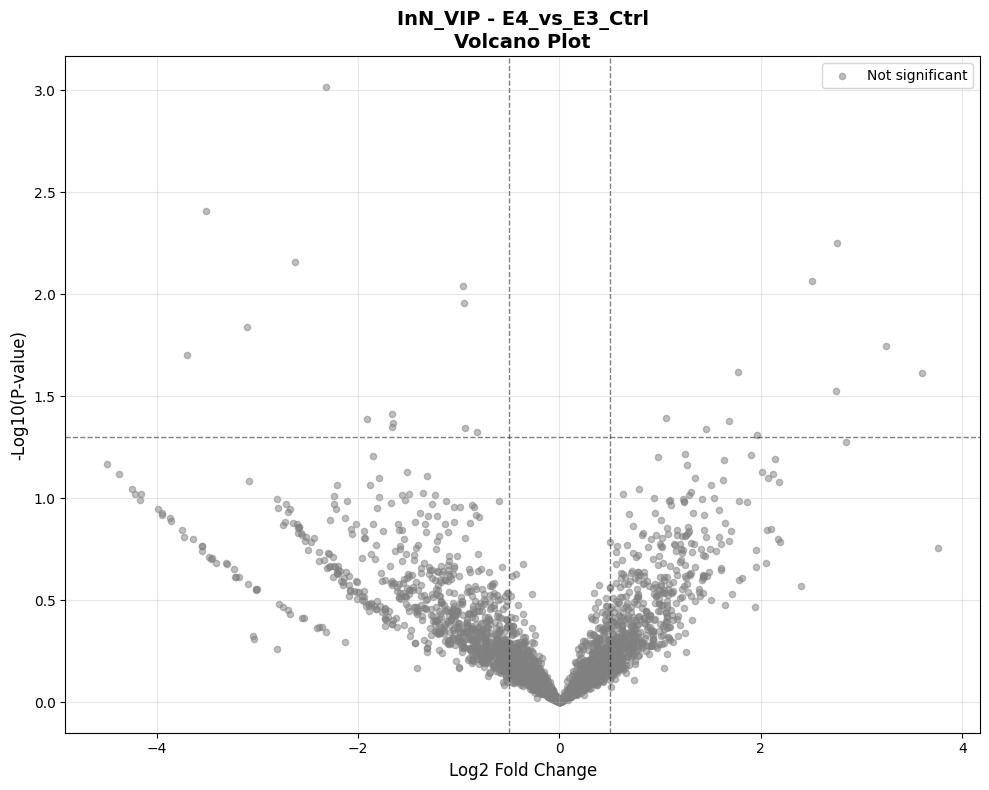

  Saved: plots/differential_expression/volcano_Endo_E3_GENUS_vs_Ctrl.png


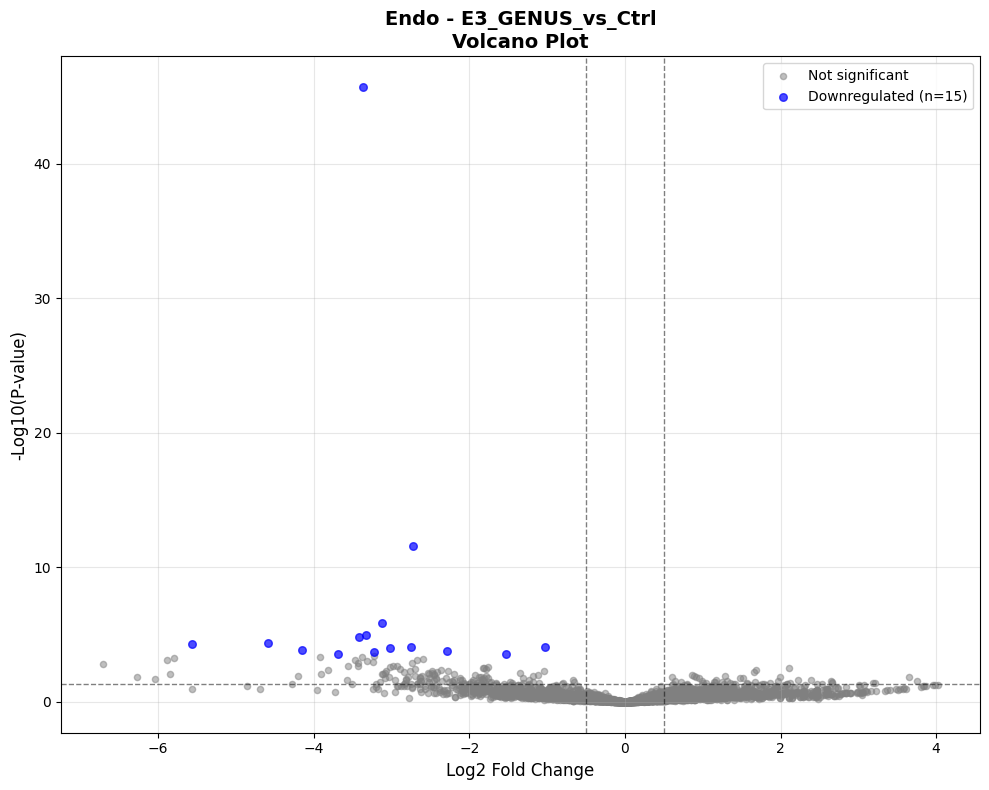

  Saved: plots/differential_expression/volcano_Endo_E4_GENUS_vs_Ctrl.png


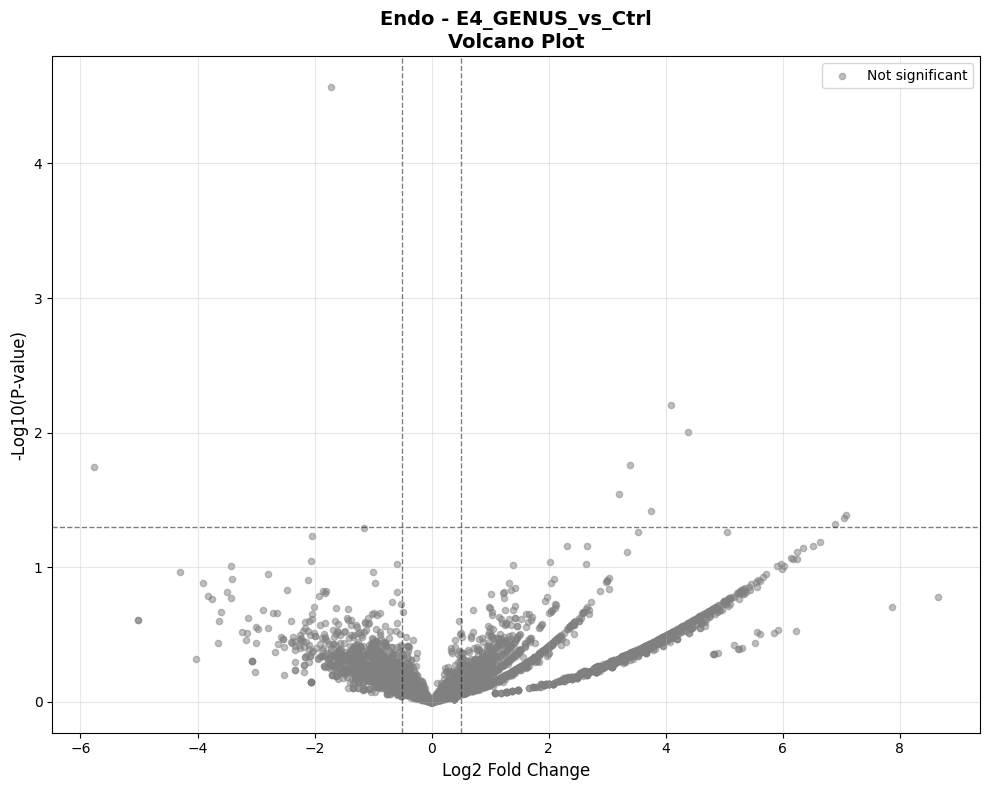

  Saved: plots/differential_expression/volcano_Endo_E4_vs_E3_Ctrl.png


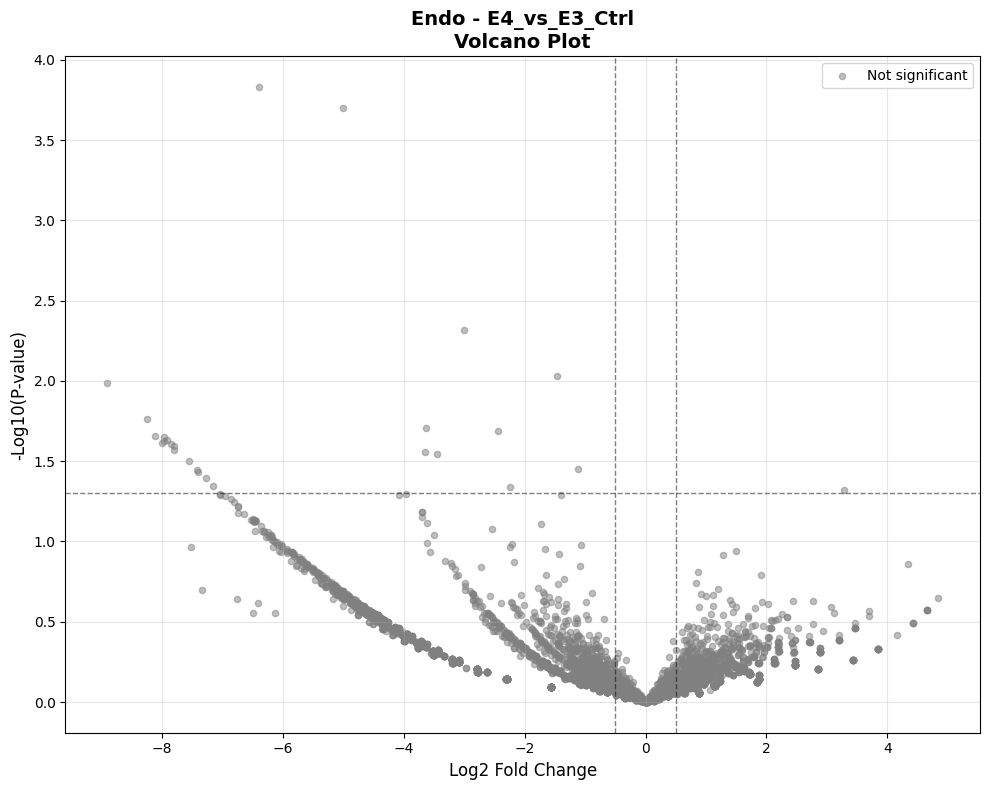

  Saved: plots/differential_expression/volcano_Endo_E4_vs_E3_GENUS.png


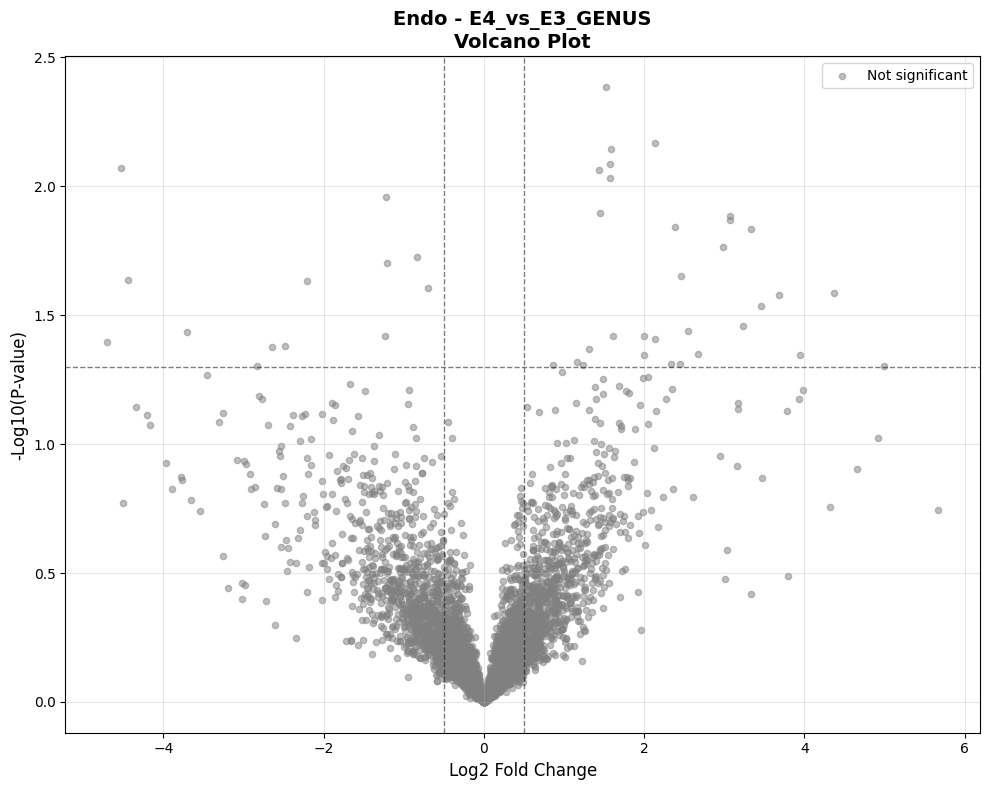

  Saved: plots/differential_expression/volcano_Oligo_E3_GENUS_vs_Ctrl.png


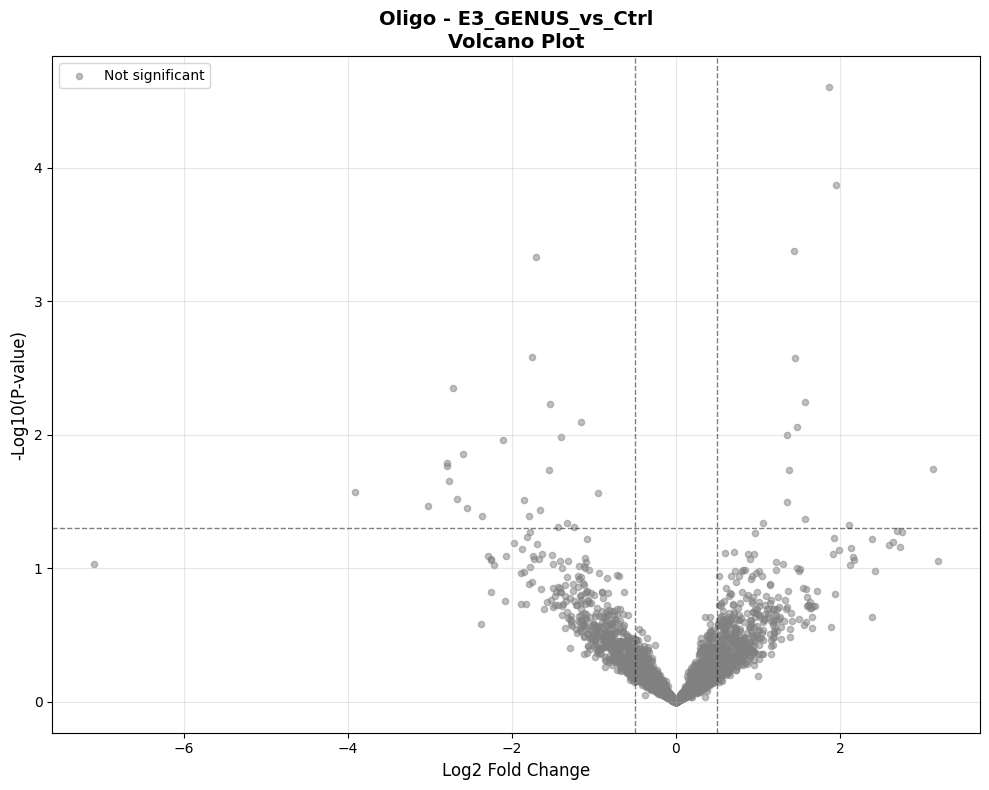

  Saved: plots/differential_expression/volcano_Oligo_E4_vs_E3_Ctrl.png


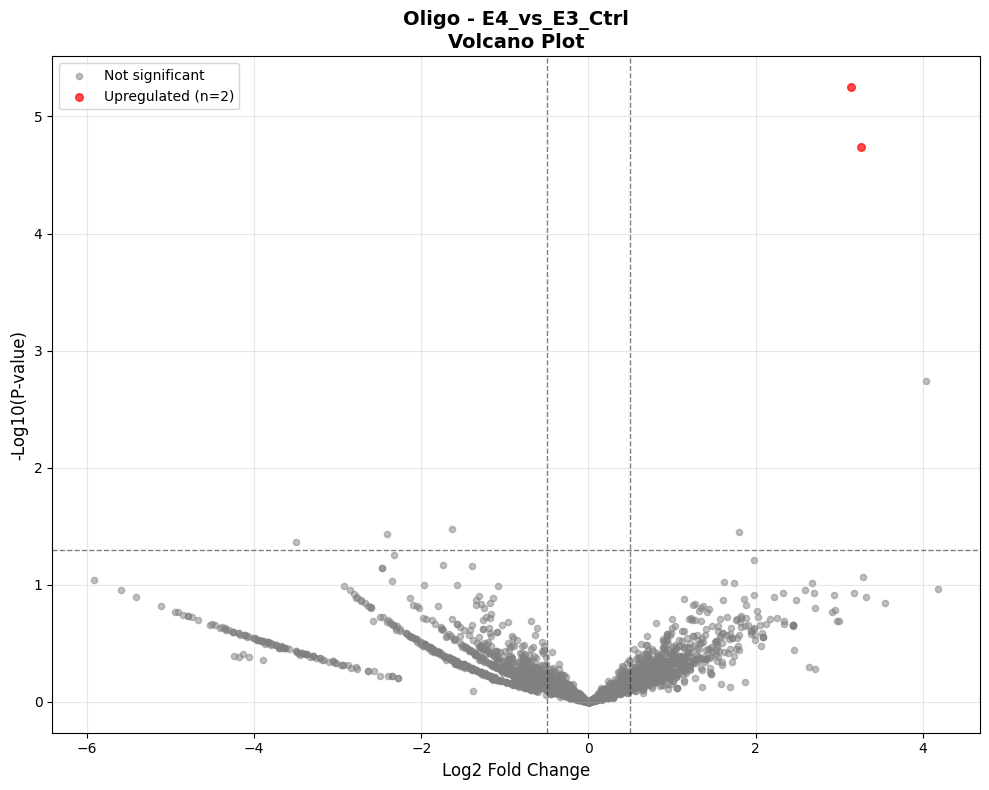

  Saved: plots/differential_expression/volcano_Oligo_E4_vs_E3_GENUS.png


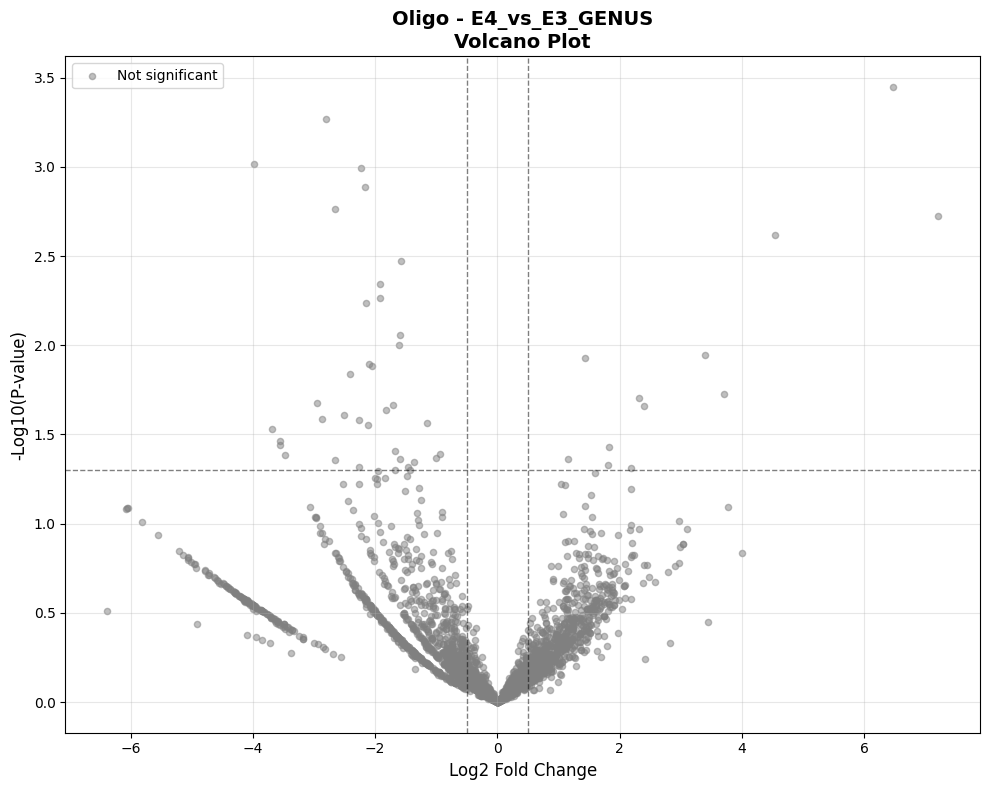

  Saved: plots/differential_expression/volcano_InN_SST_E4_GENUS_vs_Ctrl.png


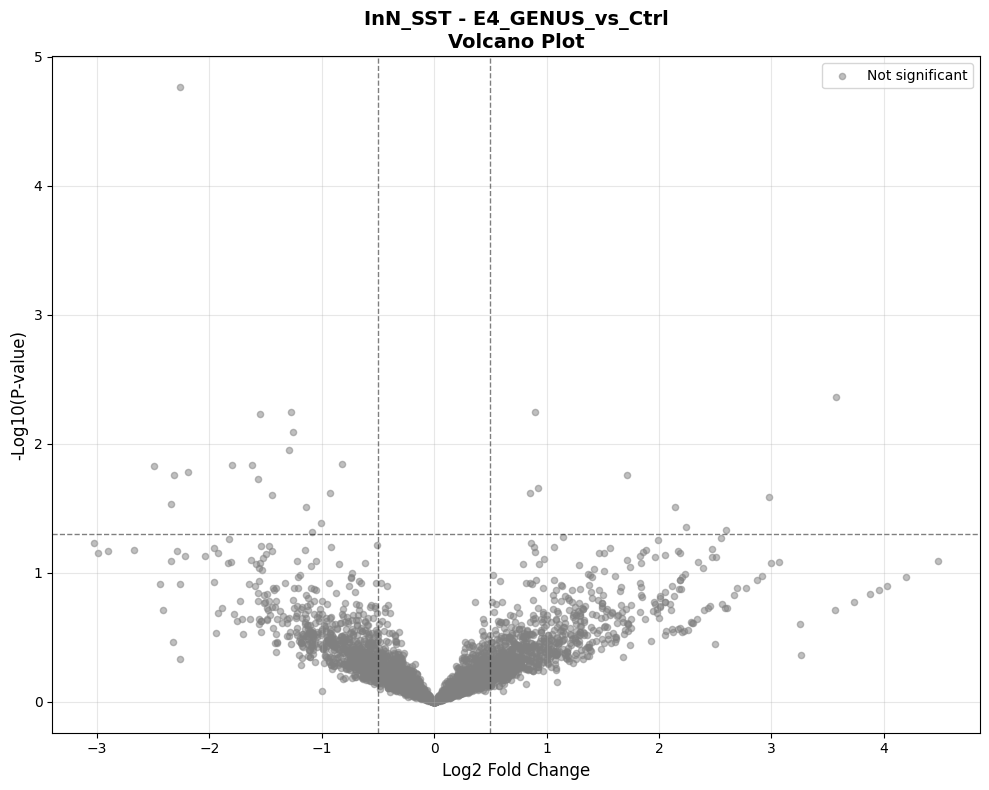

  Saved: plots/differential_expression/volcano_InN_SST_E4_vs_E3_GENUS.png


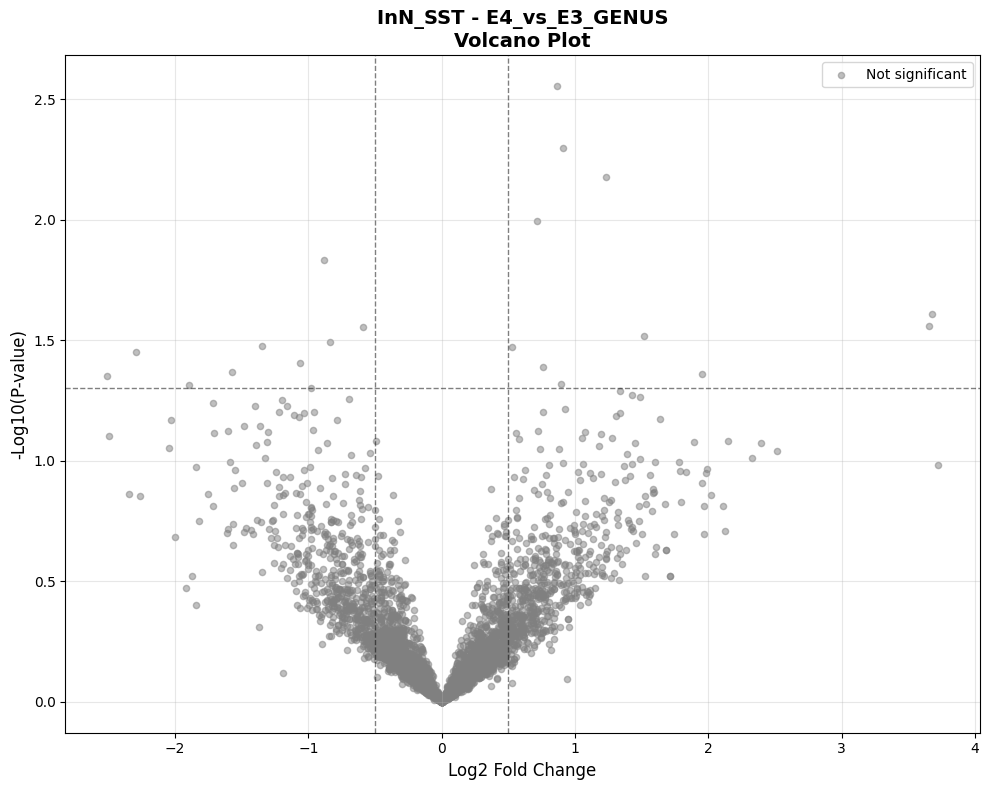

  Saved: plots/differential_expression/volcano_Micro_E4_vs_E3_GENUS.png


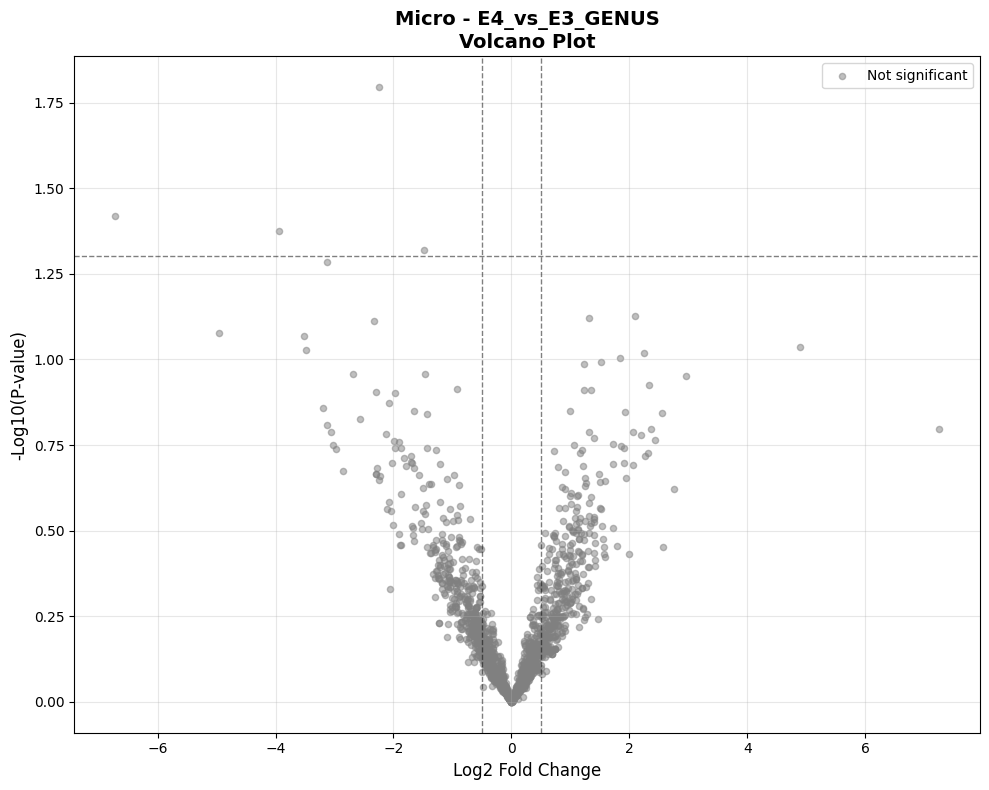

In [65]:
# Plot volcano plots for each cell type and contrast
if combined_results is not None:
    print("\n" + "="*60)
    print("GENERATING VOLCANO PLOTS")
    print("="*60)
    
    for cell_type in CELL_TYPES_TO_ANALYZE:
        ct_results = combined_results[combined_results['cell_type'] == cell_type]
        contrasts = ct_results['contrast'].unique()
        
        for contrast in contrasts:
            save_path = PLOTS_DIR / f'volcano_{cell_type}_{contrast}.png'
            plot_volcano(
                combined_results,
                cell_type,
                contrast,
                fc_threshold=VIZ_PARAMS['volcano_fc_threshold'],
                pval_threshold=VIZ_PARAMS['volcano_pval_threshold'],
                save_path=save_path
            )


## 9. Summary Statistics

Compile and export summary statistics for all differential expression results.


In [66]:
# Create summary statistics
if combined_results is not None:
    print("\n" + "="*60)
    print("DE ANALYSIS SUMMARY STATISTICS")
    print("="*60)
    
    # Summary by cell type and contrast
    summary = combined_results.groupby(['cell_type', 'contrast']).agg({
        'significant': 'sum',
        'upregulated': 'sum',
        'downregulated': 'sum',
        'gene': 'count',  # Total genes tested
    }).round(0).astype(int)
    summary.columns = ['Significant', 'Upregulated', 'Downregulated', 'Total_genes']
    
    print("\nSignificant genes by cell type and contrast:")
    print(summary)
    
    # Save summary
    summary_file = OUTPUT_DIR / 'de_summary_statistics.csv'
    summary.to_csv(summary_file)
    print(f"\n✓ Saved summary to: {summary_file}")
    
    # Top genes overall
    print("\n" + "="*60)
    print("TOP DE GENES (across all cell types)")
    print("="*60)
    
    # Get top upregulated and downregulated genes
    top_up = combined_results.nlargest(20, 'logFC')
    top_down = combined_results.nsmallest(20, 'logFC')
    
    print("\nTop 20 upregulated genes:")
    print(top_up[['gene', 'cell_type', 'contrast', 'logFC', 'adj.P.Val']].to_string(index=False))
    
    print("\nTop 20 downregulated genes:")
    print(top_down[['gene', 'cell_type', 'contrast', 'logFC', 'adj.P.Val']].to_string(index=False))
    
    # Save top genes
    top_genes_file = OUTPUT_DIR / 'top_de_genes.csv'
    top_genes = pd.concat([
        top_up[['gene', 'cell_type', 'contrast', 'logFC', 'adj.P.Val']].assign(direction='up'),
        top_down[['gene', 'cell_type', 'contrast', 'logFC', 'adj.P.Val']].assign(direction='down')
    ])
    top_genes.to_csv(top_genes_file, index=False)
    print(f"\n✓ Saved top genes to: {top_genes_file}")



DE ANALYSIS SUMMARY STATISTICS

Significant genes by cell type and contrast:
                            Significant  Upregulated  Downregulated  \
cell_type contrast                                                    
Astro     E3_GENUS_vs_Ctrl            0            0              0   
          E4_GENUS_vs_Ctrl            3            0              3   
          E4_vs_E3_Ctrl               0            0              0   
          E4_vs_E3_GENUS              0            0              0   
Endo      E3_GENUS_vs_Ctrl           15            0             15   
          E4_GENUS_vs_Ctrl            0            0              0   
          E4_vs_E3_Ctrl               0            0              0   
          E4_vs_E3_GENUS              0            0              0   
ExN_L6b   E3_GENUS_vs_Ctrl            0            0              0   
          E4_GENUS_vs_Ctrl            1            0              1   
          E4_vs_E3_Ctrl               0            0              0   

## 10. Export for DESeq2 (Optional)

For more robust statistical analysis, export pseudobulk data for DESeq2 analysis in R. DESeq2 uses negative binomial models and is generally more powerful than t-tests for RNA-seq data.


In [67]:
# Export pseudobulk data for DESeq2 analysis
print("\n" + "="*60)
print("EXPORTING FOR DESEQ2")
print("="*60)

# Export counts and sample info for each cell type
for cell_type in CELL_TYPES_TO_ANALYZE:
    ct_samples = sample_info_df[sample_info_df['celltype'] == cell_type]
    
    if len(ct_samples) < 4:
        print(f"⚠️  Skipping {cell_type}: Not enough samples")
        continue
    
    # Get counts for this cell type
    ct_counts = pb_df[ct_samples['group_id']]
    
    # Export counts
    counts_file = OUTPUT_DIR / f'pseudobulk_counts_{cell_type}.csv'
    ct_counts.to_csv(counts_file)
    
    # Export sample info
    sample_file = OUTPUT_DIR / f'sample_info_{cell_type}.csv'
    ct_samples[['group_id', 'sample_id', 'Genotype', 'Stimulation', 
                'Sex', 'condition', 'n_cells']].to_csv(sample_file, index=False)
    
    print(f"✓ Exported {cell_type}: {ct_counts.shape[0]:,} genes × {len(ct_samples)} samples")
    print(f"    Counts: {counts_file}")
    print(f"    Sample info: {sample_file}")

print("\n💡 To run DESeq2 in R:")
print("   1. Load the CSV files in R")
print("   2. Use DESeqDataSetFromMatrix() to create DESeqDataSet")
print("   3. Run DESeq() and results() for each contrast")
print("   4. See r/2_limma_voom_gsea.Rmd for example code")



EXPORTING FOR DESEQ2
✓ Exported Excit: 19,608 genes × 16 samples
    Counts: outputs/differential_expression_results/pseudobulk_counts_Excit.csv
    Sample info: outputs/differential_expression_results/sample_info_Excit.csv
✓ Exported OPC: 19,608 genes × 16 samples
    Counts: outputs/differential_expression_results/pseudobulk_counts_OPC.csv
    Sample info: outputs/differential_expression_results/sample_info_OPC.csv
✓ Exported ExN_L6b: 19,608 genes × 13 samples
    Counts: outputs/differential_expression_results/pseudobulk_counts_ExN_L6b.csv
    Sample info: outputs/differential_expression_results/sample_info_ExN_L6b.csv
✓ Exported InN_PVALB: 19,608 genes × 15 samples
    Counts: outputs/differential_expression_results/pseudobulk_counts_InN_PVALB.csv
    Sample info: outputs/differential_expression_results/sample_info_InN_PVALB.csv
✓ Exported Astro: 19,608 genes × 14 samples
    Counts: outputs/differential_expression_results/pseudobulk_counts_Astro.csv
    Sample info: outputs/diffe

## 11. Analysis Complete! 🎉

### Output Files

**Main results:**
- `outputs/differential_expression_results/differential_expression_results.csv` - Full DE results
- `outputs/differential_expression_results/de_summary_statistics.csv` - Summary statistics
- `outputs/differential_expression_results/top_de_genes.csv` - Top DE genes

**Pseudobulk data (for DESeq2):**
- `outputs/differential_expression_results/pseudobulk_counts_*.csv` - Count matrices per cell type
- `outputs/differential_expression_results/sample_info_*.csv` - Sample metadata per cell type

**Plots:**
- `plots/differential_expression/heatmap_*.png` - Heatmaps for each cell type and contrast
- `plots/differential_expression/volcano_*.png` - Volcano plots for each cell type and contrast

### Next Steps

1. **Review significant genes** - Check top DE genes for biological relevance
2. **Pathway enrichment** - Run GSEA or GO enrichment on significant genes
3. **Validate with literature** - Check if DE genes match known pathways
4. **DESeq2 analysis** - For more robust statistics, use exported data in R
5. **Cell type-specific effects** - Compare DE patterns across cell types

### Notes

- Current analysis uses t-tests on log-CPM data
- For publication-quality results, consider using DESeq2 (negative binomial model)
- Multiple testing correction (FDR) has been applied
- Focus on genes with both significant p-values AND meaningful fold changes
